In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg
import discretizationUtils as grid
import config as config
import operators as op
import matrices
import time
from tqdm import tqdm

In [3]:
config

<module 'config' from '/Users/danyunhe2/danyun_xi/Archive/config.py'>

In [4]:
# --- Setup; using the config as a 'global variable module' --- #
config.ny = 40
config.nx = 80
config.dy = 1.0 / (config.ny)
config.dx = 2.0 / (config.nx)
config.dt = 0.00001
config.nt = int(0.05 / config.dt)
dt = config.dt
nt = config.nt
ny = config.ny
nx = config.nx
dy = config.dy
dx = config.dx

# Use LU decomposition (for solving sparse system)
useSuperLUFactorizationEq1 = True  # doesn't do much as it needs to be done every loop
useSuperLUFactorizationEq2 = True  # Speeds up, quite a bit!

# Physical parameters (stream potential is 0 on all boundaries, hardcoded).
sqrtRa = 25
Tbottom = 1
Ttop = 0
tempDirichlet = np.array([np.ones((nx,)) * Tbottom, np.ones((nx,)) * Ttop])
tempNeumann = [0, 0]

# Use initial instability (also changes nt to 3000)
instability = True

# Plotting settings
generateAnimation = True
generateEvery = 1
generateFinal = False
qInt = 4  # What's the quiver vector interval? Want to plot every vector?
qScale = 40  # Scale the vectors?

# ---  No modifications below this point! --- #

assert (dx == dy)

# Initial conditions
startT = np.expand_dims(np.linspace(Tbottom, Ttop, ny), 1).repeat(nx, axis=1)
if instability:
    startT[int(ny / 2 - 3):int(ny / 2 + 3), int(nx / 2 - 3):int(nx / 2 + 3)] = 1.0
startT = grid.fieldToVec(startT)
startPsi = np.expand_dims(np.zeros(ny), 1).repeat(nx, axis=1)  # start with zeros for streamfunctions
startPsi = grid.fieldToVec(startPsi)

In [5]:
print("Buoyancy driven flow:\nRayleigh number: %.2f\ndt: %.2e\nnt: %i\ndx: %.2e\ndy: %.2e" % (
    sqrtRa * sqrtRa, dt, nt, dx, dy))
print("Critical CFL velocity: %.2e" % (dx / dt))

Buoyancy driven flow:
Rayleigh number: 625.00
dt: 1.00e-05
nt: 5000
dx: 2.50e-02
dy: 2.50e-02
Critical CFL velocity: 2.50e+03


In [6]:
# Generate operators for differentials
dyOpPsi = op.dyOp()
dxOpPsi = op.dxOpStream()
dlOpPsi = op.dlOpStreamMod()
dlOpTemp, rhsDlOpTemp = op.dlOpTemp(bcDirArray=tempDirichlet, bcNeuArray=tempNeumann)
dxOpTemp, rhsDxOpTemp = op.dxOpTemp(bcNeuArray=tempNeumann)
dyOpTemp, rhsDyOpTemp = op.dyOpTemp(bcDirArray=tempDirichlet)

# This matrix is needed to only use the Non-Dirichlet rows in the del²psi operator. The other rows are basically
# ensuring psi_i,j = 0. What it does is it removes rows from a sparse matrix (unit matrix with some missing elements).
# PsiEliminator -> psiElim
psiElim = np.ones((nx * ny,))
psiElim[0:ny] = 0
psiElim[-ny:] = 0
psiElim[ny::ny] = 0
psiElim[ny - 1::ny] = 0
psiElim = sparse.csc_matrix(sparse.diags(psiElim, 0))

Runtime of LU factorization for eq-1: 1.64e-02 seconds


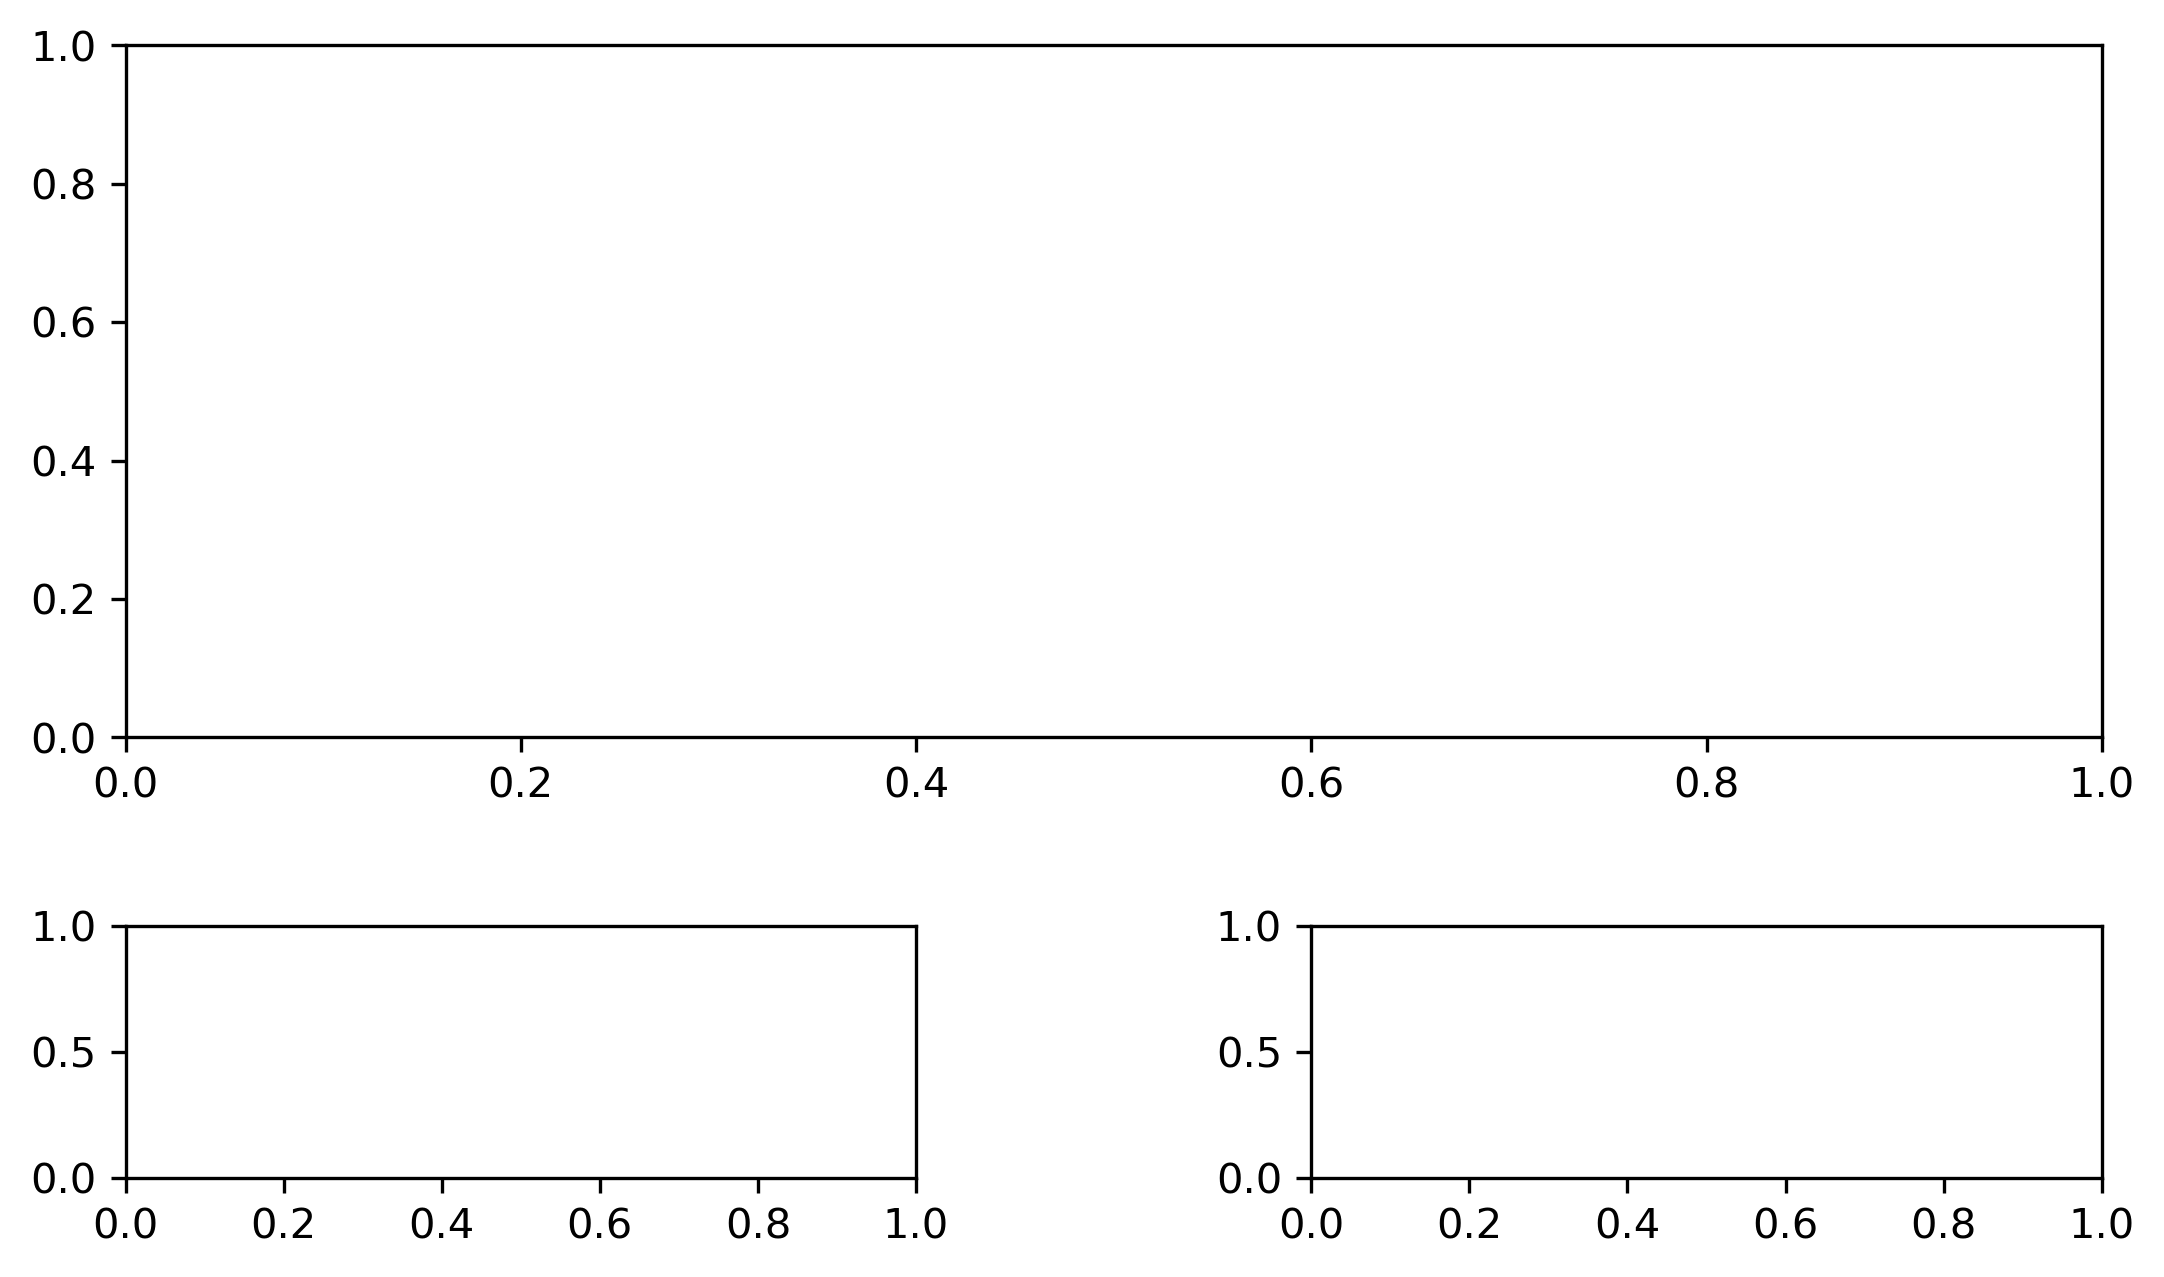

In [7]:
# Pretty straightforwad; set up the animation stuff
if (generateAnimation):
    # Set up for animation
    fig = plt.figure(figsize=(8.5, 5), dpi=300)
    gs = gridspec.GridSpec(3, 2)
    gs.update(wspace=0.5, hspace=0.75)
    ax1 = plt.subplot(gs[0:2, :], )
    ax2 = plt.subplot(gs[2, 0])
    ax3 = plt.subplot(gs[2, 1])
else:
    fig = plt.figure(figsize=(8.5, 5), dpi=600)

# -- Preconditioning -- #
if (useSuperLUFactorizationEq1):
    start = time.time()
    # Makes LU decomposition.
    factor1 = sparse.linalg.factorized(dlOpPsi)
    end = time.time()
    print("Runtime of LU factorization for eq-1: %.2e seconds" % (end - start))

# Set up initial
Tnplus1 = startT
Psinplus1 = startPsi

# initialize accumulators
t = []
maxSpeedArr = []
heatFluxConductionArr = []
heatFluxAdvectionArr = []
totalHeatFluxArr = []

  0%|          | 1/5001 [00:00<12:02,  6.92it/s]

Starting time marching for 5000 steps ...


  0%|          | 3/5001 [00:00<10:48,  7.71it/s]

  0%|          | 5/5001 [00:00<10:24,  8.00it/s]

  0%|          | 7/5001 [00:00<09:57,  8.36it/s]

  0%|          | 9/5001 [00:01<09:37,  8.64it/s]

  0%|          | 11/5001 [00:01<09:21,  8.89it/s]

  0%|          | 13/5001 [00:01<09:45,  8.51it/s]

  0%|          | 15/5001 [00:01<09:24,  8.83it/s]

  0%|          | 17/5001 [00:01<09:16,  8.96it/s]

  0%|          | 19/5001 [00:02<10:40,  7.78it/s]

  0%|          | 21/5001 [00:02<11:51,  7.00it/s]

  0%|          | 23/5001 [00:02<11:24,  7.28it/s]

  0%|          | 25/5001 [00:03<10:32,  7.86it/s]

  1%|          | 27/5001 [00:03<10:30,  7.89it/s]

  1%|          | 29/5001 [00:03<10:57,  7.56it/s]

  1%|          | 31/5001 [00:03<10:16,  8.07it/s]

  1%|          | 33/5001 [00:04<09:39,  8.58it/s]

  1%|          | 35/5001 [00:04<10:17,  8.04it/s]

  1%|          | 37/5001 [00:04<10:17,  8.04it/s]

  1%|          | 39/5001 [00:04<11:20,  7.29it/s]

  1%|          | 41/5001 [00:05<10:17,  8.04it/s]

  1%|          | 43/5001 [00:05<09:45,  8.46it/s]

  1%|          | 45/5001 [00:05<10:33,  7.83it/s]

  1%|          | 47/5001 [00:05<10:29,  7.87it/s]

  1%|          | 49/5001 [00:06<09:51,  8.37it/s]

  1%|          | 51/5001 [00:06<09:38,  8.56it/s]

  1%|          | 53/5001 [00:06<09:26,  8.73it/s]

  1%|          | 55/5001 [00:06<09:23,  8.77it/s]

  1%|          | 57/5001 [00:07<09:45,  8.45it/s]

  1%|          | 59/5001 [00:07<11:35,  7.11it/s]

  1%|          | 61/5001 [00:07<10:22,  7.93it/s]

  1%|▏         | 63/5001 [00:07<09:47,  8.40it/s]

  1%|▏         | 65/5001 [00:08<09:31,  8.64it/s]

  1%|▏         | 67/5001 [00:08<10:02,  8.19it/s]

  1%|▏         | 69/5001 [00:08<10:53,  7.54it/s]

  1%|▏         | 71/5001 [00:08<10:39,  7.71it/s]

  1%|▏         | 73/5001 [00:09<09:57,  8.25it/s]

  1%|▏         | 75/5001 [00:09<10:03,  8.17it/s]

  2%|▏         | 77/5001 [00:09<10:37,  7.72it/s]

  2%|▏         | 79/5001 [00:09<09:59,  8.21it/s]

  2%|▏         | 81/5001 [00:10<10:55,  7.51it/s]

  2%|▏         | 83/5001 [00:10<11:20,  7.23it/s]

  2%|▏         | 85/5001 [00:10<10:15,  7.99it/s]

  2%|▏         | 87/5001 [00:10<10:08,  8.08it/s]

  2%|▏         | 89/5001 [00:11<10:05,  8.11it/s]

  2%|▏         | 91/5001 [00:11<09:42,  8.43it/s]

  2%|▏         | 93/5001 [00:11<11:22,  7.19it/s]

  2%|▏         | 95/5001 [00:11<10:53,  7.51it/s]

  2%|▏         | 97/5001 [00:12<10:08,  8.06it/s]

  2%|▏         | 99/5001 [00:12<11:07,  7.35it/s]

  2%|▏         | 101/5001 [00:12<11:34,  7.06it/s]

  2%|▏         | 103/5001 [00:13<12:09,  6.71it/s]

  2%|▏         | 105/5001 [00:13<11:32,  7.07it/s]

  2%|▏         | 107/5001 [00:13<13:28,  6.05it/s]

  2%|▏         | 109/5001 [00:13<12:32,  6.50it/s]

  2%|▏         | 111/5001 [00:14<11:28,  7.11it/s]

  2%|▏         | 113/5001 [00:14<10:15,  7.94it/s]

  2%|▏         | 115/5001 [00:14<11:07,  7.32it/s]

  2%|▏         | 117/5001 [00:14<10:32,  7.72it/s]

  2%|▏         | 119/5001 [00:15<11:02,  7.37it/s]

  2%|▏         | 121/5001 [00:15<10:27,  7.77it/s]

  2%|▏         | 123/5001 [00:15<09:43,  8.36it/s]

  2%|▏         | 125/5001 [00:15<09:48,  8.28it/s]

  3%|▎         | 127/5001 [00:16<10:36,  7.65it/s]

  3%|▎         | 129/5001 [00:16<10:20,  7.86it/s]

  3%|▎         | 131/5001 [00:16<11:56,  6.80it/s]

  3%|▎         | 133/5001 [00:17<10:26,  7.77it/s]

  3%|▎         | 135/5001 [00:17<10:15,  7.90it/s]

  3%|▎         | 137/5001 [00:17<09:36,  8.43it/s]

  3%|▎         | 139/5001 [00:17<09:21,  8.66it/s]

  3%|▎         | 141/5001 [00:18<09:27,  8.56it/s]

  3%|▎         | 143/5001 [00:18<09:19,  8.68it/s]

  3%|▎         | 145/5001 [00:18<09:11,  8.81it/s]

  3%|▎         | 147/5001 [00:18<09:04,  8.92it/s]

  3%|▎         | 149/5001 [00:18<09:04,  8.90it/s]

  3%|▎         | 151/5001 [00:19<09:06,  8.88it/s]

  3%|▎         | 153/5001 [00:19<09:04,  8.90it/s]

  3%|▎         | 155/5001 [00:19<09:52,  8.17it/s]

  3%|▎         | 157/5001 [00:19<09:24,  8.58it/s]

  3%|▎         | 159/5001 [00:20<09:15,  8.72it/s]

  3%|▎         | 161/5001 [00:20<09:08,  8.82it/s]

  3%|▎         | 163/5001 [00:20<09:06,  8.85it/s]

  3%|▎         | 165/5001 [00:20<09:04,  8.88it/s]

  3%|▎         | 167/5001 [00:21<09:04,  8.88it/s]

  3%|▎         | 169/5001 [00:21<09:00,  8.94it/s]

  3%|▎         | 171/5001 [00:21<09:01,  8.92it/s]

  3%|▎         | 173/5001 [00:21<09:00,  8.93it/s]

  3%|▎         | 175/5001 [00:21<09:00,  8.93it/s]

  4%|▎         | 177/5001 [00:22<08:59,  8.94it/s]

  4%|▎         | 179/5001 [00:22<10:18,  7.80it/s]

  4%|▎         | 181/5001 [00:22<09:37,  8.34it/s]

  4%|▎         | 183/5001 [00:22<09:20,  8.59it/s]

  4%|▎         | 185/5001 [00:23<09:09,  8.76it/s]

  4%|▎         | 187/5001 [00:23<09:04,  8.84it/s]

  4%|▍         | 189/5001 [00:23<09:09,  8.76it/s]

  4%|▍         | 191/5001 [00:23<09:20,  8.58it/s]

  4%|▍         | 193/5001 [00:24<09:15,  8.66it/s]

  4%|▍         | 195/5001 [00:24<09:06,  8.80it/s]

  4%|▍         | 197/5001 [00:24<09:01,  8.87it/s]

  4%|▍         | 199/5001 [00:24<09:09,  8.74it/s]

  4%|▍         | 201/5001 [00:24<09:06,  8.79it/s]

  4%|▍         | 203/5001 [00:25<09:05,  8.79it/s]

  4%|▍         | 205/5001 [00:25<09:58,  8.01it/s]

  4%|▍         | 207/5001 [00:25<09:29,  8.42it/s]

  4%|▍         | 209/5001 [00:25<09:17,  8.60it/s]

  4%|▍         | 211/5001 [00:26<09:18,  8.58it/s]

  4%|▍         | 213/5001 [00:26<09:10,  8.70it/s]

  4%|▍         | 215/5001 [00:26<09:08,  8.72it/s]

  4%|▍         | 217/5001 [00:26<09:09,  8.70it/s]

  4%|▍         | 219/5001 [00:27<09:08,  8.72it/s]

  4%|▍         | 221/5001 [00:27<09:07,  8.73it/s]

  4%|▍         | 223/5001 [00:27<09:07,  8.72it/s]

  4%|▍         | 225/5001 [00:27<09:06,  8.75it/s]

  5%|▍         | 227/5001 [00:27<09:10,  8.67it/s]

  5%|▍         | 229/5001 [00:28<10:42,  7.43it/s]

  5%|▍         | 231/5001 [00:28<10:55,  7.28it/s]

  5%|▍         | 233/5001 [00:28<11:04,  7.18it/s]

  5%|▍         | 235/5001 [00:29<11:26,  6.94it/s]

  5%|▍         | 237/5001 [00:29<12:01,  6.61it/s]

  5%|▍         | 239/5001 [00:29<10:34,  7.50it/s]

  5%|▍         | 241/5001 [00:29<11:42,  6.77it/s]

  5%|▍         | 243/5001 [00:30<12:14,  6.47it/s]

  5%|▍         | 245/5001 [00:30<12:04,  6.56it/s]

  5%|▍         | 247/5001 [00:30<11:15,  7.04it/s]

  5%|▍         | 249/5001 [00:31<12:03,  6.57it/s]

  5%|▌         | 251/5001 [00:31<11:08,  7.11it/s]

  5%|▌         | 253/5001 [00:31<12:14,  6.46it/s]

  5%|▌         | 255/5001 [00:32<11:40,  6.77it/s]

  5%|▌         | 257/5001 [00:32<10:26,  7.57it/s]

  5%|▌         | 259/5001 [00:32<10:10,  7.76it/s]

  5%|▌         | 261/5001 [00:32<09:48,  8.06it/s]

  5%|▌         | 263/5001 [00:33<09:55,  7.95it/s]

  5%|▌         | 265/5001 [00:33<09:39,  8.18it/s]

  5%|▌         | 267/5001 [00:33<09:28,  8.33it/s]

  5%|▌         | 269/5001 [00:33<09:25,  8.37it/s]

  5%|▌         | 271/5001 [00:34<09:27,  8.34it/s]

  5%|▌         | 273/5001 [00:34<10:13,  7.71it/s]

  5%|▌         | 275/5001 [00:34<11:30,  6.84it/s]

  6%|▌         | 277/5001 [00:34<11:20,  6.95it/s]

  6%|▌         | 279/5001 [00:35<10:32,  7.47it/s]

  6%|▌         | 281/5001 [00:35<12:30,  6.29it/s]

  6%|▌         | 283/5001 [00:35<12:07,  6.48it/s]

  6%|▌         | 285/5001 [00:36<12:02,  6.53it/s]

  6%|▌         | 287/5001 [00:36<11:41,  6.72it/s]

  6%|▌         | 289/5001 [00:36<10:50,  7.25it/s]

  6%|▌         | 291/5001 [00:36<10:16,  7.64it/s]

  6%|▌         | 293/5001 [00:37<09:49,  7.98it/s]

  6%|▌         | 295/5001 [00:37<09:50,  7.97it/s]

  6%|▌         | 297/5001 [00:37<10:47,  7.27it/s]

  6%|▌         | 299/5001 [00:38<12:22,  6.33it/s]

  6%|▌         | 301/5001 [00:38<10:51,  7.21it/s]

  6%|▌         | 303/5001 [00:38<10:13,  7.66it/s]

  6%|▌         | 305/5001 [00:38<11:08,  7.03it/s]

  6%|▌         | 307/5001 [00:39<10:09,  7.71it/s]

  6%|▌         | 309/5001 [00:39<09:46,  8.00it/s]

  6%|▌         | 311/5001 [00:39<09:40,  8.08it/s]

  6%|▋         | 313/5001 [00:39<09:31,  8.20it/s]

  6%|▋         | 315/5001 [00:40<09:31,  8.19it/s]

  6%|▋         | 317/5001 [00:40<09:35,  8.13it/s]

  6%|▋         | 319/5001 [00:40<09:28,  8.24it/s]

  6%|▋         | 321/5001 [00:40<09:31,  8.19it/s]

  6%|▋         | 323/5001 [00:41<09:50,  7.92it/s]

  6%|▋         | 325/5001 [00:41<10:18,  7.57it/s]

  7%|▋         | 327/5001 [00:41<09:44,  8.00it/s]

  7%|▋         | 329/5001 [00:41<10:38,  7.32it/s]

  7%|▋         | 330/5001 [00:42<10:43,  7.26it/s]

  7%|▋         | 332/5001 [00:42<11:24,  6.82it/s]

  7%|▋         | 334/5001 [00:42<10:14,  7.59it/s]

  7%|▋         | 336/5001 [00:42<10:32,  7.37it/s]

  7%|▋         | 338/5001 [00:43<10:50,  7.17it/s]

  7%|▋         | 340/5001 [00:43<10:04,  7.71it/s]

  7%|▋         | 342/5001 [00:43<09:36,  8.08it/s]

  7%|▋         | 344/5001 [00:43<09:33,  8.12it/s]

  7%|▋         | 346/5001 [00:44<09:50,  7.89it/s]

  7%|▋         | 348/5001 [00:44<09:38,  8.05it/s]

  7%|▋         | 350/5001 [00:44<09:30,  8.15it/s]

  7%|▋         | 352/5001 [00:44<10:32,  7.35it/s]

  7%|▋         | 354/5001 [00:45<10:37,  7.28it/s]

  7%|▋         | 356/5001 [00:45<10:48,  7.16it/s]

  7%|▋         | 358/5001 [00:45<12:05,  6.40it/s]

  7%|▋         | 360/5001 [00:46<11:32,  6.70it/s]

  7%|▋         | 362/5001 [00:46<11:12,  6.90it/s]

  7%|▋         | 364/5001 [00:46<11:03,  6.98it/s]

  7%|▋         | 366/5001 [00:46<10:47,  7.16it/s]

  7%|▋         | 368/5001 [00:47<12:05,  6.38it/s]

  7%|▋         | 370/5001 [00:47<11:33,  6.67it/s]

  7%|▋         | 372/5001 [00:47<10:19,  7.47it/s]

  7%|▋         | 374/5001 [00:48<11:21,  6.79it/s]

  8%|▊         | 376/5001 [00:48<11:15,  6.85it/s]

  8%|▊         | 378/5001 [00:48<11:20,  6.80it/s]

  8%|▊         | 380/5001 [00:49<11:24,  6.75it/s]

  8%|▊         | 381/5001 [00:49<11:38,  6.62it/s]

  8%|▊         | 383/5001 [00:49<12:43,  6.05it/s]

  8%|▊         | 385/5001 [00:49<12:22,  6.21it/s]

  8%|▊         | 387/5001 [00:50<12:10,  6.31it/s]

  8%|▊         | 389/5001 [00:50<10:54,  7.05it/s]

  8%|▊         | 391/5001 [00:50<11:00,  6.98it/s]

  8%|▊         | 393/5001 [00:50<10:03,  7.63it/s]

  8%|▊         | 395/5001 [00:51<09:39,  7.94it/s]

  8%|▊         | 397/5001 [00:51<09:29,  8.08it/s]

  8%|▊         | 399/5001 [00:51<11:00,  6.96it/s]

  8%|▊         | 401/5001 [00:52<10:42,  7.16it/s]

  8%|▊         | 403/5001 [00:52<09:53,  7.74it/s]

  8%|▊         | 405/5001 [00:52<11:00,  6.96it/s]

  8%|▊         | 407/5001 [00:52<11:10,  6.85it/s]

  8%|▊         | 408/5001 [00:53<13:01,  5.88it/s]

  8%|▊         | 410/5001 [00:53<12:26,  6.15it/s]

  8%|▊         | 412/5001 [00:53<11:29,  6.66it/s]

  8%|▊         | 414/5001 [00:53<10:31,  7.27it/s]

  8%|▊         | 416/5001 [00:54<09:51,  7.75it/s]

  8%|▊         | 418/5001 [00:54<09:57,  7.67it/s]

  8%|▊         | 420/5001 [00:54<09:41,  7.87it/s]

  8%|▊         | 422/5001 [00:54<09:27,  8.07it/s]

  8%|▊         | 424/5001 [00:55<09:24,  8.11it/s]

  9%|▊         | 426/5001 [00:55<09:19,  8.18it/s]

  9%|▊         | 428/5001 [00:55<09:15,  8.23it/s]

  9%|▊         | 430/5001 [00:55<09:15,  8.23it/s]

  9%|▊         | 432/5001 [00:56<09:14,  8.25it/s]

  9%|▊         | 433/5001 [00:56<09:14,  8.24it/s]

  9%|▊         | 436/5001 [00:56<10:03,  7.56it/s]

  9%|▉         | 438/5001 [00:56<09:45,  7.79it/s]

  9%|▉         | 440/5001 [00:57<09:36,  7.91it/s]

  9%|▉         | 442/5001 [00:57<09:32,  7.96it/s]

  9%|▉         | 443/5001 [00:57<10:43,  7.08it/s]

  9%|▉         | 446/5001 [00:58<10:52,  6.98it/s]

  9%|▉         | 448/5001 [00:58<09:58,  7.61it/s]

  9%|▉         | 450/5001 [00:58<09:54,  7.66it/s]

  9%|▉         | 452/5001 [00:58<09:39,  7.86it/s]

  9%|▉         | 454/5001 [00:59<09:32,  7.94it/s]

  9%|▉         | 456/5001 [00:59<09:20,  8.11it/s]

  9%|▉         | 458/5001 [00:59<09:23,  8.07it/s]

  9%|▉         | 459/5001 [00:59<09:22,  8.07it/s]

  9%|▉         | 461/5001 [01:00<10:48,  7.01it/s]

  9%|▉         | 463/5001 [01:00<09:57,  7.60it/s]

  9%|▉         | 465/5001 [01:00<09:35,  7.88it/s]

  9%|▉         | 467/5001 [01:00<09:29,  7.96it/s]

  9%|▉         | 469/5001 [01:01<09:22,  8.06it/s]

  9%|▉         | 471/5001 [01:01<09:19,  8.10it/s]

  9%|▉         | 473/5001 [01:01<09:16,  8.14it/s]

  9%|▉         | 475/5001 [01:01<09:14,  8.16it/s]

 10%|▉         | 477/5001 [01:02<09:13,  8.17it/s]

 10%|▉         | 479/5001 [01:02<09:18,  8.10it/s]

 10%|▉         | 481/5001 [01:02<09:17,  8.11it/s]

 10%|▉         | 483/5001 [01:02<09:19,  8.07it/s]

 10%|▉         | 485/5001 [01:03<09:16,  8.11it/s]

 10%|▉         | 486/5001 [01:03<09:24,  8.00it/s]

 10%|▉         | 488/5001 [01:03<10:37,  7.08it/s]

 10%|▉         | 490/5001 [01:03<09:58,  7.54it/s]

 10%|▉         | 492/5001 [01:03<09:39,  7.78it/s]

 10%|▉         | 494/5001 [01:04<09:26,  7.95it/s]

 10%|▉         | 496/5001 [01:04<09:21,  8.02it/s]

 10%|▉         | 498/5001 [01:04<09:19,  8.06it/s]

 10%|▉         | 500/5001 [01:04<09:17,  8.07it/s]

 10%|█         | 502/5001 [01:05<09:14,  8.11it/s]

 10%|█         | 504/5001 [01:05<09:22,  8.00it/s]

 10%|█         | 506/5001 [01:05<09:18,  8.06it/s]

 10%|█         | 508/5001 [01:05<09:25,  7.94it/s]

 10%|█         | 510/5001 [01:06<09:23,  7.97it/s]

 10%|█         | 512/5001 [01:06<09:23,  7.97it/s]

 10%|█         | 514/5001 [01:06<10:40,  7.01it/s]

 10%|█         | 516/5001 [01:07<09:55,  7.53it/s]

 10%|█         | 518/5001 [01:07<09:39,  7.73it/s]

 10%|█         | 520/5001 [01:07<09:26,  7.91it/s]

 10%|█         | 522/5001 [01:07<09:21,  7.98it/s]

 10%|█         | 524/5001 [01:08<09:22,  7.97it/s]

 11%|█         | 526/5001 [01:08<09:19,  8.00it/s]

 11%|█         | 528/5001 [01:08<09:14,  8.07it/s]

 11%|█         | 530/5001 [01:08<09:23,  7.93it/s]

 11%|█         | 532/5001 [01:09<09:23,  7.93it/s]

 11%|█         | 534/5001 [01:09<09:20,  7.96it/s]

 11%|█         | 536/5001 [01:09<09:18,  7.99it/s]

 11%|█         | 538/5001 [01:09<10:06,  7.36it/s]

 11%|█         | 540/5001 [01:10<11:03,  6.72it/s]

 11%|█         | 542/5001 [01:10<10:03,  7.39it/s]

 11%|█         | 544/5001 [01:10<09:41,  7.66it/s]

 11%|█         | 546/5001 [01:10<09:33,  7.77it/s]

 11%|█         | 548/5001 [01:11<09:27,  7.85it/s]

 11%|█         | 550/5001 [01:11<09:29,  7.81it/s]

 11%|█         | 552/5001 [01:11<09:24,  7.88it/s]

 11%|█         | 554/5001 [01:11<09:27,  7.84it/s]

 11%|█         | 556/5001 [01:12<09:29,  7.81it/s]

 11%|█         | 558/5001 [01:12<09:25,  7.85it/s]

 11%|█         | 560/5001 [01:12<09:22,  7.90it/s]

 11%|█         | 562/5001 [01:13<09:36,  7.70it/s]

 11%|█▏        | 564/5001 [01:13<09:23,  7.88it/s]

 11%|█▏        | 566/5001 [01:13<10:52,  6.79it/s]

 11%|█▏        | 568/5001 [01:13<10:10,  7.26it/s]

 11%|█▏        | 570/5001 [01:14<09:42,  7.61it/s]

 11%|█▏        | 572/5001 [01:14<09:31,  7.75it/s]

 11%|█▏        | 574/5001 [01:14<09:28,  7.79it/s]

 12%|█▏        | 576/5001 [01:14<09:27,  7.80it/s]

 12%|█▏        | 578/5001 [01:15<09:23,  7.85it/s]

 12%|█▏        | 580/5001 [01:15<09:24,  7.84it/s]

 12%|█▏        | 582/5001 [01:15<09:22,  7.86it/s]

 12%|█▏        | 584/5001 [01:15<09:19,  7.89it/s]

 12%|█▏        | 586/5001 [01:16<09:17,  7.92it/s]

 12%|█▏        | 588/5001 [01:16<09:19,  7.89it/s]

 12%|█▏        | 590/5001 [01:16<09:18,  7.90it/s]

 12%|█▏        | 592/5001 [01:17<10:40,  6.88it/s]

 12%|█▏        | 594/5001 [01:17<09:57,  7.38it/s]

 12%|█▏        | 596/5001 [01:17<09:38,  7.62it/s]

 12%|█▏        | 598/5001 [01:17<09:27,  7.76it/s]

 12%|█▏        | 600/5001 [01:18<09:20,  7.86it/s]

 12%|█▏        | 602/5001 [01:18<09:21,  7.84it/s]

 12%|█▏        | 604/5001 [01:18<09:56,  7.37it/s]

 12%|█▏        | 606/5001 [01:18<09:48,  7.47it/s]

 12%|█▏        | 608/5001 [01:19<10:00,  7.31it/s]

 12%|█▏        | 610/5001 [01:19<10:33,  6.94it/s]

 12%|█▏        | 612/5001 [01:19<09:59,  7.32it/s]

 12%|█▏        | 614/5001 [01:19<09:42,  7.53it/s]

 12%|█▏        | 616/5001 [01:20<09:37,  7.59it/s]

 12%|█▏        | 618/5001 [01:20<10:54,  6.70it/s]

 12%|█▏        | 620/5001 [01:20<10:21,  7.05it/s]

 12%|█▏        | 622/5001 [01:21<09:54,  7.37it/s]

 12%|█▏        | 624/5001 [01:21<09:37,  7.57it/s]

 13%|█▎        | 626/5001 [01:21<09:35,  7.60it/s]

 13%|█▎        | 628/5001 [01:21<09:28,  7.69it/s]

 13%|█▎        | 630/5001 [01:22<09:29,  7.67it/s]

 13%|█▎        | 632/5001 [01:22<09:24,  7.74it/s]

 13%|█▎        | 634/5001 [01:22<09:29,  7.67it/s]

 13%|█▎        | 636/5001 [01:22<09:26,  7.70it/s]

 13%|█▎        | 638/5001 [01:23<09:44,  7.47it/s]

 13%|█▎        | 640/5001 [01:23<09:37,  7.55it/s]

 13%|█▎        | 641/5001 [01:23<09:39,  7.53it/s]

 13%|█▎        | 643/5001 [01:23<10:52,  6.68it/s]

 13%|█▎        | 645/5001 [01:24<10:14,  7.09it/s]

 13%|█▎        | 647/5001 [01:24<09:39,  7.52it/s]

 13%|█▎        | 649/5001 [01:24<09:25,  7.69it/s]

 13%|█▎        | 651/5001 [01:24<09:20,  7.76it/s]

 13%|█▎        | 653/5001 [01:25<09:18,  7.78it/s]

 13%|█▎        | 655/5001 [01:25<09:14,  7.83it/s]

 13%|█▎        | 657/5001 [01:25<09:17,  7.80it/s]

 13%|█▎        | 659/5001 [01:25<09:23,  7.71it/s]

 13%|█▎        | 661/5001 [01:26<09:22,  7.71it/s]

 13%|█▎        | 663/5001 [01:26<09:32,  7.58it/s]

 13%|█▎        | 665/5001 [01:26<10:14,  7.05it/s]

 13%|█▎        | 667/5001 [01:27<11:54,  6.07it/s]

 13%|█▎        | 668/5001 [01:27<11:09,  6.47it/s]

 13%|█▎        | 671/5001 [01:27<10:50,  6.66it/s]

 13%|█▎        | 673/5001 [01:28<10:03,  7.18it/s]

 13%|█▎        | 674/5001 [01:28<09:44,  7.41it/s]

 14%|█▎        | 677/5001 [01:28<10:57,  6.57it/s]

 14%|█▎        | 679/5001 [01:28<09:54,  7.27it/s]

 14%|█▎        | 681/5001 [01:29<09:50,  7.32it/s]

 14%|█▎        | 683/5001 [01:29<09:47,  7.35it/s]

 14%|█▎        | 685/5001 [01:29<09:35,  7.50it/s]

 14%|█▎        | 687/5001 [01:29<09:31,  7.55it/s]

 14%|█▍        | 689/5001 [01:30<09:28,  7.58it/s]

 14%|█▍        | 691/5001 [01:30<09:20,  7.68it/s]

 14%|█▍        | 693/5001 [01:30<09:23,  7.65it/s]

 14%|█▍        | 694/5001 [01:30<09:20,  7.69it/s]

 14%|█▍        | 696/5001 [01:31<10:53,  6.58it/s]

 14%|█▍        | 698/5001 [01:31<10:02,  7.14it/s]

 14%|█▍        | 700/5001 [01:31<09:39,  7.43it/s]

 14%|█▍        | 702/5001 [01:32<09:44,  7.36it/s]

 14%|█▍        | 704/5001 [01:32<09:56,  7.21it/s]

 14%|█▍        | 706/5001 [01:32<09:44,  7.35it/s]

 14%|█▍        | 707/5001 [01:32<09:56,  7.19it/s]

 14%|█▍        | 709/5001 [01:33<11:51,  6.03it/s]

 14%|█▍        | 711/5001 [01:33<10:29,  6.81it/s]

 14%|█▍        | 713/5001 [01:33<09:41,  7.37it/s]

 14%|█▍        | 715/5001 [01:33<09:52,  7.24it/s]

 14%|█▍        | 717/5001 [01:34<09:35,  7.44it/s]

 14%|█▍        | 719/5001 [01:34<09:25,  7.57it/s]

 14%|█▍        | 720/5001 [01:34<09:28,  7.53it/s]

 14%|█▍        | 722/5001 [01:34<10:59,  6.49it/s]

 14%|█▍        | 724/5001 [01:35<10:11,  7.00it/s]

 15%|█▍        | 726/5001 [01:35<09:45,  7.30it/s]

 15%|█▍        | 728/5001 [01:35<09:29,  7.50it/s]

 15%|█▍        | 730/5001 [01:36<09:20,  7.62it/s]

 15%|█▍        | 732/5001 [01:36<09:19,  7.63it/s]

 15%|█▍        | 734/5001 [01:36<09:18,  7.65it/s]

 15%|█▍        | 736/5001 [01:36<09:18,  7.63it/s]

 15%|█▍        | 738/5001 [01:37<09:21,  7.59it/s]

 15%|█▍        | 740/5001 [01:37<09:20,  7.60it/s]

 15%|█▍        | 742/5001 [01:37<09:13,  7.69it/s]

 15%|█▍        | 744/5001 [01:37<09:14,  7.68it/s]

 15%|█▍        | 746/5001 [01:38<09:15,  7.66it/s]

 15%|█▍        | 747/5001 [01:38<09:18,  7.62it/s]

 15%|█▍        | 749/5001 [01:38<10:48,  6.56it/s]

 15%|█▌        | 751/5001 [01:38<10:15,  6.91it/s]

 15%|█▌        | 753/5001 [01:39<09:43,  7.28it/s]

 15%|█▌        | 755/5001 [01:39<09:30,  7.44it/s]

 15%|█▌        | 757/5001 [01:39<09:29,  7.45it/s]

 15%|█▌        | 759/5001 [01:39<09:21,  7.55it/s]

 15%|█▌        | 761/5001 [01:40<09:18,  7.59it/s]

 15%|█▌        | 763/5001 [01:40<09:18,  7.59it/s]

 15%|█▌        | 765/5001 [01:40<09:17,  7.60it/s]

 15%|█▌        | 767/5001 [01:40<09:19,  7.57it/s]

 15%|█▌        | 769/5001 [01:41<09:18,  7.58it/s]

 15%|█▌        | 771/5001 [01:41<09:17,  7.59it/s]

 15%|█▌        | 773/5001 [01:41<09:14,  7.63it/s]

 15%|█▌        | 775/5001 [01:42<10:51,  6.49it/s]

 16%|█▌        | 777/5001 [01:42<10:06,  6.97it/s]

 16%|█▌        | 779/5001 [01:42<09:40,  7.27it/s]

 16%|█▌        | 781/5001 [01:42<09:32,  7.37it/s]

 16%|█▌        | 783/5001 [01:43<10:09,  6.92it/s]

 16%|█▌        | 785/5001 [01:43<09:36,  7.31it/s]

 16%|█▌        | 787/5001 [01:43<09:30,  7.39it/s]

 16%|█▌        | 789/5001 [01:44<09:23,  7.47it/s]

 16%|█▌        | 791/5001 [01:44<09:20,  7.51it/s]

 16%|█▌        | 793/5001 [01:44<09:17,  7.55it/s]

 16%|█▌        | 795/5001 [01:44<09:29,  7.39it/s]

 16%|█▌        | 797/5001 [01:45<09:19,  7.52it/s]

 16%|█▌        | 799/5001 [01:45<09:16,  7.55it/s]

 16%|█▌        | 801/5001 [01:45<10:58,  6.38it/s]

 16%|█▌        | 803/5001 [01:46<10:05,  6.93it/s]

 16%|█▌        | 805/5001 [01:46<09:39,  7.24it/s]

 16%|█▌        | 807/5001 [01:46<09:26,  7.41it/s]

 16%|█▌        | 809/5001 [01:46<09:18,  7.51it/s]

 16%|█▌        | 811/5001 [01:47<09:17,  7.52it/s]

 16%|█▋        | 813/5001 [01:47<09:17,  7.52it/s]

 16%|█▋        | 815/5001 [01:47<09:17,  7.51it/s]

 16%|█▋        | 817/5001 [01:47<09:17,  7.51it/s]

 16%|█▋        | 819/5001 [01:48<09:17,  7.50it/s]

 16%|█▋        | 821/5001 [01:48<09:15,  7.52it/s]

 16%|█▋        | 823/5001 [01:48<09:18,  7.48it/s]

 16%|█▋        | 825/5001 [01:48<09:14,  7.54it/s]

 17%|█▋        | 826/5001 [01:49<09:14,  7.53it/s]

 17%|█▋        | 828/5001 [01:49<10:50,  6.41it/s]

 17%|█▋        | 830/5001 [01:49<09:58,  6.97it/s]

 17%|█▋        | 832/5001 [01:50<09:35,  7.24it/s]

 17%|█▋        | 834/5001 [01:50<09:25,  7.37it/s]

 17%|█▋        | 836/5001 [01:50<09:18,  7.46it/s]

 17%|█▋        | 838/5001 [01:50<09:13,  7.52it/s]

 17%|█▋        | 840/5001 [01:51<09:13,  7.51it/s]

 17%|█▋        | 842/5001 [01:51<09:18,  7.45it/s]

 17%|█▋        | 844/5001 [01:51<09:18,  7.44it/s]

 17%|█▋        | 846/5001 [01:51<09:16,  7.47it/s]

 17%|█▋        | 848/5001 [01:52<09:18,  7.44it/s]

 17%|█▋        | 850/5001 [01:52<09:14,  7.48it/s]

 17%|█▋        | 852/5001 [01:52<09:15,  7.47it/s]

 17%|█▋        | 854/5001 [01:53<10:53,  6.34it/s]

 17%|█▋        | 856/5001 [01:53<10:00,  6.90it/s]

 17%|█▋        | 858/5001 [01:53<09:36,  7.19it/s]

 17%|█▋        | 860/5001 [01:53<09:25,  7.33it/s]

 17%|█▋        | 862/5001 [01:54<09:18,  7.41it/s]

 17%|█▋        | 864/5001 [01:54<09:12,  7.49it/s]

 17%|█▋        | 866/5001 [01:54<09:18,  7.41it/s]

 17%|█▋        | 868/5001 [01:54<09:19,  7.39it/s]

 17%|█▋        | 870/5001 [01:55<09:19,  7.38it/s]

 17%|█▋        | 872/5001 [01:55<09:19,  7.38it/s]

 17%|█▋        | 874/5001 [01:55<09:23,  7.32it/s]

 18%|█▊        | 876/5001 [01:56<09:15,  7.43it/s]

 18%|█▊        | 878/5001 [01:56<09:15,  7.43it/s]

 18%|█▊        | 880/5001 [01:56<10:58,  6.26it/s]

 18%|█▊        | 882/5001 [01:56<10:04,  6.81it/s]

 18%|█▊        | 884/5001 [01:57<09:39,  7.10it/s]

 18%|█▊        | 886/5001 [01:57<09:26,  7.27it/s]

 18%|█▊        | 888/5001 [01:57<09:16,  7.40it/s]

 18%|█▊        | 890/5001 [01:58<09:12,  7.44it/s]

 18%|█▊        | 892/5001 [01:58<09:19,  7.35it/s]

 18%|█▊        | 894/5001 [01:58<09:15,  7.39it/s]

 18%|█▊        | 896/5001 [01:58<09:18,  7.35it/s]

 18%|█▊        | 898/5001 [01:59<09:15,  7.39it/s]

 18%|█▊        | 900/5001 [01:59<09:12,  7.42it/s]

 18%|█▊        | 902/5001 [01:59<09:12,  7.42it/s]

 18%|█▊        | 904/5001 [01:59<09:14,  7.39it/s]

 18%|█▊        | 905/5001 [02:00<09:35,  7.12it/s]

 18%|█▊        | 907/5001 [02:00<12:35,  5.42it/s]

 18%|█▊        | 909/5001 [02:00<11:21,  6.01it/s]

 18%|█▊        | 911/5001 [02:01<10:24,  6.55it/s]

 18%|█▊        | 913/5001 [02:01<10:06,  6.74it/s]

 18%|█▊        | 915/5001 [02:01<10:03,  6.77it/s]

 18%|█▊        | 917/5001 [02:02<10:11,  6.68it/s]

 18%|█▊        | 919/5001 [02:02<11:32,  5.89it/s]

 18%|█▊        | 920/5001 [02:02<12:30,  5.44it/s]

 18%|█▊        | 923/5001 [02:03<10:42,  6.35it/s]

 18%|█▊        | 924/5001 [02:03<11:24,  5.96it/s]

 19%|█▊        | 926/5001 [02:03<11:12,  6.06it/s]

 19%|█▊        | 928/5001 [02:03<10:00,  6.79it/s]

 19%|█▊        | 930/5001 [02:04<09:58,  6.81it/s]

 19%|█▊        | 931/5001 [02:04<09:56,  6.82it/s]

 19%|█▊        | 933/5001 [02:04<10:38,  6.37it/s]

 19%|█▊        | 935/5001 [02:04<09:56,  6.81it/s]

 19%|█▊        | 937/5001 [02:05<09:40,  7.00it/s]

 19%|█▉        | 939/5001 [02:05<09:27,  7.16it/s]

 19%|█▉        | 941/5001 [02:05<09:18,  7.27it/s]

 19%|█▉        | 943/5001 [02:06<09:20,  7.24it/s]

 19%|█▉        | 945/5001 [02:06<09:24,  7.18it/s]

 19%|█▉        | 947/5001 [02:06<09:24,  7.18it/s]

 19%|█▉        | 949/5001 [02:06<09:24,  7.17it/s]

 19%|█▉        | 951/5001 [02:07<09:24,  7.17it/s]

 19%|█▉        | 953/5001 [02:07<09:21,  7.21it/s]

 19%|█▉        | 955/5001 [02:07<09:19,  7.23it/s]

 19%|█▉        | 957/5001 [02:07<09:11,  7.33it/s]

 19%|█▉        | 958/5001 [02:08<09:16,  7.26it/s]

 19%|█▉        | 960/5001 [02:08<10:56,  6.15it/s]

 19%|█▉        | 962/5001 [02:08<10:17,  6.54it/s]

 19%|█▉        | 964/5001 [02:09<09:46,  6.88it/s]

 19%|█▉        | 966/5001 [02:09<09:28,  7.10it/s]

 19%|█▉        | 968/5001 [02:09<09:23,  7.15it/s]

 19%|█▉        | 970/5001 [02:09<09:19,  7.21it/s]

 19%|█▉        | 972/5001 [02:10<09:19,  7.20it/s]

 19%|█▉        | 974/5001 [02:10<09:19,  7.20it/s]

 19%|█▉        | 975/5001 [02:10<09:37,  6.97it/s]

 20%|█▉        | 977/5001 [02:11<11:19,  5.92it/s]

 20%|█▉        | 979/5001 [02:11<10:06,  6.63it/s]

 20%|█▉        | 981/5001 [02:11<09:30,  7.04it/s]

 20%|█▉        | 983/5001 [02:11<09:37,  6.96it/s]

 20%|█▉        | 984/5001 [02:11<09:19,  7.18it/s]

 20%|█▉        | 986/5001 [02:12<10:21,  6.46it/s]

 20%|█▉        | 988/5001 [02:12<09:45,  6.86it/s]

 20%|█▉        | 990/5001 [02:12<09:36,  6.96it/s]

 20%|█▉        | 992/5001 [02:13<09:10,  7.28it/s]

 20%|█▉        | 994/5001 [02:13<09:06,  7.33it/s]

 20%|█▉        | 996/5001 [02:13<09:03,  7.37it/s]

 20%|█▉        | 998/5001 [02:13<09:07,  7.32it/s]

 20%|█▉        | 1000/5001 [02:14<09:06,  7.33it/s]

 20%|██        | 1002/5001 [02:14<09:08,  7.29it/s]

 20%|██        | 1004/5001 [02:14<09:16,  7.18it/s]

 20%|██        | 1006/5001 [02:15<09:18,  7.16it/s]

 20%|██        | 1008/5001 [02:15<09:11,  7.25it/s]

 20%|██        | 1010/5001 [02:15<09:14,  7.20it/s]

 20%|██        | 1012/5001 [02:15<09:11,  7.23it/s]

 20%|██        | 1013/5001 [02:16<09:13,  7.21it/s]

 20%|██        | 1015/5001 [02:16<10:57,  6.06it/s]

 20%|██        | 1017/5001 [02:16<10:11,  6.52it/s]

 20%|██        | 1019/5001 [02:17<09:37,  6.90it/s]

 20%|██        | 1021/5001 [02:17<09:24,  7.05it/s]

 20%|██        | 1023/5001 [02:17<09:14,  7.17it/s]

 20%|██        | 1025/5001 [02:17<09:12,  7.19it/s]

 21%|██        | 1027/5001 [02:18<09:12,  7.19it/s]

 21%|██        | 1029/5001 [02:18<09:12,  7.19it/s]

 21%|██        | 1031/5001 [02:18<09:33,  6.92it/s]

 21%|██        | 1033/5001 [02:19<11:13,  5.89it/s]

 21%|██        | 1035/5001 [02:19<10:12,  6.47it/s]

 21%|██        | 1037/5001 [02:19<09:27,  6.98it/s]

 21%|██        | 1039/5001 [02:19<09:24,  7.02it/s]

 21%|██        | 1041/5001 [02:20<09:21,  7.05it/s]

 21%|██        | 1042/5001 [02:20<09:26,  6.99it/s]

 21%|██        | 1043/5001 [02:20<12:40,  5.21it/s]

 21%|██        | 1045/5001 [02:21<11:50,  5.56it/s]

 21%|██        | 1047/5001 [02:21<10:24,  6.33it/s]

 21%|██        | 1049/5001 [02:21<09:39,  6.82it/s]

 21%|██        | 1051/5001 [02:21<09:10,  7.18it/s]

 21%|██        | 1053/5001 [02:22<09:12,  7.15it/s]

 21%|██        | 1055/5001 [02:22<09:13,  7.12it/s]

 21%|██        | 1057/5001 [02:22<09:16,  7.09it/s]

 21%|██        | 1059/5001 [02:22<09:19,  7.05it/s]

 21%|██        | 1061/5001 [02:23<09:21,  7.02it/s]

 21%|██▏       | 1063/5001 [02:23<09:15,  7.09it/s]

 21%|██▏       | 1065/5001 [02:23<09:19,  7.03it/s]

 21%|██▏       | 1067/5001 [02:24<09:21,  7.00it/s]

 21%|██▏       | 1069/5001 [02:24<09:18,  7.04it/s]

 21%|██▏       | 1070/5001 [02:24<09:19,  7.02it/s]

 21%|██▏       | 1072/5001 [02:24<11:41,  5.60it/s]

 21%|██▏       | 1073/5001 [02:25<12:10,  5.38it/s]

 21%|██▏       | 1074/5001 [02:25<12:55,  5.06it/s]

 21%|██▏       | 1075/5001 [02:25<13:08,  4.98it/s]

 22%|██▏       | 1078/5001 [02:26<10:55,  5.98it/s]

 22%|██▏       | 1080/5001 [02:26<09:53,  6.61it/s]

 22%|██▏       | 1082/5001 [02:26<09:46,  6.68it/s]

 22%|██▏       | 1084/5001 [02:26<09:34,  6.81it/s]

 22%|██▏       | 1086/5001 [02:27<10:43,  6.09it/s]

 22%|██▏       | 1088/5001 [02:27<09:48,  6.65it/s]

 22%|██▏       | 1090/5001 [02:27<09:14,  7.06it/s]

 22%|██▏       | 1092/5001 [02:28<09:35,  6.79it/s]

 22%|██▏       | 1094/5001 [02:28<10:59,  5.93it/s]

 22%|██▏       | 1096/5001 [02:28<11:46,  5.53it/s]

 22%|██▏       | 1098/5001 [02:29<10:41,  6.08it/s]

 22%|██▏       | 1099/5001 [02:29<10:12,  6.37it/s]

 22%|██▏       | 1101/5001 [02:29<11:11,  5.81it/s]

 22%|██▏       | 1102/5001 [02:29<10:33,  6.16it/s]

 22%|██▏       | 1104/5001 [02:30<10:41,  6.07it/s]

 22%|██▏       | 1106/5001 [02:30<09:38,  6.74it/s]

 22%|██▏       | 1108/5001 [02:30<09:12,  7.05it/s]

 22%|██▏       | 1110/5001 [02:31<09:30,  6.82it/s]

 22%|██▏       | 1112/5001 [02:31<09:16,  6.99it/s]

 22%|██▏       | 1114/5001 [02:31<09:11,  7.05it/s]

 22%|██▏       | 1116/5001 [02:31<09:07,  7.09it/s]

 22%|██▏       | 1118/5001 [02:32<09:03,  7.15it/s]

 22%|██▏       | 1120/5001 [02:32<09:58,  6.48it/s]

 22%|██▏       | 1122/5001 [02:32<11:04,  5.84it/s]

 22%|██▏       | 1123/5001 [02:33<11:36,  5.56it/s]

 23%|██▎       | 1126/5001 [02:33<10:21,  6.24it/s]

 23%|██▎       | 1127/5001 [02:33<09:59,  6.46it/s]

 23%|██▎       | 1128/5001 [02:34<12:58,  4.97it/s]

 23%|██▎       | 1131/5001 [02:34<10:52,  5.93it/s]

 23%|██▎       | 1133/5001 [02:34<11:21,  5.67it/s]

 23%|██▎       | 1135/5001 [02:35<10:03,  6.40it/s]

 23%|██▎       | 1136/5001 [02:35<10:27,  6.16it/s]

 23%|██▎       | 1138/5001 [02:35<11:32,  5.58it/s]

 23%|██▎       | 1140/5001 [02:36<11:53,  5.41it/s]

 23%|██▎       | 1142/5001 [02:36<10:24,  6.18it/s]

 23%|██▎       | 1144/5001 [02:36<09:42,  6.62it/s]

 23%|██▎       | 1146/5001 [02:36<09:22,  6.86it/s]

 23%|██▎       | 1148/5001 [02:37<09:07,  7.04it/s]

 23%|██▎       | 1150/5001 [02:37<08:56,  7.18it/s]

 23%|██▎       | 1152/5001 [02:37<09:03,  7.08it/s]

 23%|██▎       | 1153/5001 [02:38<10:04,  6.37it/s]

 23%|██▎       | 1155/5001 [02:38<10:29,  6.11it/s]

 23%|██▎       | 1156/5001 [02:38<09:56,  6.44it/s]

 23%|██▎       | 1158/5001 [02:38<11:01,  5.81it/s]

 23%|██▎       | 1160/5001 [02:39<09:48,  6.53it/s]

 23%|██▎       | 1162/5001 [02:39<09:19,  6.86it/s]

 23%|██▎       | 1164/5001 [02:39<09:18,  6.87it/s]

 23%|██▎       | 1166/5001 [02:40<09:09,  6.98it/s]

 23%|██▎       | 1168/5001 [02:40<09:07,  7.00it/s]

 23%|██▎       | 1170/5001 [02:40<09:04,  7.03it/s]

 23%|██▎       | 1172/5001 [02:40<09:02,  7.06it/s]

 23%|██▎       | 1174/5001 [02:41<09:12,  6.93it/s]

 24%|██▎       | 1176/5001 [02:41<09:10,  6.95it/s]

 24%|██▎       | 1178/5001 [02:41<09:03,  7.04it/s]

 24%|██▎       | 1180/5001 [02:42<09:03,  7.03it/s]

 24%|██▎       | 1182/5001 [02:42<09:03,  7.03it/s]

 24%|██▎       | 1184/5001 [02:42<09:04,  7.01it/s]

 24%|██▎       | 1185/5001 [02:42<09:03,  7.03it/s]

 24%|██▎       | 1187/5001 [02:43<10:57,  5.80it/s]

 24%|██▍       | 1189/5001 [02:43<09:56,  6.39it/s]

 24%|██▍       | 1191/5001 [02:43<09:30,  6.67it/s]

 24%|██▍       | 1193/5001 [02:44<09:12,  6.90it/s]

 24%|██▍       | 1195/5001 [02:44<09:04,  6.99it/s]

 24%|██▍       | 1197/5001 [02:44<08:59,  7.05it/s]

 24%|██▍       | 1199/5001 [02:44<09:24,  6.73it/s]

 24%|██▍       | 1201/5001 [02:45<09:19,  6.80it/s]

 24%|██▍       | 1203/5001 [02:45<09:12,  6.87it/s]

 24%|██▍       | 1205/5001 [02:45<09:08,  6.92it/s]

 24%|██▍       | 1207/5001 [02:46<09:01,  7.01it/s]

 24%|██▍       | 1209/5001 [02:46<08:56,  7.07it/s]

 24%|██▍       | 1211/5001 [02:46<09:10,  6.89it/s]

 24%|██▍       | 1213/5001 [02:46<09:03,  6.97it/s]

 24%|██▍       | 1214/5001 [02:47<09:06,  6.93it/s]

 24%|██▍       | 1216/5001 [02:47<10:55,  5.78it/s]

 24%|██▍       | 1218/5001 [02:47<09:55,  6.35it/s]

 24%|██▍       | 1220/5001 [02:48<09:25,  6.68it/s]

 24%|██▍       | 1222/5001 [02:48<09:13,  6.83it/s]

 24%|██▍       | 1224/5001 [02:48<09:05,  6.92it/s]

 25%|██▍       | 1226/5001 [02:48<08:59,  6.99it/s]

 25%|██▍       | 1228/5001 [02:49<08:56,  7.03it/s]

 25%|██▍       | 1230/5001 [02:49<08:54,  7.06it/s]

 25%|██▍       | 1232/5001 [02:49<08:58,  7.00it/s]

 25%|██▍       | 1234/5001 [02:50<08:57,  7.01it/s]

 25%|██▍       | 1236/5001 [02:50<08:58,  6.99it/s]

 25%|██▍       | 1238/5001 [02:50<08:54,  7.04it/s]

 25%|██▍       | 1240/5001 [02:50<09:01,  6.95it/s]

 25%|██▍       | 1242/5001 [02:51<09:00,  6.96it/s]

 25%|██▍       | 1243/5001 [02:51<09:01,  6.94it/s]

 25%|██▍       | 1245/5001 [02:51<10:48,  5.80it/s]

 25%|██▍       | 1247/5001 [02:52<09:50,  6.36it/s]

 25%|██▍       | 1249/5001 [02:52<09:22,  6.67it/s]

 25%|██▌       | 1251/5001 [02:52<09:06,  6.87it/s]

 25%|██▌       | 1253/5001 [02:52<08:58,  6.96it/s]

 25%|██▌       | 1255/5001 [02:53<08:56,  6.98it/s]

 25%|██▌       | 1257/5001 [02:53<08:54,  7.00it/s]

 25%|██▌       | 1259/5001 [02:53<08:54,  7.00it/s]

 25%|██▌       | 1261/5001 [02:54<08:52,  7.02it/s]

 25%|██▌       | 1263/5001 [02:54<08:56,  6.97it/s]

 25%|██▌       | 1265/5001 [02:54<08:57,  6.95it/s]

 25%|██▌       | 1267/5001 [02:54<08:54,  6.98it/s]

 25%|██▌       | 1269/5001 [02:55<08:52,  7.00it/s]

 25%|██▌       | 1271/5001 [02:55<08:51,  7.01it/s]

 25%|██▌       | 1273/5001 [02:55<10:38,  5.84it/s]

 25%|██▌       | 1275/5001 [02:56<09:43,  6.38it/s]

 26%|██▌       | 1277/5001 [02:56<09:19,  6.65it/s]

 26%|██▌       | 1279/5001 [02:56<09:05,  6.83it/s]

 26%|██▌       | 1281/5001 [02:57<08:59,  6.89it/s]

 26%|██▌       | 1283/5001 [02:57<08:56,  6.92it/s]

 26%|██▌       | 1285/5001 [02:57<08:52,  6.97it/s]

 26%|██▌       | 1287/5001 [02:57<08:52,  6.97it/s]

 26%|██▌       | 1289/5001 [02:58<08:58,  6.89it/s]

 26%|██▌       | 1291/5001 [02:58<08:53,  6.96it/s]

 26%|██▌       | 1293/5001 [02:58<08:52,  6.96it/s]

 26%|██▌       | 1295/5001 [02:59<08:53,  6.95it/s]

 26%|██▌       | 1297/5001 [02:59<08:51,  6.97it/s]

 26%|██▌       | 1299/5001 [02:59<08:53,  6.94it/s]

 26%|██▌       | 1301/5001 [02:59<08:51,  6.96it/s]

 26%|██▌       | 1303/5001 [03:00<08:49,  6.98it/s]

 26%|██▌       | 1305/5001 [03:00<10:39,  5.78it/s]

 26%|██▌       | 1307/5001 [03:00<09:41,  6.35it/s]

 26%|██▌       | 1309/5001 [03:01<09:20,  6.59it/s]

 26%|██▌       | 1311/5001 [03:01<09:02,  6.80it/s]

 26%|██▋       | 1313/5001 [03:01<09:00,  6.83it/s]

 26%|██▋       | 1315/5001 [03:02<08:54,  6.89it/s]

 26%|██▋       | 1317/5001 [03:02<08:51,  6.93it/s]

 26%|██▋       | 1319/5001 [03:02<08:50,  6.94it/s]

 26%|██▋       | 1321/5001 [03:02<08:49,  6.95it/s]

 26%|██▋       | 1323/5001 [03:03<08:50,  6.93it/s]

 26%|██▋       | 1325/5001 [03:03<08:48,  6.95it/s]

 27%|██▋       | 1327/5001 [03:03<08:48,  6.95it/s]

 27%|██▋       | 1329/5001 [03:04<08:52,  6.90it/s]

 27%|██▋       | 1331/5001 [03:04<08:51,  6.91it/s]

 27%|██▋       | 1333/5001 [03:04<08:53,  6.88it/s]

 27%|██▋       | 1334/5001 [03:04<08:54,  6.86it/s]

 27%|██▋       | 1336/5001 [03:05<10:44,  5.69it/s]

 27%|██▋       | 1338/5001 [03:05<09:44,  6.27it/s]

 27%|██▋       | 1340/5001 [03:05<09:15,  6.59it/s]

 27%|██▋       | 1342/5001 [03:06<09:00,  6.76it/s]

 27%|██▋       | 1344/5001 [03:06<08:52,  6.87it/s]

 27%|██▋       | 1346/5001 [03:06<08:50,  6.89it/s]

 27%|██▋       | 1348/5001 [03:07<08:48,  6.92it/s]

 27%|██▋       | 1350/5001 [03:07<08:48,  6.90it/s]

 27%|██▋       | 1352/5001 [03:07<08:52,  6.86it/s]

 27%|██▋       | 1354/5001 [03:07<08:49,  6.89it/s]

 27%|██▋       | 1356/5001 [03:08<08:47,  6.91it/s]

 27%|██▋       | 1358/5001 [03:08<08:51,  6.86it/s]

 27%|██▋       | 1360/5001 [03:08<08:51,  6.85it/s]

 27%|██▋       | 1362/5001 [03:09<08:33,  7.09it/s]

 27%|██▋       | 1364/5001 [03:09<08:38,  7.01it/s]

 27%|██▋       | 1366/5001 [03:09<10:52,  5.57it/s]

 27%|██▋       | 1368/5001 [03:10<10:15,  5.90it/s]

 27%|██▋       | 1370/5001 [03:10<09:55,  6.10it/s]

 27%|██▋       | 1372/5001 [03:10<09:04,  6.66it/s]

 27%|██▋       | 1374/5001 [03:10<08:47,  6.87it/s]

 28%|██▊       | 1376/5001 [03:11<08:49,  6.84it/s]

 28%|██▊       | 1378/5001 [03:11<08:54,  6.78it/s]

 28%|██▊       | 1380/5001 [03:11<08:52,  6.80it/s]

 28%|██▊       | 1382/5001 [03:12<08:50,  6.82it/s]

 28%|██▊       | 1384/5001 [03:12<09:03,  6.65it/s]

 28%|██▊       | 1386/5001 [03:12<08:55,  6.75it/s]

 28%|██▊       | 1388/5001 [03:13<08:53,  6.77it/s]

 28%|██▊       | 1390/5001 [03:13<08:34,  7.01it/s]

 28%|██▊       | 1392/5001 [03:13<08:43,  6.89it/s]

 28%|██▊       | 1394/5001 [03:13<08:44,  6.87it/s]

 28%|██▊       | 1396/5001 [03:14<08:45,  6.86it/s]

 28%|██▊       | 1398/5001 [03:14<10:40,  5.62it/s]

 28%|██▊       | 1400/5001 [03:14<09:40,  6.20it/s]

 28%|██▊       | 1402/5001 [03:15<09:15,  6.48it/s]

 28%|██▊       | 1404/5001 [03:15<09:01,  6.65it/s]

 28%|██▊       | 1406/5001 [03:15<08:57,  6.69it/s]

 28%|██▊       | 1408/5001 [03:16<08:51,  6.76it/s]

 28%|██▊       | 1410/5001 [03:16<08:46,  6.82it/s]

 28%|██▊       | 1412/5001 [03:16<08:43,  6.86it/s]

 28%|██▊       | 1414/5001 [03:16<08:46,  6.82it/s]

 28%|██▊       | 1416/5001 [03:17<08:43,  6.84it/s]

 28%|██▊       | 1418/5001 [03:17<08:45,  6.82it/s]

 28%|██▊       | 1420/5001 [03:17<08:48,  6.78it/s]

 28%|██▊       | 1422/5001 [03:18<08:45,  6.81it/s]

 28%|██▊       | 1424/5001 [03:18<08:42,  6.84it/s]

 29%|██▊       | 1426/5001 [03:18<08:45,  6.80it/s]

 29%|██▊       | 1427/5001 [03:18<08:47,  6.77it/s]

 29%|██▊       | 1429/5001 [03:19<10:34,  5.63it/s]

 29%|██▊       | 1431/5001 [03:19<09:35,  6.21it/s]

 29%|██▊       | 1433/5001 [03:19<09:08,  6.51it/s]

 29%|██▊       | 1435/5001 [03:20<08:52,  6.70it/s]

 29%|██▊       | 1437/5001 [03:20<08:46,  6.77it/s]

 29%|██▉       | 1439/5001 [03:20<08:46,  6.76it/s]

 29%|██▉       | 1441/5001 [03:21<08:47,  6.75it/s]

 29%|██▉       | 1443/5001 [03:21<08:48,  6.73it/s]

 29%|██▉       | 1445/5001 [03:21<08:43,  6.79it/s]

 29%|██▉       | 1447/5001 [03:21<08:45,  6.76it/s]

 29%|██▉       | 1449/5001 [03:22<08:51,  6.68it/s]

 29%|██▉       | 1451/5001 [03:22<08:46,  6.75it/s]

 29%|██▉       | 1453/5001 [03:22<08:41,  6.81it/s]

 29%|██▉       | 1455/5001 [03:23<08:46,  6.73it/s]

 29%|██▉       | 1457/5001 [03:23<08:46,  6.74it/s]

 29%|██▉       | 1458/5001 [03:23<08:45,  6.74it/s]

 29%|██▉       | 1460/5001 [03:24<10:36,  5.57it/s]

 29%|██▉       | 1462/5001 [03:24<09:35,  6.15it/s]

 29%|██▉       | 1464/5001 [03:24<09:07,  6.47it/s]

 29%|██▉       | 1466/5001 [03:24<08:55,  6.60it/s]

 29%|██▉       | 1468/5001 [03:25<08:47,  6.70it/s]

 29%|██▉       | 1470/5001 [03:25<08:46,  6.71it/s]

 29%|██▉       | 1472/5001 [03:25<08:41,  6.76it/s]

 29%|██▉       | 1474/5001 [03:26<08:43,  6.74it/s]

 30%|██▉       | 1476/5001 [03:26<08:59,  6.54it/s]

 30%|██▉       | 1478/5001 [03:26<08:52,  6.62it/s]

 30%|██▉       | 1480/5001 [03:27<08:40,  6.77it/s]

 30%|██▉       | 1481/5001 [03:27<08:37,  6.80it/s]

 30%|██▉       | 1484/5001 [03:27<09:07,  6.42it/s]

 30%|██▉       | 1486/5001 [03:27<08:49,  6.63it/s]

 30%|██▉       | 1488/5001 [03:28<08:49,  6.63it/s]

 30%|██▉       | 1489/5001 [03:28<08:47,  6.66it/s]

 30%|██▉       | 1491/5001 [03:28<10:52,  5.38it/s]

 30%|██▉       | 1493/5001 [03:29<10:14,  5.71it/s]

 30%|██▉       | 1495/5001 [03:29<10:00,  5.84it/s]

 30%|██▉       | 1497/5001 [03:29<09:21,  6.24it/s]

 30%|██▉       | 1499/5001 [03:30<09:08,  6.38it/s]

 30%|███       | 1501/5001 [03:30<08:50,  6.60it/s]

 30%|███       | 1503/5001 [03:30<08:48,  6.62it/s]

 30%|███       | 1505/5001 [03:31<08:37,  6.76it/s]

 30%|███       | 1507/5001 [03:31<08:43,  6.68it/s]

 30%|███       | 1509/5001 [03:31<08:56,  6.51it/s]

 30%|███       | 1511/5001 [03:31<08:41,  6.69it/s]

 30%|███       | 1513/5001 [03:32<09:22,  6.20it/s]

 30%|███       | 1515/5001 [03:32<08:58,  6.48it/s]

 30%|███       | 1517/5001 [03:32<08:55,  6.51it/s]

 30%|███       | 1519/5001 [03:33<08:45,  6.62it/s]

 30%|███       | 1520/5001 [03:33<08:41,  6.67it/s]

 30%|███       | 1522/5001 [03:33<10:26,  5.55it/s]

 30%|███       | 1524/5001 [03:34<09:31,  6.08it/s]

 31%|███       | 1526/5001 [03:34<09:12,  6.29it/s]

 31%|███       | 1528/5001 [03:34<08:51,  6.53it/s]

 31%|███       | 1530/5001 [03:35<08:35,  6.74it/s]

 31%|███       | 1532/5001 [03:35<08:41,  6.65it/s]

 31%|███       | 1534/5001 [03:35<08:21,  6.92it/s]

 31%|███       | 1536/5001 [03:35<08:28,  6.81it/s]

 31%|███       | 1538/5001 [03:36<08:36,  6.71it/s]

 31%|███       | 1540/5001 [03:36<08:34,  6.72it/s]

 31%|███       | 1542/5001 [03:36<08:35,  6.71it/s]

 31%|███       | 1544/5001 [03:37<08:50,  6.51it/s]

 31%|███       | 1546/5001 [03:37<08:48,  6.53it/s]

 31%|███       | 1548/5001 [03:37<08:37,  6.67it/s]

 31%|███       | 1550/5001 [03:38<08:51,  6.50it/s]

 31%|███       | 1552/5001 [03:38<08:32,  6.72it/s]

 31%|███       | 1553/5001 [03:38<08:42,  6.59it/s]

 31%|███       | 1555/5001 [03:38<10:53,  5.27it/s]

 31%|███       | 1557/5001 [03:39<09:43,  5.90it/s]

 31%|███       | 1559/5001 [03:39<09:15,  6.20it/s]

 31%|███       | 1561/5001 [03:39<09:07,  6.28it/s]

 31%|███▏      | 1563/5001 [03:40<08:57,  6.39it/s]

 31%|███▏      | 1565/5001 [03:40<09:09,  6.26it/s]

 31%|███▏      | 1567/5001 [03:40<08:49,  6.49it/s]

 31%|███▏      | 1569/5001 [03:41<08:42,  6.57it/s]

 31%|███▏      | 1571/5001 [03:41<08:51,  6.46it/s]

 31%|███▏      | 1573/5001 [03:41<09:05,  6.28it/s]

 31%|███▏      | 1575/5001 [03:42<09:09,  6.23it/s]

 32%|███▏      | 1577/5001 [03:42<08:43,  6.54it/s]

 32%|███▏      | 1579/5001 [03:42<08:53,  6.42it/s]

 32%|███▏      | 1581/5001 [03:43<09:03,  6.29it/s]

 32%|███▏      | 1583/5001 [03:43<08:46,  6.49it/s]

 32%|███▏      | 1585/5001 [03:43<08:57,  6.36it/s]

 32%|███▏      | 1587/5001 [03:43<08:47,  6.48it/s]

 32%|███▏      | 1589/5001 [03:44<10:11,  5.58it/s]

 32%|███▏      | 1591/5001 [03:44<09:53,  5.74it/s]

 32%|███▏      | 1593/5001 [03:44<09:01,  6.29it/s]

 32%|███▏      | 1595/5001 [03:45<08:39,  6.55it/s]

 32%|███▏      | 1597/5001 [03:45<08:43,  6.50it/s]

 32%|███▏      | 1599/5001 [03:45<08:35,  6.60it/s]

 32%|███▏      | 1601/5001 [03:46<08:26,  6.71it/s]

 32%|███▏      | 1603/5001 [03:46<08:59,  6.29it/s]

 32%|███▏      | 1605/5001 [03:46<09:01,  6.27it/s]

 32%|███▏      | 1607/5001 [03:47<08:59,  6.29it/s]

 32%|███▏      | 1608/5001 [03:47<08:52,  6.37it/s]

 32%|███▏      | 1611/5001 [03:47<09:29,  5.95it/s]

 32%|███▏      | 1613/5001 [03:48<08:57,  6.31it/s]

 32%|███▏      | 1614/5001 [03:48<09:01,  6.25it/s]

 32%|███▏      | 1615/5001 [03:48<10:01,  5.63it/s]

 32%|███▏      | 1618/5001 [03:49<09:12,  6.12it/s]

 32%|███▏      | 1620/5001 [03:49<10:14,  5.50it/s]

 32%|███▏      | 1621/5001 [03:49<12:07,  4.65it/s]

 32%|███▏      | 1622/5001 [03:49<12:11,  4.62it/s]

 32%|███▏      | 1625/5001 [03:50<09:57,  5.65it/s]

 33%|███▎      | 1626/5001 [03:50<09:43,  5.78it/s]

 33%|███▎      | 1628/5001 [03:50<10:12,  5.51it/s]

 33%|███▎      | 1630/5001 [03:51<09:10,  6.13it/s]

 33%|███▎      | 1631/5001 [03:51<09:23,  5.98it/s]

 33%|███▎      | 1632/5001 [03:51<10:37,  5.28it/s]

 33%|███▎      | 1635/5001 [03:52<09:36,  5.84it/s]

 33%|███▎      | 1637/5001 [03:52<09:33,  5.86it/s]

 33%|███▎      | 1639/5001 [03:52<10:41,  5.24it/s]

 33%|███▎      | 1641/5001 [03:53<09:41,  5.78it/s]

 33%|███▎      | 1643/5001 [03:53<09:25,  5.94it/s]

 33%|███▎      | 1645/5001 [03:54<10:07,  5.52it/s]

 33%|███▎      | 1646/5001 [03:54<10:12,  5.48it/s]

 33%|███▎      | 1648/5001 [03:54<10:37,  5.26it/s]

 33%|███▎      | 1650/5001 [03:54<10:16,  5.43it/s]

 33%|███▎      | 1652/5001 [03:55<10:21,  5.38it/s]

 33%|███▎      | 1654/5001 [03:55<10:12,  5.46it/s]

 33%|███▎      | 1656/5001 [03:56<11:06,  5.02it/s]

 33%|███▎      | 1658/5001 [03:56<09:45,  5.71it/s]

 33%|███▎      | 1660/5001 [03:56<10:01,  5.56it/s]

 33%|███▎      | 1662/5001 [03:57<09:20,  5.96it/s]

 33%|███▎      | 1664/5001 [03:57<08:43,  6.37it/s]

 33%|███▎      | 1665/5001 [03:57<08:48,  6.31it/s]

 33%|███▎      | 1668/5001 [03:58<09:14,  6.01it/s]

 33%|███▎      | 1670/5001 [03:58<09:08,  6.08it/s]

 33%|███▎      | 1672/5001 [03:58<09:35,  5.79it/s]

 33%|███▎      | 1674/5001 [03:59<09:11,  6.04it/s]

 34%|███▎      | 1676/5001 [03:59<09:49,  5.64it/s]

 34%|███▎      | 1678/5001 [03:59<09:27,  5.86it/s]

 34%|███▎      | 1680/5001 [04:00<09:41,  5.71it/s]

 34%|███▎      | 1681/5001 [04:00<09:40,  5.72it/s]

 34%|███▎      | 1684/5001 [04:00<09:38,  5.73it/s]

 34%|███▎      | 1686/5001 [04:01<09:50,  5.61it/s]

 34%|███▎      | 1687/5001 [04:01<09:22,  5.89it/s]

 34%|███▍      | 1689/5001 [04:01<10:27,  5.27it/s]

 34%|███▍      | 1691/5001 [04:02<10:20,  5.33it/s]

 34%|███▍      | 1693/5001 [04:02<09:15,  5.95it/s]

 34%|███▍      | 1694/5001 [04:02<09:02,  6.09it/s]

 34%|███▍      | 1697/5001 [04:03<09:16,  5.93it/s]

 34%|███▍      | 1699/5001 [04:03<09:34,  5.74it/s]

 34%|███▍      | 1701/5001 [04:03<09:57,  5.53it/s]

 34%|███▍      | 1702/5001 [04:04<09:37,  5.71it/s]

 34%|███▍      | 1705/5001 [04:04<09:54,  5.55it/s]

 34%|███▍      | 1707/5001 [04:05<09:52,  5.56it/s]

 34%|███▍      | 1709/5001 [04:05<09:47,  5.60it/s]

 34%|███▍      | 1711/5001 [04:05<09:06,  6.02it/s]

 34%|███▍      | 1713/5001 [04:05<08:41,  6.30it/s]

 34%|███▍      | 1715/5001 [04:06<08:41,  6.30it/s]

 34%|███▍      | 1717/5001 [04:06<08:41,  6.30it/s]

 34%|███▍      | 1719/5001 [04:06<08:30,  6.43it/s]

 34%|███▍      | 1721/5001 [04:07<08:41,  6.29it/s]

 34%|███▍      | 1723/5001 [04:07<10:03,  5.43it/s]

 34%|███▍      | 1724/5001 [04:07<09:44,  5.61it/s]

 34%|███▍      | 1725/5001 [04:08<10:21,  5.27it/s]

 35%|███▍      | 1726/5001 [04:08<11:10,  4.88it/s]

 35%|███▍      | 1728/5001 [04:08<10:19,  5.28it/s]

 35%|███▍      | 1729/5001 [04:08<10:38,  5.12it/s]

 35%|███▍      | 1732/5001 [04:09<09:40,  5.63it/s]

 35%|███▍      | 1734/5001 [04:09<09:19,  5.84it/s]

 35%|███▍      | 1736/5001 [04:10<09:07,  5.97it/s]

 35%|███▍      | 1738/5001 [04:10<08:59,  6.05it/s]

 35%|███▍      | 1740/5001 [04:10<09:16,  5.86it/s]

 35%|███▍      | 1742/5001 [04:11<08:57,  6.06it/s]

 35%|███▍      | 1744/5001 [04:11<08:43,  6.22it/s]

 35%|███▍      | 1746/5001 [04:11<08:41,  6.24it/s]

 35%|███▍      | 1748/5001 [04:12<08:44,  6.20it/s]

 35%|███▍      | 1750/5001 [04:12<08:41,  6.23it/s]

 35%|███▌      | 1752/5001 [04:12<08:44,  6.20it/s]

 35%|███▌      | 1754/5001 [04:13<09:11,  5.89it/s]

 35%|███▌      | 1755/5001 [04:13<09:03,  5.98it/s]

 35%|███▌      | 1757/5001 [04:13<10:04,  5.37it/s]

 35%|███▌      | 1759/5001 [04:13<09:20,  5.79it/s]

 35%|███▌      | 1761/5001 [04:14<08:49,  6.11it/s]

 35%|███▌      | 1763/5001 [04:14<08:37,  6.26it/s]

 35%|███▌      | 1765/5001 [04:14<09:09,  5.89it/s]

 35%|███▌      | 1766/5001 [04:15<08:55,  6.04it/s]

 35%|███▌      | 1769/5001 [04:15<10:05,  5.34it/s]

 35%|███▌      | 1771/5001 [04:16<09:41,  5.55it/s]

 35%|███▌      | 1773/5001 [04:16<09:52,  5.45it/s]

 35%|███▌      | 1775/5001 [04:16<09:02,  5.95it/s]

 36%|███▌      | 1777/5001 [04:17<08:31,  6.31it/s]

 36%|███▌      | 1779/5001 [04:17<08:22,  6.41it/s]

 36%|███▌      | 1780/5001 [04:17<08:21,  6.42it/s]

 36%|███▌      | 1781/5001 [04:17<10:24,  5.16it/s]

 36%|███▌      | 1783/5001 [04:18<09:55,  5.40it/s]

 36%|███▌      | 1784/5001 [04:18<09:47,  5.47it/s]

 36%|███▌      | 1785/5001 [04:18<10:48,  4.96it/s]

 36%|███▌      | 1786/5001 [04:18<10:50,  4.94it/s]

 36%|███▌      | 1787/5001 [04:18<11:12,  4.78it/s]

 36%|███▌      | 1788/5001 [04:19<11:36,  4.62it/s]

 36%|███▌      | 1789/5001 [04:19<12:53,  4.15it/s]

 36%|███▌      | 1791/5001 [04:19<11:53,  4.50it/s]

 36%|███▌      | 1793/5001 [04:20<10:01,  5.33it/s]

 36%|███▌      | 1794/5001 [04:20<10:49,  4.94it/s]

 36%|███▌      | 1795/5001 [04:20<10:48,  4.94it/s]

 36%|███▌      | 1797/5001 [04:21<10:53,  4.90it/s]

 36%|███▌      | 1798/5001 [04:21<11:26,  4.67it/s]

 36%|███▌      | 1800/5001 [04:21<10:48,  4.94it/s]

 36%|███▌      | 1801/5001 [04:21<10:02,  5.31it/s]

 36%|███▌      | 1802/5001 [04:22<10:46,  4.95it/s]

 36%|███▌      | 1803/5001 [04:22<10:57,  4.87it/s]

 36%|███▌      | 1805/5001 [04:22<11:22,  4.68it/s]

 36%|███▌      | 1806/5001 [04:22<11:31,  4.62it/s]

 36%|███▌      | 1809/5001 [04:23<09:44,  5.46it/s]

 36%|███▌      | 1811/5001 [04:23<08:53,  5.98it/s]

 36%|███▋      | 1813/5001 [04:24<08:36,  6.17it/s]

 36%|███▋      | 1815/5001 [04:24<08:09,  6.50it/s]

 36%|███▋      | 1817/5001 [04:24<07:53,  6.72it/s]

 36%|███▋      | 1819/5001 [04:24<07:45,  6.83it/s]

 36%|███▋      | 1821/5001 [04:25<07:45,  6.83it/s]

 36%|███▋      | 1823/5001 [04:25<09:17,  5.70it/s]

 36%|███▋      | 1825/5001 [04:26<08:45,  6.04it/s]

 37%|███▋      | 1827/5001 [04:26<08:28,  6.25it/s]

 37%|███▋      | 1829/5001 [04:26<08:23,  6.30it/s]

 37%|███▋      | 1831/5001 [04:26<08:19,  6.35it/s]

 37%|███▋      | 1833/5001 [04:27<08:18,  6.35it/s]

 37%|███▋      | 1835/5001 [04:27<08:14,  6.40it/s]

 37%|███▋      | 1837/5001 [04:27<08:14,  6.40it/s]

 37%|███▋      | 1839/5001 [04:28<08:14,  6.40it/s]

 37%|███▋      | 1841/5001 [04:28<08:17,  6.35it/s]

 37%|███▋      | 1843/5001 [04:28<08:13,  6.40it/s]

 37%|███▋      | 1845/5001 [04:29<08:14,  6.38it/s]

 37%|███▋      | 1847/5001 [04:29<08:12,  6.40it/s]

 37%|███▋      | 1849/5001 [04:29<08:13,  6.39it/s]

 37%|███▋      | 1851/5001 [04:30<08:14,  6.37it/s]

 37%|███▋      | 1853/5001 [04:30<08:11,  6.40it/s]

 37%|███▋      | 1855/5001 [04:30<08:09,  6.43it/s]

 37%|███▋      | 1857/5001 [04:31<08:08,  6.44it/s]

 37%|███▋      | 1859/5001 [04:31<10:06,  5.18it/s]

 37%|███▋      | 1861/5001 [04:31<09:06,  5.75it/s]

 37%|███▋      | 1863/5001 [04:32<08:35,  6.09it/s]

 37%|███▋      | 1865/5001 [04:32<08:21,  6.26it/s]

 37%|███▋      | 1867/5001 [04:32<08:13,  6.35it/s]

 37%|███▋      | 1869/5001 [04:33<08:10,  6.39it/s]

 37%|███▋      | 1871/5001 [04:33<08:08,  6.40it/s]

 37%|███▋      | 1873/5001 [04:33<08:12,  6.35it/s]

 37%|███▋      | 1875/5001 [04:34<08:14,  6.33it/s]

 38%|███▊      | 1877/5001 [04:34<08:09,  6.38it/s]

 38%|███▊      | 1879/5001 [04:34<08:12,  6.34it/s]

 38%|███▊      | 1881/5001 [04:34<08:13,  6.32it/s]

 38%|███▊      | 1883/5001 [04:35<08:14,  6.31it/s]

 38%|███▊      | 1885/5001 [04:35<08:16,  6.27it/s]

 38%|███▊      | 1887/5001 [04:35<08:13,  6.31it/s]

 38%|███▊      | 1889/5001 [04:36<08:15,  6.29it/s]

 38%|███▊      | 1891/5001 [04:36<08:09,  6.36it/s]

 38%|███▊      | 1893/5001 [04:36<08:06,  6.39it/s]

 38%|███▊      | 1895/5001 [04:37<10:06,  5.12it/s]

 38%|███▊      | 1897/5001 [04:37<09:07,  5.67it/s]

 38%|███▊      | 1899/5001 [04:38<08:36,  6.00it/s]

 38%|███▊      | 1901/5001 [04:38<08:30,  6.08it/s]

 38%|███▊      | 1903/5001 [04:38<08:20,  6.19it/s]

 38%|███▊      | 1905/5001 [04:38<08:28,  6.09it/s]

 38%|███▊      | 1907/5001 [04:39<08:17,  6.21it/s]

 38%|███▊      | 1909/5001 [04:39<08:19,  6.19it/s]

 38%|███▊      | 1911/5001 [04:39<08:20,  6.18it/s]

 38%|███▊      | 1913/5001 [04:40<08:13,  6.26it/s]

 38%|███▊      | 1915/5001 [04:40<08:13,  6.25it/s]

 38%|███▊      | 1917/5001 [04:40<08:09,  6.29it/s]

 38%|███▊      | 1919/5001 [04:41<08:17,  6.20it/s]

 38%|███▊      | 1921/5001 [04:41<08:11,  6.27it/s]

 38%|███▊      | 1923/5001 [04:41<08:18,  6.18it/s]

 38%|███▊      | 1925/5001 [04:42<08:10,  6.27it/s]

 39%|███▊      | 1927/5001 [04:42<08:06,  6.32it/s]

 39%|███▊      | 1929/5001 [04:42<08:06,  6.31it/s]

 39%|███▊      | 1931/5001 [04:43<09:42,  5.27it/s]

 39%|███▊      | 1933/5001 [04:43<08:56,  5.72it/s]

 39%|███▊      | 1935/5001 [04:43<08:31,  5.99it/s]

 39%|███▊      | 1937/5001 [04:44<08:14,  6.20it/s]

 39%|███▉      | 1939/5001 [04:44<08:10,  6.24it/s]

 39%|███▉      | 1941/5001 [04:44<08:13,  6.20it/s]

 39%|███▉      | 1943/5001 [04:45<08:05,  6.30it/s]

 39%|███▉      | 1945/5001 [04:45<08:04,  6.30it/s]

 39%|███▉      | 1947/5001 [04:45<08:06,  6.28it/s]

 39%|███▉      | 1949/5001 [04:46<08:09,  6.24it/s]

 39%|███▉      | 1951/5001 [04:46<08:03,  6.31it/s]

 39%|███▉      | 1953/5001 [04:46<08:02,  6.32it/s]

 39%|███▉      | 1955/5001 [04:47<08:00,  6.34it/s]

 39%|███▉      | 1957/5001 [04:47<08:02,  6.31it/s]

 39%|███▉      | 1959/5001 [04:47<08:04,  6.28it/s]

 39%|███▉      | 1961/5001 [04:48<08:01,  6.31it/s]

 39%|███▉      | 1963/5001 [04:48<08:00,  6.32it/s]

 39%|███▉      | 1965/5001 [04:48<08:00,  6.32it/s]

 39%|███▉      | 1967/5001 [04:49<09:59,  5.06it/s]

 39%|███▉      | 1969/5001 [04:49<08:58,  5.64it/s]

 39%|███▉      | 1971/5001 [04:49<08:29,  5.94it/s]

 39%|███▉      | 1973/5001 [04:50<08:14,  6.12it/s]

 39%|███▉      | 1975/5001 [04:50<08:05,  6.24it/s]

 40%|███▉      | 1977/5001 [04:50<08:00,  6.29it/s]

 40%|███▉      | 1979/5001 [04:51<07:57,  6.33it/s]

 40%|███▉      | 1981/5001 [04:51<07:57,  6.32it/s]

 40%|███▉      | 1983/5001 [04:51<08:02,  6.25it/s]

 40%|███▉      | 1985/5001 [04:52<07:59,  6.29it/s]

 40%|███▉      | 1987/5001 [04:52<07:57,  6.31it/s]

 40%|███▉      | 1989/5001 [04:52<07:59,  6.28it/s]

 40%|███▉      | 1991/5001 [04:53<07:58,  6.29it/s]

 40%|███▉      | 1993/5001 [04:53<07:58,  6.29it/s]

 40%|███▉      | 1995/5001 [04:53<07:58,  6.29it/s]

 40%|███▉      | 1997/5001 [04:53<08:02,  6.23it/s]

 40%|███▉      | 1999/5001 [04:54<08:03,  6.21it/s]

 40%|████      | 2001/5001 [04:54<07:58,  6.27it/s]

 40%|████      | 2003/5001 [04:55<09:53,  5.06it/s]

 40%|████      | 2005/5001 [04:55<08:48,  5.67it/s]

 40%|████      | 2007/5001 [04:55<08:19,  5.99it/s]

 40%|████      | 2008/5001 [04:55<09:13,  5.40it/s]

 40%|████      | 2010/5001 [04:56<09:17,  5.36it/s]

 40%|████      | 2012/5001 [04:56<08:26,  5.90it/s]

 40%|████      | 2014/5001 [04:56<08:15,  6.02it/s]

 40%|████      | 2016/5001 [04:57<08:08,  6.11it/s]

 40%|████      | 2018/5001 [04:57<08:00,  6.20it/s]

 40%|████      | 2020/5001 [04:57<08:02,  6.18it/s]

 40%|████      | 2022/5001 [04:58<07:48,  6.36it/s]

 40%|████      | 2024/5001 [04:58<07:41,  6.45it/s]

 41%|████      | 2026/5001 [04:58<07:36,  6.52it/s]

 41%|████      | 2028/5001 [04:59<07:31,  6.58it/s]

 41%|████      | 2029/5001 [04:59<08:48,  5.62it/s]

 41%|████      | 2031/5001 [04:59<09:00,  5.49it/s]

 41%|████      | 2033/5001 [05:00<08:15,  5.98it/s]

 41%|████      | 2035/5001 [05:00<08:05,  6.11it/s]

 41%|████      | 2037/5001 [05:00<07:46,  6.36it/s]

 41%|████      | 2038/5001 [05:01<10:01,  4.92it/s]

 41%|████      | 2039/5001 [05:01<10:18,  4.79it/s]

 41%|████      | 2041/5001 [05:01<09:42,  5.08it/s]

 41%|████      | 2043/5001 [05:01<08:42,  5.67it/s]

 41%|████      | 2045/5001 [05:02<08:03,  6.12it/s]

 41%|████      | 2047/5001 [05:02<07:43,  6.37it/s]

 41%|████      | 2049/5001 [05:02<07:50,  6.27it/s]

 41%|████      | 2051/5001 [05:03<07:40,  6.41it/s]

 41%|████      | 2053/5001 [05:03<07:32,  6.51it/s]

 41%|████      | 2055/5001 [05:03<08:49,  5.57it/s]

 41%|████      | 2056/5001 [05:04<08:33,  5.73it/s]

 41%|████      | 2059/5001 [05:04<09:08,  5.36it/s]

 41%|████      | 2061/5001 [05:04<08:21,  5.86it/s]

 41%|████▏     | 2063/5001 [05:05<07:54,  6.19it/s]

 41%|████▏     | 2065/5001 [05:05<07:37,  6.42it/s]

 41%|████▏     | 2067/5001 [05:05<07:50,  6.23it/s]

 41%|████▏     | 2069/5001 [05:06<07:36,  6.43it/s]

 41%|████▏     | 2071/5001 [05:06<07:30,  6.50it/s]

 41%|████▏     | 2073/5001 [05:06<07:27,  6.55it/s]

 41%|████▏     | 2075/5001 [05:07<10:33,  4.62it/s]

 42%|████▏     | 2076/5001 [05:07<09:58,  4.89it/s]

 42%|████▏     | 2078/5001 [05:08<09:49,  4.95it/s]

 42%|████▏     | 2079/5001 [05:08<09:17,  5.24it/s]

 42%|████▏     | 2081/5001 [05:08<10:10,  4.78it/s]

 42%|████▏     | 2083/5001 [05:09<09:30,  5.11it/s]

 42%|████▏     | 2084/5001 [05:09<08:56,  5.43it/s]

 42%|████▏     | 2085/5001 [05:09<09:33,  5.08it/s]

 42%|████▏     | 2087/5001 [05:09<09:23,  5.17it/s]

 42%|████▏     | 2088/5001 [05:09<09:17,  5.22it/s]

 42%|████▏     | 2089/5001 [05:10<10:18,  4.71it/s]

 42%|████▏     | 2090/5001 [05:10<10:19,  4.70it/s]

 42%|████▏     | 2093/5001 [05:10<09:08,  5.30it/s]

 42%|████▏     | 2094/5001 [05:11<09:15,  5.23it/s]

 42%|████▏     | 2095/5001 [05:11<10:04,  4.80it/s]

 42%|████▏     | 2097/5001 [05:11<09:43,  4.97it/s]

 42%|████▏     | 2099/5001 [05:12<08:46,  5.52it/s]

 42%|████▏     | 2101/5001 [05:12<09:08,  5.29it/s]

 42%|████▏     | 2103/5001 [05:12<08:15,  5.84it/s]

 42%|████▏     | 2105/5001 [05:13<08:17,  5.82it/s]

 42%|████▏     | 2107/5001 [05:13<07:49,  6.16it/s]

 42%|████▏     | 2109/5001 [05:13<07:37,  6.32it/s]

 42%|████▏     | 2111/5001 [05:14<07:27,  6.45it/s]

 42%|████▏     | 2112/5001 [05:14<07:25,  6.48it/s]

 42%|████▏     | 2114/5001 [05:14<08:58,  5.36it/s]

 42%|████▏     | 2115/5001 [05:14<08:52,  5.42it/s]

 42%|████▏     | 2117/5001 [05:15<09:22,  5.13it/s]

 42%|████▏     | 2119/5001 [05:15<08:21,  5.74it/s]

 42%|████▏     | 2121/5001 [05:16<08:16,  5.80it/s]

 42%|████▏     | 2122/5001 [05:16<09:10,  5.23it/s]

 42%|████▏     | 2124/5001 [05:16<09:03,  5.30it/s]

 43%|████▎     | 2126/5001 [05:16<08:25,  5.69it/s]

 43%|████▎     | 2127/5001 [05:17<09:14,  5.18it/s]

 43%|████▎     | 2128/5001 [05:17<09:26,  5.07it/s]

 43%|████▎     | 2130/5001 [05:17<09:54,  4.83it/s]

 43%|████▎     | 2132/5001 [05:18<09:22,  5.10it/s]

 43%|████▎     | 2133/5001 [05:18<09:00,  5.31it/s]

 43%|████▎     | 2135/5001 [05:18<09:06,  5.24it/s]

 43%|████▎     | 2137/5001 [05:19<08:14,  5.79it/s]

 43%|████▎     | 2139/5001 [05:19<08:02,  5.93it/s]

 43%|████▎     | 2140/5001 [05:19<07:54,  6.03it/s]

 43%|████▎     | 2143/5001 [05:20<08:11,  5.81it/s]

 43%|████▎     | 2145/5001 [05:20<07:48,  6.09it/s]

 43%|████▎     | 2147/5001 [05:20<08:41,  5.47it/s]

 43%|████▎     | 2148/5001 [05:21<09:33,  4.98it/s]

 43%|████▎     | 2149/5001 [05:21<12:48,  3.71it/s]

 43%|████▎     | 2152/5001 [05:21<09:28,  5.02it/s]

 43%|████▎     | 2153/5001 [05:22<09:05,  5.22it/s]

 43%|████▎     | 2154/5001 [05:22<09:53,  4.80it/s]

 43%|████▎     | 2155/5001 [05:22<09:59,  4.75it/s]

 43%|████▎     | 2156/5001 [05:22<10:11,  4.66it/s]

 43%|████▎     | 2158/5001 [05:23<09:32,  4.96it/s]

 43%|████▎     | 2159/5001 [05:23<09:03,  5.23it/s]

 43%|████▎     | 2160/5001 [05:23<09:39,  4.90it/s]

 43%|████▎     | 2162/5001 [05:24<09:02,  5.23it/s]

 43%|████▎     | 2164/5001 [05:24<08:08,  5.81it/s]

 43%|████▎     | 2165/5001 [05:24<08:26,  5.60it/s]

 43%|████▎     | 2166/5001 [05:24<09:06,  5.19it/s]

 43%|████▎     | 2169/5001 [05:25<08:29,  5.56it/s]

 43%|████▎     | 2171/5001 [05:25<07:53,  5.98it/s]

 43%|████▎     | 2173/5001 [05:25<07:43,  6.10it/s]

 43%|████▎     | 2175/5001 [05:26<07:29,  6.29it/s]

 44%|████▎     | 2177/5001 [05:26<07:18,  6.44it/s]

 44%|████▎     | 2179/5001 [05:26<07:13,  6.51it/s]

 44%|████▎     | 2181/5001 [05:27<07:07,  6.60it/s]

 44%|████▎     | 2183/5001 [05:27<07:05,  6.62it/s]

 44%|████▎     | 2185/5001 [05:27<07:03,  6.65it/s]

 44%|████▎     | 2186/5001 [05:27<07:05,  6.61it/s]

 44%|████▍     | 2188/5001 [05:28<08:34,  5.47it/s]

 44%|████▍     | 2190/5001 [05:28<07:44,  6.05it/s]

 44%|████▍     | 2192/5001 [05:28<07:23,  6.34it/s]

 44%|████▍     | 2194/5001 [05:29<07:13,  6.47it/s]

 44%|████▍     | 2196/5001 [05:29<07:07,  6.57it/s]

 44%|████▍     | 2198/5001 [05:29<07:04,  6.61it/s]

 44%|████▍     | 2200/5001 [05:30<07:02,  6.63it/s]

 44%|████▍     | 2202/5001 [05:30<07:02,  6.62it/s]

 44%|████▍     | 2204/5001 [05:30<07:01,  6.64it/s]

 44%|████▍     | 2206/5001 [05:31<07:02,  6.61it/s]

 44%|████▍     | 2208/5001 [05:31<07:03,  6.59it/s]

 44%|████▍     | 2210/5001 [05:31<07:04,  6.58it/s]

 44%|████▍     | 2212/5001 [05:31<07:02,  6.60it/s]

 44%|████▍     | 2214/5001 [05:32<07:00,  6.63it/s]

 44%|████▍     | 2216/5001 [05:32<06:59,  6.63it/s]

 44%|████▍     | 2218/5001 [05:32<07:01,  6.60it/s]

 44%|████▍     | 2220/5001 [05:33<07:01,  6.60it/s]

 44%|████▍     | 2222/5001 [05:33<07:01,  6.60it/s]

 44%|████▍     | 2224/5001 [05:33<07:03,  6.56it/s]

 45%|████▍     | 2226/5001 [05:34<08:30,  5.43it/s]

 45%|████▍     | 2228/5001 [05:34<07:42,  6.00it/s]

 45%|████▍     | 2230/5001 [05:34<07:20,  6.30it/s]

 45%|████▍     | 2232/5001 [05:35<07:09,  6.45it/s]

 45%|████▍     | 2234/5001 [05:35<07:01,  6.57it/s]

 45%|████▍     | 2236/5001 [05:35<06:58,  6.61it/s]

 45%|████▍     | 2238/5001 [05:36<06:59,  6.58it/s]

 45%|████▍     | 2240/5001 [05:36<06:58,  6.60it/s]

 45%|████▍     | 2242/5001 [05:36<06:58,  6.59it/s]

 45%|████▍     | 2244/5001 [05:36<06:56,  6.61it/s]

 45%|████▍     | 2246/5001 [05:37<06:56,  6.62it/s]

 45%|████▍     | 2248/5001 [05:37<06:55,  6.63it/s]

 45%|████▍     | 2250/5001 [05:37<06:54,  6.64it/s]

 45%|████▌     | 2252/5001 [05:38<06:56,  6.61it/s]

 45%|████▌     | 2254/5001 [05:38<06:55,  6.61it/s]

 45%|████▌     | 2256/5001 [05:38<07:21,  6.22it/s]

 45%|████▌     | 2258/5001 [05:39<07:15,  6.29it/s]

 45%|████▌     | 2260/5001 [05:39<07:14,  6.31it/s]

 45%|████▌     | 2262/5001 [05:39<07:13,  6.32it/s]

 45%|████▌     | 2264/5001 [05:40<08:38,  5.27it/s]

 45%|████▌     | 2266/5001 [05:40<07:49,  5.82it/s]

 45%|████▌     | 2268/5001 [05:40<07:25,  6.14it/s]

 45%|████▌     | 2270/5001 [05:41<07:12,  6.31it/s]

 45%|████▌     | 2272/5001 [05:41<07:06,  6.40it/s]

 45%|████▌     | 2274/5001 [05:41<07:05,  6.40it/s]

 46%|████▌     | 2276/5001 [05:42<07:02,  6.44it/s]

 46%|████▌     | 2278/5001 [05:42<07:01,  6.46it/s]

 46%|████▌     | 2280/5001 [05:42<06:59,  6.48it/s]

 46%|████▌     | 2282/5001 [05:43<07:03,  6.42it/s]

 46%|████▌     | 2284/5001 [05:43<07:00,  6.46it/s]

 46%|████▌     | 2286/5001 [05:43<07:01,  6.44it/s]

 46%|████▌     | 2288/5001 [05:43<06:59,  6.46it/s]

 46%|████▌     | 2290/5001 [05:44<06:59,  6.46it/s]

 46%|████▌     | 2292/5001 [05:44<07:00,  6.44it/s]

 46%|████▌     | 2294/5001 [05:44<07:11,  6.27it/s]

 46%|████▌     | 2295/5001 [05:45<08:21,  5.40it/s]

 46%|████▌     | 2297/5001 [05:45<08:40,  5.19it/s]

 46%|████▌     | 2299/5001 [05:45<07:54,  5.70it/s]

 46%|████▌     | 2301/5001 [05:46<07:43,  5.82it/s]

 46%|████▌     | 2303/5001 [05:46<09:03,  4.97it/s]

 46%|████▌     | 2305/5001 [05:47<07:57,  5.65it/s]

 46%|████▌     | 2307/5001 [05:47<07:25,  6.04it/s]

 46%|████▌     | 2309/5001 [05:47<07:12,  6.23it/s]

 46%|████▌     | 2311/5001 [05:47<07:04,  6.34it/s]

 46%|████▋     | 2313/5001 [05:48<06:58,  6.42it/s]

 46%|████▋     | 2315/5001 [05:48<06:56,  6.45it/s]

 46%|████▋     | 2317/5001 [05:48<07:00,  6.39it/s]

 46%|████▋     | 2319/5001 [05:49<06:54,  6.48it/s]

 46%|████▋     | 2321/5001 [05:49<06:52,  6.50it/s]

 46%|████▋     | 2323/5001 [05:49<06:53,  6.48it/s]

 46%|████▋     | 2325/5001 [05:50<07:04,  6.30it/s]

 47%|████▋     | 2327/5001 [05:50<07:05,  6.29it/s]

 47%|████▋     | 2329/5001 [05:50<07:11,  6.19it/s]

 47%|████▋     | 2331/5001 [05:51<07:07,  6.24it/s]

 47%|████▋     | 2333/5001 [05:51<07:02,  6.31it/s]

 47%|████▋     | 2334/5001 [05:51<07:45,  5.73it/s]

 47%|████▋     | 2336/5001 [05:51<07:59,  5.56it/s]

 47%|████▋     | 2338/5001 [05:52<07:23,  6.00it/s]

 47%|████▋     | 2339/5001 [05:52<07:18,  6.07it/s]

 47%|████▋     | 2341/5001 [05:52<08:50,  5.02it/s]

 47%|████▋     | 2343/5001 [05:53<07:56,  5.57it/s]

 47%|████▋     | 2345/5001 [05:53<07:43,  5.73it/s]

 47%|████▋     | 2347/5001 [05:53<07:36,  5.81it/s]

 47%|████▋     | 2349/5001 [05:54<07:29,  5.90it/s]

 47%|████▋     | 2351/5001 [05:54<07:24,  5.96it/s]

 47%|████▋     | 2353/5001 [05:54<07:32,  5.85it/s]

 47%|████▋     | 2355/5001 [05:55<07:28,  5.90it/s]

 47%|████▋     | 2357/5001 [05:55<07:23,  5.96it/s]

 47%|████▋     | 2359/5001 [05:55<07:24,  5.94it/s]

 47%|████▋     | 2361/5001 [05:56<07:31,  5.85it/s]

 47%|████▋     | 2363/5001 [05:56<07:12,  6.10it/s]

 47%|████▋     | 2365/5001 [05:56<07:01,  6.25it/s]

 47%|████▋     | 2367/5001 [05:57<06:52,  6.39it/s]

 47%|████▋     | 2369/5001 [05:57<06:46,  6.48it/s]

 47%|████▋     | 2371/5001 [05:57<06:42,  6.53it/s]

 47%|████▋     | 2373/5001 [05:58<06:42,  6.53it/s]

 47%|████▋     | 2375/5001 [05:58<06:46,  6.46it/s]

 48%|████▊     | 2377/5001 [05:58<06:44,  6.48it/s]

 48%|████▊     | 2378/5001 [05:58<06:48,  6.43it/s]

 48%|████▊     | 2380/5001 [05:59<08:12,  5.32it/s]

 48%|████▊     | 2382/5001 [05:59<07:25,  5.88it/s]

 48%|████▊     | 2384/5001 [06:00<07:04,  6.17it/s]

 48%|████▊     | 2386/5001 [06:00<06:51,  6.35it/s]

 48%|████▊     | 2388/5001 [06:00<06:49,  6.39it/s]

 48%|████▊     | 2390/5001 [06:00<06:46,  6.43it/s]

 48%|████▊     | 2392/5001 [06:01<06:41,  6.49it/s]

 48%|████▊     | 2394/5001 [06:01<06:41,  6.49it/s]

 48%|████▊     | 2396/5001 [06:01<06:39,  6.52it/s]

 48%|████▊     | 2398/5001 [06:02<06:46,  6.41it/s]

 48%|████▊     | 2400/5001 [06:02<06:41,  6.47it/s]

 48%|████▊     | 2402/5001 [06:02<06:42,  6.45it/s]

 48%|████▊     | 2404/5001 [06:03<06:43,  6.43it/s]

 48%|████▊     | 2406/5001 [06:03<06:41,  6.47it/s]

 48%|████▊     | 2408/5001 [06:03<06:41,  6.45it/s]

 48%|████▊     | 2410/5001 [06:04<06:45,  6.39it/s]

 48%|████▊     | 2412/5001 [06:04<06:42,  6.44it/s]

 48%|████▊     | 2414/5001 [06:04<06:44,  6.40it/s]

 48%|████▊     | 2416/5001 [06:05<06:50,  6.30it/s]

 48%|████▊     | 2418/5001 [06:05<07:04,  6.09it/s]

 48%|████▊     | 2420/5001 [06:05<09:04,  4.74it/s]

 48%|████▊     | 2422/5001 [06:06<08:06,  5.30it/s]

 48%|████▊     | 2424/5001 [06:06<07:38,  5.61it/s]

 49%|████▊     | 2426/5001 [06:06<07:24,  5.80it/s]

 49%|████▊     | 2428/5001 [06:07<07:15,  5.91it/s]

 49%|████▊     | 2430/5001 [06:07<07:14,  5.91it/s]

 49%|████▊     | 2432/5001 [06:07<07:15,  5.90it/s]

 49%|████▊     | 2434/5001 [06:08<07:11,  5.95it/s]

 49%|████▊     | 2436/5001 [06:08<07:11,  5.95it/s]

 49%|████▉     | 2438/5001 [06:08<07:04,  6.04it/s]

 49%|████▉     | 2440/5001 [06:09<06:48,  6.27it/s]

 49%|████▉     | 2442/5001 [06:09<06:42,  6.36it/s]

 49%|████▉     | 2444/5001 [06:09<06:48,  6.26it/s]

 49%|████▉     | 2446/5001 [06:10<06:41,  6.37it/s]

 49%|████▉     | 2448/5001 [06:10<06:37,  6.43it/s]

 49%|████▉     | 2450/5001 [06:10<06:34,  6.47it/s]

 49%|████▉     | 2452/5001 [06:11<06:32,  6.49it/s]

 49%|████▉     | 2454/5001 [06:11<06:35,  6.44it/s]

 49%|████▉     | 2456/5001 [06:11<06:38,  6.39it/s]

 49%|████▉     | 2458/5001 [06:12<06:35,  6.42it/s]

 49%|████▉     | 2459/5001 [06:12<06:36,  6.41it/s]

 49%|████▉     | 2461/5001 [06:12<07:59,  5.29it/s]

 49%|████▉     | 2463/5001 [06:12<07:15,  5.83it/s]

 49%|████▉     | 2465/5001 [06:13<07:03,  5.98it/s]

 49%|████▉     | 2467/5001 [06:13<06:47,  6.22it/s]

 49%|████▉     | 2469/5001 [06:13<06:42,  6.30it/s]

 49%|████▉     | 2471/5001 [06:14<06:56,  6.07it/s]

 49%|████▉     | 2473/5001 [06:14<07:06,  5.93it/s]

 49%|████▉     | 2475/5001 [06:14<07:12,  5.84it/s]

 50%|████▉     | 2477/5001 [06:15<07:11,  5.86it/s]

 50%|████▉     | 2479/5001 [06:15<07:11,  5.85it/s]

 50%|████▉     | 2481/5001 [06:15<07:09,  5.87it/s]

 50%|████▉     | 2483/5001 [06:16<07:06,  5.90it/s]

 50%|████▉     | 2485/5001 [06:16<07:05,  5.91it/s]

 50%|████▉     | 2487/5001 [06:17<07:07,  5.88it/s]

 50%|████▉     | 2489/5001 [06:17<07:07,  5.87it/s]

 50%|████▉     | 2491/5001 [06:17<07:04,  5.91it/s]

 50%|████▉     | 2493/5001 [06:18<07:02,  5.93it/s]

 50%|████▉     | 2495/5001 [06:18<07:03,  5.91it/s]

 50%|████▉     | 2497/5001 [06:18<07:05,  5.89it/s]

 50%|████▉     | 2499/5001 [06:19<07:07,  5.85it/s]

 50%|████▉     | 2500/5001 [06:19<07:09,  5.83it/s]

 50%|█████     | 2502/5001 [06:19<09:00,  4.62it/s]

 50%|█████     | 2504/5001 [06:20<08:01,  5.18it/s]

 50%|█████     | 2506/5001 [06:20<07:31,  5.52it/s]

 50%|█████     | 2508/5001 [06:20<07:15,  5.72it/s]

 50%|█████     | 2510/5001 [06:21<07:07,  5.83it/s]

 50%|█████     | 2512/5001 [06:21<07:04,  5.86it/s]

 50%|█████     | 2514/5001 [06:21<07:04,  5.86it/s]

 50%|█████     | 2516/5001 [06:22<07:01,  5.90it/s]

 50%|█████     | 2518/5001 [06:22<07:01,  5.90it/s]

 50%|█████     | 2520/5001 [06:22<07:03,  5.86it/s]

 50%|█████     | 2522/5001 [06:23<06:58,  5.92it/s]

 50%|█████     | 2524/5001 [06:23<07:10,  5.76it/s]

 50%|█████     | 2525/5001 [06:23<07:14,  5.69it/s]

 51%|█████     | 2527/5001 [06:24<07:43,  5.34it/s]

 51%|█████     | 2529/5001 [06:24<07:19,  5.62it/s]

 51%|█████     | 2531/5001 [06:24<07:16,  5.66it/s]

 51%|█████     | 2533/5001 [06:25<07:12,  5.70it/s]

 51%|█████     | 2535/5001 [06:25<07:11,  5.71it/s]

 51%|█████     | 2537/5001 [06:25<07:08,  5.75it/s]

 51%|█████     | 2539/5001 [06:26<07:10,  5.72it/s]

 51%|█████     | 2541/5001 [06:26<07:07,  5.76it/s]

 51%|█████     | 2543/5001 [06:27<08:55,  4.59it/s]

 51%|█████     | 2545/5001 [06:27<08:04,  5.07it/s]

 51%|█████     | 2547/5001 [06:27<07:34,  5.40it/s]

 51%|█████     | 2549/5001 [06:28<07:23,  5.53it/s]

 51%|█████     | 2551/5001 [06:28<07:05,  5.76it/s]

 51%|█████     | 2553/5001 [06:28<07:04,  5.77it/s]

 51%|█████     | 2555/5001 [06:29<06:59,  5.82it/s]

 51%|█████     | 2557/5001 [06:29<06:54,  5.90it/s]

 51%|█████     | 2559/5001 [06:29<06:56,  5.86it/s]

 51%|█████     | 2561/5001 [06:30<06:55,  5.88it/s]

 51%|█████     | 2563/5001 [06:30<06:56,  5.86it/s]

 51%|█████▏    | 2565/5001 [06:30<06:58,  5.82it/s]

 51%|█████▏    | 2567/5001 [06:31<06:57,  5.83it/s]

 51%|█████▏    | 2569/5001 [06:31<06:55,  5.85it/s]

 51%|█████▏    | 2571/5001 [06:31<06:54,  5.86it/s]

 51%|█████▏    | 2573/5001 [06:32<06:55,  5.85it/s]

 51%|█████▏    | 2575/5001 [06:32<06:51,  5.90it/s]

 52%|█████▏    | 2577/5001 [06:32<06:51,  5.89it/s]

 52%|█████▏    | 2579/5001 [06:33<06:53,  5.85it/s]

 52%|█████▏    | 2581/5001 [06:33<06:53,  5.86it/s]

 52%|█████▏    | 2582/5001 [06:33<06:54,  5.84it/s]

 52%|█████▏    | 2584/5001 [06:34<08:46,  4.59it/s]

 52%|█████▏    | 2586/5001 [06:34<07:45,  5.18it/s]

 52%|█████▏    | 2588/5001 [06:35<07:17,  5.52it/s]

 52%|█████▏    | 2590/5001 [06:35<07:06,  5.66it/s]

 52%|█████▏    | 2592/5001 [06:35<06:59,  5.74it/s]

 52%|█████▏    | 2594/5001 [06:36<06:55,  5.79it/s]

 52%|█████▏    | 2596/5001 [06:36<06:53,  5.82it/s]

 52%|█████▏    | 2598/5001 [06:36<06:52,  5.82it/s]

 52%|█████▏    | 2600/5001 [06:37<06:51,  5.83it/s]

 52%|█████▏    | 2602/5001 [06:37<06:50,  5.84it/s]

 52%|█████▏    | 2604/5001 [06:37<06:50,  5.84it/s]

 52%|█████▏    | 2606/5001 [06:38<06:47,  5.88it/s]

 52%|█████▏    | 2608/5001 [06:38<06:48,  5.86it/s]

 52%|█████▏    | 2610/5001 [06:38<06:45,  5.90it/s]

 52%|█████▏    | 2612/5001 [06:39<06:30,  6.13it/s]

 52%|█████▏    | 2614/5001 [06:39<06:25,  6.20it/s]

 52%|█████▏    | 2616/5001 [06:39<06:24,  6.21it/s]

 52%|█████▏    | 2618/5001 [06:40<06:17,  6.31it/s]

 52%|█████▏    | 2620/5001 [06:40<06:17,  6.31it/s]

 52%|█████▏    | 2622/5001 [06:40<06:14,  6.35it/s]

 52%|█████▏    | 2623/5001 [06:40<06:15,  6.33it/s]

 52%|█████▏    | 2625/5001 [06:41<07:44,  5.12it/s]

 53%|█████▎    | 2627/5001 [06:41<06:58,  5.67it/s]

 53%|█████▎    | 2629/5001 [06:42<06:34,  6.01it/s]

 53%|█████▎    | 2631/5001 [06:42<06:23,  6.18it/s]

 53%|█████▎    | 2633/5001 [06:42<06:17,  6.27it/s]

 53%|█████▎    | 2635/5001 [06:42<06:17,  6.26it/s]

 53%|█████▎    | 2637/5001 [06:43<06:19,  6.24it/s]

 53%|█████▎    | 2639/5001 [06:43<06:18,  6.23it/s]

 53%|█████▎    | 2641/5001 [06:43<06:49,  5.76it/s]

 53%|█████▎    | 2643/5001 [06:44<06:34,  5.98it/s]

 53%|█████▎    | 2645/5001 [06:44<06:23,  6.15it/s]

 53%|█████▎    | 2647/5001 [06:44<06:21,  6.17it/s]

 53%|█████▎    | 2649/5001 [06:45<06:14,  6.27it/s]

 53%|█████▎    | 2651/5001 [06:45<06:13,  6.30it/s]

 53%|█████▎    | 2653/5001 [06:45<06:11,  6.32it/s]

 53%|█████▎    | 2655/5001 [06:46<06:16,  6.23it/s]

 53%|█████▎    | 2657/5001 [06:46<06:36,  5.91it/s]

 53%|█████▎    | 2658/5001 [06:46<06:41,  5.84it/s]

 53%|█████▎    | 2660/5001 [06:47<07:20,  5.31it/s]

 53%|█████▎    | 2662/5001 [06:47<06:56,  5.61it/s]

 53%|█████▎    | 2663/5001 [06:47<07:34,  5.15it/s]

 53%|█████▎    | 2665/5001 [06:48<09:11,  4.23it/s]

 53%|█████▎    | 2666/5001 [06:48<08:23,  4.64it/s]

 53%|█████▎    | 2669/5001 [06:49<07:14,  5.37it/s]

 53%|█████▎    | 2670/5001 [06:49<07:54,  4.91it/s]

 53%|█████▎    | 2673/5001 [06:49<07:19,  5.30it/s]

 53%|█████▎    | 2674/5001 [06:50<07:59,  4.85it/s]

 54%|█████▎    | 2677/5001 [06:50<07:30,  5.16it/s]

 54%|█████▎    | 2678/5001 [06:50<07:56,  4.88it/s]

 54%|█████▎    | 2679/5001 [06:51<08:08,  4.75it/s]

 54%|█████▎    | 2680/5001 [06:51<08:14,  4.69it/s]

 54%|█████▎    | 2681/5001 [06:51<08:38,  4.47it/s]

 54%|█████▎    | 2682/5001 [06:51<08:57,  4.31it/s]

 54%|█████▎    | 2683/5001 [06:52<08:44,  4.42it/s]

 54%|█████▎    | 2684/5001 [06:52<09:03,  4.26it/s]

 54%|█████▎    | 2686/5001 [06:52<08:19,  4.64it/s]

 54%|█████▎    | 2688/5001 [06:53<07:23,  5.21it/s]

 54%|█████▍    | 2690/5001 [06:53<07:07,  5.41it/s]

 54%|█████▍    | 2692/5001 [06:53<06:47,  5.66it/s]

 54%|█████▍    | 2693/5001 [06:53<07:21,  5.23it/s]

 54%|█████▍    | 2695/5001 [06:54<07:36,  5.05it/s]

 54%|█████▍    | 2696/5001 [06:54<07:43,  4.97it/s]

 54%|█████▍    | 2698/5001 [06:54<07:31,  5.10it/s]

 54%|█████▍    | 2699/5001 [06:55<07:48,  4.91it/s]

 54%|█████▍    | 2701/5001 [06:55<07:51,  4.88it/s]

 54%|█████▍    | 2704/5001 [06:56<07:20,  5.22it/s]

 54%|█████▍    | 2705/5001 [06:56<07:45,  4.93it/s]

 54%|█████▍    | 2706/5001 [06:56<07:51,  4.87it/s]

 54%|█████▍    | 2707/5001 [06:57<10:21,  3.69it/s]

 54%|█████▍    | 2709/5001 [06:57<09:02,  4.22it/s]

 54%|█████▍    | 2711/5001 [06:57<08:23,  4.55it/s]

 54%|█████▍    | 2714/5001 [06:58<07:23,  5.16it/s]

 54%|█████▍    | 2715/5001 [06:58<07:05,  5.37it/s]

 54%|█████▍    | 2717/5001 [06:58<07:27,  5.11it/s]

 54%|█████▍    | 2720/5001 [06:59<07:14,  5.25it/s]

 54%|█████▍    | 2722/5001 [06:59<06:49,  5.57it/s]

 54%|█████▍    | 2724/5001 [07:00<06:51,  5.53it/s]

 55%|█████▍    | 2726/5001 [07:00<06:31,  5.81it/s]

 55%|█████▍    | 2727/5001 [07:00<06:38,  5.71it/s]

 55%|█████▍    | 2729/5001 [07:01<07:21,  5.14it/s]

 55%|█████▍    | 2731/5001 [07:01<06:55,  5.46it/s]

 55%|█████▍    | 2732/5001 [07:01<07:35,  4.98it/s]

 55%|█████▍    | 2734/5001 [07:02<07:33,  4.99it/s]

 55%|█████▍    | 2735/5001 [07:02<07:33,  4.99it/s]

 55%|█████▍    | 2736/5001 [07:02<07:36,  4.96it/s]

 55%|█████▍    | 2738/5001 [07:02<07:17,  5.17it/s]

 55%|█████▍    | 2739/5001 [07:03<06:58,  5.40it/s]

 55%|█████▍    | 2740/5001 [07:03<07:43,  4.88it/s]

 55%|█████▍    | 2741/5001 [07:03<08:10,  4.61it/s]

 55%|█████▍    | 2744/5001 [07:04<07:12,  5.21it/s]

 55%|█████▍    | 2745/5001 [07:04<07:49,  4.81it/s]

 55%|█████▍    | 2747/5001 [07:04<07:35,  4.95it/s]

 55%|█████▍    | 2748/5001 [07:05<07:22,  5.10it/s]

 55%|█████▍    | 2749/5001 [07:05<07:48,  4.81it/s]

 55%|█████▍    | 2750/5001 [07:05<08:00,  4.69it/s]

 55%|█████▌    | 2752/5001 [07:06<09:32,  3.93it/s]

 55%|█████▌    | 2754/5001 [07:06<08:01,  4.66it/s]

 55%|█████▌    | 2756/5001 [07:06<07:17,  5.13it/s]

 55%|█████▌    | 2758/5001 [07:07<06:42,  5.57it/s]

 55%|█████▌    | 2759/5001 [07:07<06:34,  5.68it/s]

 55%|█████▌    | 2761/5001 [07:07<06:39,  5.61it/s]

 55%|█████▌    | 2763/5001 [07:08<06:36,  5.65it/s]

 55%|█████▌    | 2765/5001 [07:08<06:30,  5.72it/s]

 55%|█████▌    | 2767/5001 [07:08<06:28,  5.75it/s]

 55%|█████▌    | 2769/5001 [07:09<06:27,  5.76it/s]

 55%|█████▌    | 2771/5001 [07:09<06:24,  5.80it/s]

 55%|█████▌    | 2772/5001 [07:09<06:38,  5.60it/s]

 55%|█████▌    | 2775/5001 [07:10<06:50,  5.42it/s]

 56%|█████▌    | 2776/5001 [07:10<07:04,  5.24it/s]

 56%|█████▌    | 2778/5001 [07:10<06:58,  5.31it/s]

 56%|█████▌    | 2779/5001 [07:10<07:11,  5.15it/s]

 56%|█████▌    | 2782/5001 [07:11<07:11,  5.15it/s]

 56%|█████▌    | 2784/5001 [07:11<06:44,  5.48it/s]

 56%|█████▌    | 2785/5001 [07:12<06:50,  5.39it/s]

 56%|█████▌    | 2786/5001 [07:12<07:05,  5.21it/s]

 56%|█████▌    | 2788/5001 [07:12<07:05,  5.20it/s]

 56%|█████▌    | 2791/5001 [07:13<07:02,  5.23it/s]

 56%|█████▌    | 2793/5001 [07:13<06:52,  5.35it/s]

 56%|█████▌    | 2795/5001 [07:14<08:26,  4.36it/s]

 56%|█████▌    | 2796/5001 [07:14<08:00,  4.59it/s]

 56%|█████▌    | 2798/5001 [07:14<07:37,  4.82it/s]

 56%|█████▌    | 2801/5001 [07:15<07:07,  5.14it/s]

 56%|█████▌    | 2803/5001 [07:15<06:39,  5.50it/s]

 56%|█████▌    | 2805/5001 [07:16<06:27,  5.66it/s]

 56%|█████▌    | 2807/5001 [07:16<06:33,  5.58it/s]

 56%|█████▌    | 2809/5001 [07:16<06:30,  5.61it/s]

 56%|█████▌    | 2811/5001 [07:17<06:27,  5.65it/s]

 56%|█████▌    | 2813/5001 [07:17<06:21,  5.73it/s]

 56%|█████▋    | 2815/5001 [07:17<06:15,  5.82it/s]

 56%|█████▋    | 2817/5001 [07:18<06:16,  5.79it/s]

 56%|█████▋    | 2819/5001 [07:18<06:13,  5.84it/s]

 56%|█████▋    | 2821/5001 [07:18<06:10,  5.88it/s]

 56%|█████▋    | 2823/5001 [07:19<06:07,  5.92it/s]

 56%|█████▋    | 2825/5001 [07:19<06:08,  5.90it/s]

 57%|█████▋    | 2826/5001 [07:19<06:07,  5.91it/s]

 57%|█████▋    | 2828/5001 [07:20<06:47,  5.33it/s]

 57%|█████▋    | 2829/5001 [07:20<07:08,  5.07it/s]

 57%|█████▋    | 2832/5001 [07:20<06:38,  5.44it/s]

 57%|█████▋    | 2834/5001 [07:21<06:25,  5.63it/s]

 57%|█████▋    | 2836/5001 [07:21<06:18,  5.72it/s]

 57%|█████▋    | 2837/5001 [07:21<08:52,  4.06it/s]

 57%|█████▋    | 2839/5001 [07:22<08:09,  4.42it/s]

 57%|█████▋    | 2840/5001 [07:22<07:42,  4.67it/s]

 57%|█████▋    | 2841/5001 [07:22<08:03,  4.47it/s]

 57%|█████▋    | 2842/5001 [07:23<08:09,  4.41it/s]

 57%|█████▋    | 2844/5001 [07:23<07:25,  4.84it/s]

 57%|█████▋    | 2846/5001 [07:23<07:21,  4.88it/s]

 57%|█████▋    | 2848/5001 [07:24<06:39,  5.38it/s]

 57%|█████▋    | 2850/5001 [07:24<06:27,  5.55it/s]

 57%|█████▋    | 2852/5001 [07:24<06:19,  5.66it/s]

 57%|█████▋    | 2853/5001 [07:25<06:32,  5.47it/s]

 57%|█████▋    | 2854/5001 [07:25<07:08,  5.01it/s]

 57%|█████▋    | 2857/5001 [07:25<06:29,  5.50it/s]

 57%|█████▋    | 2859/5001 [07:26<06:25,  5.56it/s]

 57%|█████▋    | 2861/5001 [07:26<06:10,  5.77it/s]

 57%|█████▋    | 2863/5001 [07:26<06:07,  5.81it/s]

 57%|█████▋    | 2865/5001 [07:27<06:45,  5.26it/s]

 57%|█████▋    | 2867/5001 [07:27<06:33,  5.42it/s]

 57%|█████▋    | 2869/5001 [07:28<06:46,  5.24it/s]

 57%|█████▋    | 2871/5001 [07:28<06:24,  5.54it/s]

 57%|█████▋    | 2873/5001 [07:28<06:18,  5.62it/s]

 57%|█████▋    | 2875/5001 [07:29<06:04,  5.84it/s]

 58%|█████▊    | 2877/5001 [07:29<05:57,  5.95it/s]

 58%|█████▊    | 2879/5001 [07:29<05:53,  6.00it/s]

 58%|█████▊    | 2881/5001 [07:30<07:51,  4.49it/s]

 58%|█████▊    | 2883/5001 [07:30<06:49,  5.18it/s]

 58%|█████▊    | 2884/5001 [07:30<07:27,  4.73it/s]

 58%|█████▊    | 2886/5001 [07:31<07:11,  4.91it/s]

 58%|█████▊    | 2888/5001 [07:31<06:32,  5.38it/s]

 58%|█████▊    | 2890/5001 [07:31<06:12,  5.67it/s]

 58%|█████▊    | 2892/5001 [07:32<06:05,  5.77it/s]

 58%|█████▊    | 2894/5001 [07:32<06:00,  5.85it/s]

 58%|█████▊    | 2896/5001 [07:33<05:53,  5.95it/s]

 58%|█████▊    | 2898/5001 [07:33<05:52,  5.97it/s]

 58%|█████▊    | 2900/5001 [07:33<05:51,  5.98it/s]

 58%|█████▊    | 2902/5001 [07:34<05:49,  6.00it/s]

 58%|█████▊    | 2904/5001 [07:34<05:50,  5.98it/s]

 58%|█████▊    | 2906/5001 [07:34<05:50,  5.98it/s]

 58%|█████▊    | 2908/5001 [07:35<05:53,  5.92it/s]

 58%|█████▊    | 2910/5001 [07:35<05:50,  5.97it/s]

 58%|█████▊    | 2912/5001 [07:35<05:49,  5.98it/s]

 58%|█████▊    | 2914/5001 [07:36<05:47,  6.01it/s]

 58%|█████▊    | 2916/5001 [07:36<05:46,  6.01it/s]

 58%|█████▊    | 2918/5001 [07:36<05:47,  5.99it/s]

 58%|█████▊    | 2920/5001 [07:37<05:44,  6.04it/s]

 58%|█████▊    | 2921/5001 [07:37<05:52,  5.90it/s]

 58%|█████▊    | 2922/5001 [07:37<06:15,  5.54it/s]

 58%|█████▊    | 2924/5001 [07:38<08:10,  4.24it/s]

 59%|█████▊    | 2926/5001 [07:38<07:02,  4.92it/s]

 59%|█████▊    | 2928/5001 [07:38<06:29,  5.32it/s]

 59%|█████▊    | 2930/5001 [07:39<06:05,  5.66it/s]

 59%|█████▊    | 2932/5001 [07:39<05:54,  5.84it/s]

 59%|█████▊    | 2934/5001 [07:39<06:09,  5.60it/s]

 59%|█████▊    | 2936/5001 [07:40<06:06,  5.63it/s]

 59%|█████▊    | 2938/5001 [07:40<06:09,  5.59it/s]

 59%|█████▉    | 2940/5001 [07:40<06:19,  5.43it/s]

 59%|█████▉    | 2942/5001 [07:41<06:09,  5.57it/s]

 59%|█████▉    | 2944/5001 [07:41<06:04,  5.65it/s]

 59%|█████▉    | 2946/5001 [07:41<06:05,  5.62it/s]

 59%|█████▉    | 2948/5001 [07:42<05:58,  5.72it/s]

 59%|█████▉    | 2950/5001 [07:42<05:52,  5.82it/s]

 59%|█████▉    | 2952/5001 [07:42<05:51,  5.83it/s]

 59%|█████▉    | 2954/5001 [07:43<05:48,  5.87it/s]

 59%|█████▉    | 2956/5001 [07:43<05:42,  5.97it/s]

 59%|█████▉    | 2958/5001 [07:43<05:43,  5.95it/s]

 59%|█████▉    | 2960/5001 [07:44<05:41,  5.97it/s]

 59%|█████▉    | 2962/5001 [07:44<05:40,  5.99it/s]

 59%|█████▉    | 2964/5001 [07:44<05:51,  5.79it/s]

 59%|█████▉    | 2966/5001 [07:45<05:46,  5.87it/s]

 59%|█████▉    | 2968/5001 [07:45<05:41,  5.95it/s]

 59%|█████▉    | 2970/5001 [07:46<07:04,  4.79it/s]

 59%|█████▉    | 2972/5001 [07:46<06:19,  5.35it/s]

 59%|█████▉    | 2974/5001 [07:46<05:58,  5.65it/s]

 60%|█████▉    | 2976/5001 [07:47<05:49,  5.80it/s]

 60%|█████▉    | 2978/5001 [07:47<05:41,  5.92it/s]

 60%|█████▉    | 2980/5001 [07:47<05:38,  5.97it/s]

 60%|█████▉    | 2982/5001 [07:48<05:37,  5.98it/s]

 60%|█████▉    | 2984/5001 [07:48<05:36,  6.00it/s]

 60%|█████▉    | 2986/5001 [07:48<05:36,  5.98it/s]

 60%|█████▉    | 2988/5001 [07:49<05:37,  5.97it/s]

 60%|█████▉    | 2990/5001 [07:49<05:35,  5.99it/s]

 60%|█████▉    | 2992/5001 [07:49<05:34,  6.00it/s]

 60%|█████▉    | 2993/5001 [07:50<05:36,  5.96it/s]

 60%|█████▉    | 2994/5001 [07:50<06:24,  5.21it/s]

 60%|█████▉    | 2996/5001 [07:50<06:27,  5.17it/s]

 60%|█████▉    | 2997/5001 [07:50<06:18,  5.29it/s]

 60%|█████▉    | 2998/5001 [07:51<07:08,  4.67it/s]

 60%|█████▉    | 3000/5001 [07:51<06:49,  4.89it/s]

 60%|██████    | 3002/5001 [07:51<06:12,  5.37it/s]

 60%|██████    | 3004/5001 [07:52<05:59,  5.55it/s]

 60%|██████    | 3006/5001 [07:52<05:42,  5.83it/s]

 60%|██████    | 3008/5001 [07:52<05:35,  5.95it/s]

 60%|██████    | 3010/5001 [07:53<05:34,  5.96it/s]

 60%|██████    | 3012/5001 [07:53<05:31,  5.99it/s]

 60%|██████    | 3014/5001 [07:53<05:28,  6.05it/s]

 60%|██████    | 3016/5001 [07:54<06:47,  4.88it/s]

 60%|██████    | 3018/5001 [07:54<06:03,  5.45it/s]

 60%|██████    | 3020/5001 [07:55<05:44,  5.76it/s]

 60%|██████    | 3022/5001 [07:55<05:35,  5.90it/s]

 60%|██████    | 3024/5001 [07:55<05:30,  5.99it/s]

 61%|██████    | 3026/5001 [07:56<05:28,  6.02it/s]

 61%|██████    | 3028/5001 [07:56<05:24,  6.08it/s]

 61%|██████    | 3030/5001 [07:56<05:24,  6.08it/s]

 61%|██████    | 3032/5001 [07:57<05:25,  6.05it/s]

 61%|██████    | 3034/5001 [07:57<05:24,  6.06it/s]

 61%|██████    | 3036/5001 [07:57<05:24,  6.06it/s]

 61%|██████    | 3038/5001 [07:58<05:23,  6.07it/s]

 61%|██████    | 3040/5001 [07:58<05:22,  6.09it/s]

 61%|██████    | 3042/5001 [07:58<05:21,  6.10it/s]

 61%|██████    | 3044/5001 [07:58<05:22,  6.07it/s]

 61%|██████    | 3046/5001 [07:59<05:21,  6.07it/s]

 61%|██████    | 3048/5001 [07:59<05:24,  6.03it/s]

 61%|██████    | 3050/5001 [07:59<05:21,  6.06it/s]

 61%|██████    | 3052/5001 [08:00<05:21,  6.06it/s]

 61%|██████    | 3054/5001 [08:00<05:20,  6.07it/s]

 61%|██████    | 3056/5001 [08:00<05:20,  6.07it/s]

 61%|██████    | 3058/5001 [08:01<05:23,  6.01it/s]

 61%|██████    | 3059/5001 [08:01<05:23,  6.00it/s]

 61%|██████    | 3061/5001 [08:02<06:43,  4.81it/s]

 61%|██████    | 3063/5001 [08:02<05:59,  5.39it/s]

 61%|██████▏   | 3065/5001 [08:02<05:37,  5.73it/s]

 61%|██████▏   | 3067/5001 [08:02<05:28,  5.88it/s]

 61%|██████▏   | 3068/5001 [08:03<06:13,  5.17it/s]

 61%|██████▏   | 3069/5001 [08:03<06:49,  4.71it/s]

 61%|██████▏   | 3071/5001 [08:03<06:22,  5.05it/s]

 61%|██████▏   | 3073/5001 [08:04<06:00,  5.34it/s]

 61%|██████▏   | 3075/5001 [08:04<05:47,  5.55it/s]

 62%|██████▏   | 3077/5001 [08:04<05:36,  5.73it/s]

 62%|██████▏   | 3078/5001 [08:05<06:20,  5.06it/s]

 62%|██████▏   | 3080/5001 [08:05<06:34,  4.87it/s]

 62%|██████▏   | 3082/5001 [08:05<05:56,  5.38it/s]

 62%|██████▏   | 3084/5001 [08:06<05:48,  5.50it/s]

 62%|██████▏   | 3085/5001 [08:06<06:19,  5.04it/s]

 62%|██████▏   | 3087/5001 [08:06<06:09,  5.18it/s]

 62%|██████▏   | 3089/5001 [08:07<05:47,  5.50it/s]

 62%|██████▏   | 3090/5001 [08:07<06:04,  5.24it/s]

 62%|██████▏   | 3092/5001 [08:07<06:18,  5.05it/s]

 62%|██████▏   | 3094/5001 [08:08<05:45,  5.51it/s]

 62%|██████▏   | 3096/5001 [08:08<05:40,  5.60it/s]

 62%|██████▏   | 3098/5001 [08:08<05:30,  5.76it/s]

 62%|██████▏   | 3100/5001 [08:09<05:19,  5.94it/s]

 62%|██████▏   | 3102/5001 [08:09<05:17,  5.98it/s]

 62%|██████▏   | 3104/5001 [08:09<05:24,  5.85it/s]

 62%|██████▏   | 3105/5001 [08:10<05:20,  5.91it/s]

 62%|██████▏   | 3107/5001 [08:10<06:37,  4.76it/s]

 62%|██████▏   | 3109/5001 [08:10<05:54,  5.34it/s]

 62%|██████▏   | 3111/5001 [08:11<05:32,  5.68it/s]

 62%|██████▏   | 3113/5001 [08:11<05:21,  5.88it/s]

 62%|██████▏   | 3115/5001 [08:11<05:15,  5.97it/s]

 62%|██████▏   | 3117/5001 [08:12<05:15,  5.97it/s]

 62%|██████▏   | 3119/5001 [08:12<05:12,  6.02it/s]

 62%|██████▏   | 3121/5001 [08:12<05:17,  5.93it/s]

 62%|██████▏   | 3123/5001 [08:13<05:16,  5.93it/s]

 62%|██████▏   | 3125/5001 [08:13<05:14,  5.96it/s]

 63%|██████▎   | 3127/5001 [08:13<05:18,  5.87it/s]

 63%|██████▎   | 3129/5001 [08:14<05:11,  6.01it/s]

 63%|██████▎   | 3131/5001 [08:14<05:10,  6.01it/s]

 63%|██████▎   | 3133/5001 [08:14<05:10,  6.02it/s]

 63%|██████▎   | 3135/5001 [08:15<05:09,  6.04it/s]

 63%|██████▎   | 3137/5001 [08:15<05:09,  6.02it/s]

 63%|██████▎   | 3139/5001 [08:15<05:09,  6.02it/s]

 63%|██████▎   | 3141/5001 [08:16<05:08,  6.03it/s]

 63%|██████▎   | 3143/5001 [08:16<05:08,  6.03it/s]

 63%|██████▎   | 3145/5001 [08:16<05:09,  6.00it/s]

 63%|██████▎   | 3147/5001 [08:17<05:09,  5.98it/s]

 63%|██████▎   | 3149/5001 [08:17<05:11,  5.95it/s]

 63%|██████▎   | 3150/5001 [08:17<05:11,  5.95it/s]

 63%|██████▎   | 3152/5001 [08:18<06:28,  4.75it/s]

 63%|██████▎   | 3154/5001 [08:18<05:46,  5.34it/s]

 63%|██████▎   | 3156/5001 [08:19<05:26,  5.66it/s]

 63%|██████▎   | 3158/5001 [08:19<05:14,  5.86it/s]

 63%|██████▎   | 3160/5001 [08:19<05:08,  5.97it/s]

 63%|██████▎   | 3162/5001 [08:20<05:07,  5.98it/s]

 63%|██████▎   | 3164/5001 [08:20<05:06,  6.00it/s]

 63%|██████▎   | 3166/5001 [08:20<05:05,  6.01it/s]

 63%|██████▎   | 3168/5001 [08:21<05:04,  6.02it/s]

 63%|██████▎   | 3170/5001 [08:21<05:07,  5.96it/s]

 63%|██████▎   | 3172/5001 [08:21<05:07,  5.94it/s]

 63%|██████▎   | 3174/5001 [08:22<05:08,  5.92it/s]

 64%|██████▎   | 3176/5001 [08:22<05:08,  5.92it/s]

 64%|██████▎   | 3178/5001 [08:22<05:06,  5.96it/s]

 64%|██████▎   | 3180/5001 [08:23<05:05,  5.96it/s]

 64%|██████▎   | 3182/5001 [08:23<05:10,  5.86it/s]

 64%|██████▎   | 3184/5001 [08:23<05:08,  5.89it/s]

 64%|██████▎   | 3186/5001 [08:24<05:05,  5.94it/s]

 64%|██████▎   | 3188/5001 [08:24<05:04,  5.94it/s]

 64%|██████▍   | 3190/5001 [08:24<05:03,  5.97it/s]

 64%|██████▍   | 3192/5001 [08:25<05:02,  5.98it/s]

 64%|██████▍   | 3194/5001 [08:25<05:00,  6.01it/s]

 64%|██████▍   | 3196/5001 [08:25<05:00,  6.00it/s]

 64%|██████▍   | 3198/5001 [08:26<06:17,  4.77it/s]

 64%|██████▍   | 3200/5001 [08:26<05:37,  5.34it/s]

 64%|██████▍   | 3202/5001 [08:26<05:22,  5.59it/s]

 64%|██████▍   | 3204/5001 [08:27<05:12,  5.74it/s]

 64%|██████▍   | 3206/5001 [08:27<05:10,  5.77it/s]

 64%|██████▍   | 3208/5001 [08:27<05:09,  5.79it/s]

 64%|██████▍   | 3210/5001 [08:28<05:08,  5.81it/s]

 64%|██████▍   | 3212/5001 [08:28<05:07,  5.82it/s]

 64%|██████▍   | 3214/5001 [08:28<05:08,  5.80it/s]

 64%|██████▍   | 3216/5001 [08:29<05:06,  5.83it/s]

 64%|██████▍   | 3218/5001 [08:29<05:02,  5.89it/s]

 64%|██████▍   | 3220/5001 [08:30<05:03,  5.87it/s]

 64%|██████▍   | 3221/5001 [08:30<05:05,  5.83it/s]

 64%|██████▍   | 3222/5001 [08:30<05:45,  5.15it/s]

 64%|██████▍   | 3224/5001 [08:30<05:40,  5.21it/s]

 65%|██████▍   | 3226/5001 [08:31<05:34,  5.31it/s]

 65%|██████▍   | 3228/5001 [08:31<05:33,  5.32it/s]

 65%|██████▍   | 3230/5001 [08:31<05:35,  5.28it/s]

 65%|██████▍   | 3231/5001 [08:32<05:28,  5.39it/s]

 65%|██████▍   | 3232/5001 [08:32<05:38,  5.23it/s]

 65%|██████▍   | 3234/5001 [08:32<05:37,  5.24it/s]

 65%|██████▍   | 3237/5001 [08:33<05:26,  5.41it/s]

 65%|██████▍   | 3239/5001 [08:33<05:14,  5.59it/s]

 65%|██████▍   | 3241/5001 [08:34<05:28,  5.35it/s]

 65%|██████▍   | 3242/5001 [08:34<05:29,  5.34it/s]

 65%|██████▍   | 3244/5001 [08:34<06:52,  4.26it/s]

 65%|██████▍   | 3246/5001 [08:35<06:10,  4.74it/s]

 65%|██████▍   | 3248/5001 [08:35<05:37,  5.19it/s]

 65%|██████▍   | 3250/5001 [08:35<05:19,  5.48it/s]

 65%|██████▌   | 3252/5001 [08:36<05:15,  5.55it/s]

 65%|██████▌   | 3254/5001 [08:36<05:29,  5.30it/s]

 65%|██████▌   | 3256/5001 [08:36<05:22,  5.41it/s]

 65%|██████▌   | 3258/5001 [08:37<05:29,  5.29it/s]

 65%|██████▌   | 3259/5001 [08:37<05:20,  5.44it/s]

 65%|██████▌   | 3262/5001 [08:38<05:31,  5.25it/s]

 65%|██████▌   | 3264/5001 [08:38<05:14,  5.52it/s]

 65%|██████▌   | 3266/5001 [08:38<05:14,  5.52it/s]

 65%|██████▌   | 3268/5001 [08:39<05:04,  5.70it/s]

 65%|██████▌   | 3269/5001 [08:39<05:05,  5.67it/s]

 65%|██████▌   | 3272/5001 [08:39<05:26,  5.30it/s]

 65%|██████▌   | 3273/5001 [08:40<05:24,  5.32it/s]

 65%|██████▌   | 3274/5001 [08:40<05:40,  5.08it/s]

 66%|██████▌   | 3277/5001 [08:40<05:22,  5.35it/s]

 66%|██████▌   | 3279/5001 [08:41<05:04,  5.65it/s]

 66%|██████▌   | 3281/5001 [08:41<05:03,  5.67it/s]

 66%|██████▌   | 3283/5001 [08:41<04:54,  5.83it/s]

 66%|██████▌   | 3285/5001 [08:42<04:48,  5.95it/s]

 66%|██████▌   | 3287/5001 [08:42<04:49,  5.91it/s]

 66%|██████▌   | 3288/5001 [08:43<07:44,  3.69it/s]

 66%|██████▌   | 3289/5001 [08:43<07:16,  3.93it/s]

 66%|██████▌   | 3290/5001 [08:43<07:05,  4.02it/s]

 66%|██████▌   | 3291/5001 [08:43<07:06,  4.01it/s]

 66%|██████▌   | 3293/5001 [08:44<06:15,  4.54it/s]

 66%|██████▌   | 3294/5001 [08:44<06:13,  4.57it/s]

 66%|██████▌   | 3295/5001 [08:44<06:26,  4.41it/s]

 66%|██████▌   | 3297/5001 [08:45<05:52,  4.83it/s]

 66%|██████▌   | 3299/5001 [08:45<05:28,  5.19it/s]

 66%|██████▌   | 3300/5001 [08:45<05:21,  5.30it/s]

 66%|██████▌   | 3301/5001 [08:45<05:44,  4.94it/s]

 66%|██████▌   | 3303/5001 [08:46<05:33,  5.10it/s]

 66%|██████▌   | 3304/5001 [08:46<05:18,  5.32it/s]

 66%|██████▌   | 3307/5001 [08:46<05:20,  5.29it/s]

 66%|██████▌   | 3309/5001 [08:47<05:07,  5.51it/s]

 66%|██████▌   | 3311/5001 [08:47<05:06,  5.51it/s]

 66%|██████▌   | 3313/5001 [08:48<04:59,  5.64it/s]

 66%|██████▋   | 3315/5001 [08:48<05:09,  5.44it/s]

 66%|██████▋   | 3316/5001 [08:48<05:28,  5.13it/s]

 66%|██████▋   | 3318/5001 [08:49<05:28,  5.12it/s]

 66%|██████▋   | 3320/5001 [08:49<05:16,  5.31it/s]

 66%|██████▋   | 3321/5001 [08:49<05:33,  5.03it/s]

 66%|██████▋   | 3322/5001 [08:49<05:46,  4.84it/s]

 66%|██████▋   | 3324/5001 [08:50<05:56,  4.71it/s]

 67%|██████▋   | 3326/5001 [08:50<05:55,  4.71it/s]

 67%|██████▋   | 3328/5001 [08:51<05:36,  4.97it/s]

 67%|██████▋   | 3330/5001 [08:51<05:10,  5.37it/s]

 67%|██████▋   | 3331/5001 [08:51<05:10,  5.38it/s]

 67%|██████▋   | 3332/5001 [08:51<05:27,  5.09it/s]

 67%|██████▋   | 3333/5001 [08:52<05:38,  4.92it/s]

 67%|██████▋   | 3334/5001 [08:52<05:42,  4.87it/s]

 67%|██████▋   | 3335/5001 [08:52<05:47,  4.79it/s]

 67%|██████▋   | 3336/5001 [08:52<07:34,  3.66it/s]

 67%|██████▋   | 3338/5001 [08:53<06:21,  4.35it/s]

 67%|██████▋   | 3340/5001 [08:53<05:29,  5.04it/s]

 67%|██████▋   | 3342/5001 [08:53<05:10,  5.34it/s]

 67%|██████▋   | 3344/5001 [08:54<05:28,  5.04it/s]

 67%|██████▋   | 3346/5001 [08:54<05:08,  5.36it/s]

 67%|██████▋   | 3348/5001 [08:55<04:57,  5.55it/s]

 67%|██████▋   | 3350/5001 [08:55<04:46,  5.76it/s]

 67%|██████▋   | 3352/5001 [08:55<04:47,  5.73it/s]

 67%|██████▋   | 3354/5001 [08:56<04:43,  5.80it/s]

 67%|██████▋   | 3356/5001 [08:56<04:40,  5.86it/s]

 67%|██████▋   | 3358/5001 [08:56<04:39,  5.87it/s]

 67%|██████▋   | 3360/5001 [08:57<04:37,  5.91it/s]

 67%|██████▋   | 3362/5001 [08:57<04:36,  5.93it/s]

 67%|██████▋   | 3364/5001 [08:57<04:35,  5.95it/s]

 67%|██████▋   | 3366/5001 [08:58<04:33,  5.97it/s]

 67%|██████▋   | 3368/5001 [08:58<04:33,  5.97it/s]

 67%|██████▋   | 3370/5001 [08:58<04:37,  5.89it/s]

 67%|██████▋   | 3371/5001 [08:58<04:39,  5.84it/s]

 67%|██████▋   | 3372/5001 [08:59<05:04,  5.35it/s]

 67%|██████▋   | 3373/5001 [08:59<05:16,  5.15it/s]

 68%|██████▊   | 3376/5001 [09:00<05:11,  5.21it/s]

 68%|██████▊   | 3377/5001 [09:00<05:25,  4.98it/s]

 68%|██████▊   | 3378/5001 [09:00<05:30,  4.91it/s]

 68%|██████▊   | 3379/5001 [09:00<05:38,  4.79it/s]

 68%|██████▊   | 3381/5001 [09:01<05:21,  5.03it/s]

 68%|██████▊   | 3383/5001 [09:01<04:55,  5.47it/s]

 68%|██████▊   | 3385/5001 [09:02<06:30,  4.13it/s]

 68%|██████▊   | 3387/5001 [09:02<05:28,  4.91it/s]

 68%|██████▊   | 3389/5001 [09:02<05:11,  5.18it/s]

 68%|██████▊   | 3390/5001 [09:02<05:22,  5.00it/s]

 68%|██████▊   | 3392/5001 [09:03<05:30,  4.86it/s]

 68%|██████▊   | 3393/5001 [09:03<05:37,  4.77it/s]

 68%|██████▊   | 3395/5001 [09:03<05:16,  5.07it/s]

 68%|██████▊   | 3397/5001 [09:04<04:59,  5.35it/s]

 68%|██████▊   | 3398/5001 [09:04<04:53,  5.47it/s]

 68%|██████▊   | 3401/5001 [09:05<05:02,  5.29it/s]

 68%|██████▊   | 3402/5001 [09:05<04:55,  5.42it/s]

 68%|██████▊   | 3404/5001 [09:05<05:14,  5.07it/s]

 68%|██████▊   | 3405/5001 [09:05<05:26,  4.88it/s]

 68%|██████▊   | 3408/5001 [09:06<05:06,  5.20it/s]

 68%|██████▊   | 3410/5001 [09:06<04:50,  5.47it/s]

 68%|██████▊   | 3412/5001 [09:07<04:44,  5.58it/s]

 68%|██████▊   | 3414/5001 [09:07<04:39,  5.69it/s]

 68%|██████▊   | 3416/5001 [09:07<04:37,  5.72it/s]

 68%|██████▊   | 3418/5001 [09:08<04:36,  5.73it/s]

 68%|██████▊   | 3420/5001 [09:08<04:33,  5.77it/s]

 68%|██████▊   | 3422/5001 [09:08<04:37,  5.69it/s]

 68%|██████▊   | 3423/5001 [09:09<04:56,  5.32it/s]

 68%|██████▊   | 3425/5001 [09:09<04:58,  5.28it/s]

 69%|██████▊   | 3426/5001 [09:09<04:50,  5.42it/s]

 69%|██████▊   | 3427/5001 [09:09<05:06,  5.13it/s]

 69%|██████▊   | 3428/5001 [09:10<05:23,  4.87it/s]

 69%|██████▊   | 3430/5001 [09:10<05:21,  4.89it/s]

 69%|██████▊   | 3431/5001 [09:10<05:14,  4.99it/s]

 69%|██████▊   | 3432/5001 [09:11<07:06,  3.68it/s]

 69%|██████▊   | 3433/5001 [09:11<06:33,  3.99it/s]

 69%|██████▊   | 3436/5001 [09:11<05:18,  4.92it/s]

 69%|██████▊   | 3438/5001 [09:12<05:01,  5.18it/s]

 69%|██████▉   | 3440/5001 [09:12<04:46,  5.45it/s]

 69%|██████▉   | 3441/5001 [09:12<04:45,  5.47it/s]

 69%|██████▉   | 3444/5001 [09:13<04:51,  5.35it/s]

 69%|██████▉   | 3446/5001 [09:13<04:50,  5.35it/s]

 69%|██████▉   | 3448/5001 [09:14<04:42,  5.49it/s]

 69%|██████▉   | 3450/5001 [09:14<04:41,  5.51it/s]

 69%|██████▉   | 3452/5001 [09:14<04:42,  5.49it/s]

 69%|██████▉   | 3454/5001 [09:15<04:41,  5.49it/s]

 69%|██████▉   | 3456/5001 [09:15<04:36,  5.59it/s]

 69%|██████▉   | 3458/5001 [09:15<04:35,  5.60it/s]

 69%|██████▉   | 3460/5001 [09:16<04:42,  5.46it/s]

 69%|██████▉   | 3462/5001 [09:16<04:36,  5.57it/s]

 69%|██████▉   | 3464/5001 [09:17<04:42,  5.44it/s]

 69%|██████▉   | 3466/5001 [09:17<04:39,  5.48it/s]

 69%|██████▉   | 3468/5001 [09:17<04:36,  5.55it/s]

 69%|██████▉   | 3470/5001 [09:18<04:35,  5.56it/s]

 69%|██████▉   | 3472/5001 [09:18<04:39,  5.48it/s]

 69%|██████▉   | 3473/5001 [09:18<04:38,  5.48it/s]

 70%|██████▉   | 3476/5001 [09:19<04:38,  5.49it/s]

 70%|██████▉   | 3478/5001 [09:19<04:38,  5.47it/s]

 70%|██████▉   | 3479/5001 [09:19<04:35,  5.53it/s]

 70%|██████▉   | 3481/5001 [09:20<05:47,  4.38it/s]

 70%|██████▉   | 3483/5001 [09:20<05:12,  4.86it/s]

 70%|██████▉   | 3485/5001 [09:21<04:55,  5.12it/s]

 70%|██████▉   | 3486/5001 [09:21<04:48,  5.26it/s]

 70%|██████▉   | 3489/5001 [09:21<04:36,  5.46it/s]

 70%|██████▉   | 3491/5001 [09:22<04:34,  5.49it/s]

 70%|██████▉   | 3493/5001 [09:22<04:35,  5.48it/s]

 70%|██████▉   | 3495/5001 [09:22<04:34,  5.49it/s]

 70%|██████▉   | 3497/5001 [09:23<04:29,  5.57it/s]

 70%|██████▉   | 3499/5001 [09:23<04:32,  5.50it/s]

 70%|███████   | 3501/5001 [09:24<04:34,  5.47it/s]

 70%|███████   | 3503/5001 [09:24<04:28,  5.59it/s]

 70%|███████   | 3505/5001 [09:24<04:32,  5.48it/s]

 70%|███████   | 3507/5001 [09:25<04:33,  5.47it/s]

 70%|███████   | 3509/5001 [09:25<04:31,  5.49it/s]

 70%|███████   | 3511/5001 [09:25<04:31,  5.48it/s]

 70%|███████   | 3513/5001 [09:26<04:28,  5.53it/s]

 70%|███████   | 3515/5001 [09:26<04:30,  5.50it/s]

 70%|███████   | 3517/5001 [09:26<04:30,  5.48it/s]

 70%|███████   | 3519/5001 [09:27<04:25,  5.58it/s]

 70%|███████   | 3520/5001 [09:27<04:26,  5.56it/s]

 70%|███████   | 3523/5001 [09:28<04:30,  5.46it/s]

 70%|███████   | 3525/5001 [09:28<04:25,  5.57it/s]

 71%|███████   | 3527/5001 [09:28<04:29,  5.47it/s]

 71%|███████   | 3529/5001 [09:29<05:40,  4.32it/s]

 71%|███████   | 3531/5001 [09:29<05:03,  4.84it/s]

 71%|███████   | 3533/5001 [09:30<04:44,  5.15it/s]

 71%|███████   | 3535/5001 [09:30<04:30,  5.42it/s]

 71%|███████   | 3537/5001 [09:30<04:28,  5.46it/s]

 71%|███████   | 3539/5001 [09:31<04:26,  5.48it/s]

 71%|███████   | 3541/5001 [09:31<04:25,  5.50it/s]

 71%|███████   | 3543/5001 [09:31<04:25,  5.48it/s]

 71%|███████   | 3545/5001 [09:32<04:23,  5.53it/s]

 71%|███████   | 3546/5001 [09:32<04:22,  5.54it/s]

 71%|███████   | 3549/5001 [09:32<04:28,  5.40it/s]

 71%|███████   | 3551/5001 [09:33<04:19,  5.58it/s]

 71%|███████   | 3553/5001 [09:33<04:27,  5.42it/s]

 71%|███████   | 3555/5001 [09:34<04:33,  5.29it/s]

 71%|███████   | 3557/5001 [09:34<04:31,  5.32it/s]

 71%|███████   | 3559/5001 [09:34<04:31,  5.31it/s]

 71%|███████   | 3561/5001 [09:35<04:26,  5.39it/s]

 71%|███████   | 3562/5001 [09:35<04:25,  5.42it/s]

 71%|███████▏  | 3564/5001 [09:35<04:29,  5.33it/s]

 71%|███████▏  | 3566/5001 [09:36<04:29,  5.33it/s]

 71%|███████▏  | 3567/5001 [09:36<04:41,  5.10it/s]

 71%|███████▏  | 3568/5001 [09:36<05:04,  4.71it/s]

 71%|███████▏  | 3570/5001 [09:37<05:01,  4.74it/s]

 71%|███████▏  | 3571/5001 [09:37<05:08,  4.64it/s]

 71%|███████▏  | 3572/5001 [09:37<05:14,  4.54it/s]

 71%|███████▏  | 3574/5001 [09:37<05:05,  4.68it/s]

 72%|███████▏  | 3576/5001 [09:38<04:51,  4.88it/s]

 72%|███████▏  | 3577/5001 [09:38<04:50,  4.90it/s]

 72%|███████▏  | 3578/5001 [09:38<04:57,  4.78it/s]

 72%|███████▏  | 3580/5001 [09:39<06:05,  3.89it/s]

 72%|███████▏  | 3582/5001 [09:39<05:15,  4.50it/s]

 72%|███████▏  | 3584/5001 [09:40<04:49,  4.90it/s]

 72%|███████▏  | 3586/5001 [09:40<04:39,  5.05it/s]

 72%|███████▏  | 3587/5001 [09:40<04:55,  4.79it/s]

 72%|███████▏  | 3588/5001 [09:41<05:14,  4.49it/s]

 72%|███████▏  | 3589/5001 [09:41<05:24,  4.35it/s]

 72%|███████▏  | 3591/5001 [09:41<04:58,  4.72it/s]

 72%|███████▏  | 3592/5001 [09:41<04:49,  4.87it/s]

 72%|███████▏  | 3595/5001 [09:42<04:33,  5.15it/s]

 72%|███████▏  | 3597/5001 [09:42<04:25,  5.30it/s]

 72%|███████▏  | 3599/5001 [09:43<04:29,  5.21it/s]

 72%|███████▏  | 3601/5001 [09:43<04:24,  5.29it/s]

 72%|███████▏  | 3603/5001 [09:43<04:27,  5.23it/s]

 72%|███████▏  | 3605/5001 [09:44<04:23,  5.29it/s]

 72%|███████▏  | 3607/5001 [09:44<04:18,  5.38it/s]

 72%|███████▏  | 3609/5001 [09:45<04:12,  5.52it/s]

 72%|███████▏  | 3611/5001 [09:45<04:09,  5.58it/s]

 72%|███████▏  | 3613/5001 [09:45<04:08,  5.58it/s]

 72%|███████▏  | 3615/5001 [09:46<04:07,  5.60it/s]

 72%|███████▏  | 3617/5001 [09:46<04:06,  5.63it/s]

 72%|███████▏  | 3619/5001 [09:46<04:06,  5.60it/s]

 72%|███████▏  | 3621/5001 [09:47<04:04,  5.66it/s]

 72%|███████▏  | 3623/5001 [09:47<04:06,  5.59it/s]

 72%|███████▏  | 3625/5001 [09:47<04:06,  5.58it/s]

 73%|███████▎  | 3627/5001 [09:48<04:04,  5.61it/s]

 73%|███████▎  | 3628/5001 [09:48<04:04,  5.61it/s]

 73%|███████▎  | 3630/5001 [09:49<05:15,  4.34it/s]

 73%|███████▎  | 3632/5001 [09:49<04:40,  4.89it/s]

 73%|███████▎  | 3634/5001 [09:49<04:25,  5.15it/s]

 73%|███████▎  | 3636/5001 [09:50<04:19,  5.25it/s]

 73%|███████▎  | 3637/5001 [09:50<04:18,  5.27it/s]

 73%|███████▎  | 3638/5001 [09:50<04:34,  4.97it/s]

 73%|███████▎  | 3641/5001 [09:51<04:22,  5.19it/s]

 73%|███████▎  | 3643/5001 [09:51<04:14,  5.33it/s]

 73%|███████▎  | 3645/5001 [09:51<04:10,  5.40it/s]

 73%|███████▎  | 3647/5001 [09:52<04:08,  5.45it/s]

 73%|███████▎  | 3649/5001 [09:52<04:12,  5.36it/s]

 73%|███████▎  | 3651/5001 [09:53<04:10,  5.38it/s]

 73%|███████▎  | 3653/5001 [09:53<04:10,  5.38it/s]

 73%|███████▎  | 3654/5001 [09:53<04:14,  5.30it/s]

 73%|███████▎  | 3656/5001 [09:53<04:14,  5.29it/s]

 73%|███████▎  | 3659/5001 [09:54<04:13,  5.29it/s]

 73%|███████▎  | 3661/5001 [09:54<04:17,  5.21it/s]

 73%|███████▎  | 3663/5001 [09:55<04:15,  5.24it/s]

 73%|███████▎  | 3664/5001 [09:55<04:12,  5.29it/s]

 73%|███████▎  | 3665/5001 [09:55<04:20,  5.14it/s]

 73%|███████▎  | 3668/5001 [09:56<04:19,  5.14it/s]

 73%|███████▎  | 3670/5001 [09:56<04:14,  5.22it/s]

 73%|███████▎  | 3671/5001 [09:56<04:16,  5.18it/s]

 73%|███████▎  | 3674/5001 [09:57<04:10,  5.30it/s]

 74%|███████▎  | 3676/5001 [09:57<04:08,  5.32it/s]

 74%|███████▎  | 3678/5001 [09:58<04:07,  5.35it/s]

 74%|███████▎  | 3680/5001 [09:58<05:18,  4.15it/s]

 74%|███████▎  | 3682/5001 [09:59<04:41,  4.68it/s]

 74%|███████▎  | 3683/5001 [09:59<04:31,  4.86it/s]

 74%|███████▎  | 3686/5001 [09:59<04:10,  5.25it/s]

 74%|███████▎  | 3688/5001 [10:00<04:07,  5.31it/s]

 74%|███████▍  | 3690/5001 [10:00<04:09,  5.26it/s]

 74%|███████▍  | 3692/5001 [10:01<04:05,  5.34it/s]

 74%|███████▍  | 3693/5001 [10:01<04:06,  5.31it/s]

 74%|███████▍  | 3696/5001 [10:01<04:07,  5.27it/s]

 74%|███████▍  | 3697/5001 [10:02<04:04,  5.33it/s]

 74%|███████▍  | 3699/5001 [10:02<04:08,  5.24it/s]

 74%|███████▍  | 3702/5001 [10:02<04:00,  5.40it/s]

 74%|███████▍  | 3704/5001 [10:03<04:05,  5.29it/s]

 74%|███████▍  | 3706/5001 [10:03<04:04,  5.30it/s]

 74%|███████▍  | 3707/5001 [10:03<04:04,  5.29it/s]

 74%|███████▍  | 3710/5001 [10:04<04:03,  5.31it/s]

 74%|███████▍  | 3712/5001 [10:04<03:58,  5.41it/s]

 74%|███████▍  | 3714/5001 [10:05<03:58,  5.40it/s]

 74%|███████▍  | 3716/5001 [10:05<03:57,  5.41it/s]

 74%|███████▍  | 3718/5001 [10:05<03:54,  5.46it/s]

 74%|███████▍  | 3720/5001 [10:06<03:56,  5.43it/s]

 74%|███████▍  | 3722/5001 [10:06<03:55,  5.43it/s]

 74%|███████▍  | 3724/5001 [10:07<03:51,  5.52it/s]

 75%|███████▍  | 3726/5001 [10:07<03:52,  5.48it/s]

 75%|███████▍  | 3728/5001 [10:07<03:54,  5.42it/s]

 75%|███████▍  | 3729/5001 [10:07<03:52,  5.47it/s]

 75%|███████▍  | 3730/5001 [10:08<05:35,  3.79it/s]

 75%|███████▍  | 3733/5001 [10:08<04:26,  4.76it/s]

 75%|███████▍  | 3735/5001 [10:09<04:10,  5.06it/s]

 75%|███████▍  | 3737/5001 [10:09<04:02,  5.22it/s]

 75%|███████▍  | 3739/5001 [10:10<03:58,  5.29it/s]

 75%|███████▍  | 3741/5001 [10:10<03:55,  5.35it/s]

 75%|███████▍  | 3743/5001 [10:10<03:54,  5.35it/s]

 75%|███████▍  | 3744/5001 [10:11<03:52,  5.42it/s]

 75%|███████▍  | 3747/5001 [10:11<03:51,  5.41it/s]

 75%|███████▍  | 3749/5001 [10:11<03:52,  5.39it/s]

 75%|███████▌  | 3751/5001 [10:12<03:51,  5.40it/s]

 75%|███████▌  | 3753/5001 [10:12<03:53,  5.35it/s]

 75%|███████▌  | 3754/5001 [10:12<03:49,  5.43it/s]

 75%|███████▌  | 3757/5001 [10:13<03:49,  5.43it/s]

 75%|███████▌  | 3759/5001 [10:13<03:48,  5.45it/s]

 75%|███████▌  | 3760/5001 [10:13<03:47,  5.45it/s]

 75%|███████▌  | 3762/5001 [10:14<03:56,  5.24it/s]

 75%|███████▌  | 3764/5001 [10:14<03:55,  5.26it/s]

 75%|███████▌  | 3766/5001 [10:15<03:53,  5.29it/s]

 75%|███████▌  | 3768/5001 [10:15<04:01,  5.11it/s]

 75%|███████▌  | 3769/5001 [10:15<04:04,  5.04it/s]

 75%|███████▌  | 3772/5001 [10:16<03:59,  5.14it/s]

 75%|███████▌  | 3773/5001 [10:16<03:55,  5.21it/s]

 76%|███████▌  | 3776/5001 [10:17<03:51,  5.28it/s]

 76%|███████▌  | 3778/5001 [10:17<03:48,  5.36it/s]

 76%|███████▌  | 3779/5001 [10:17<03:44,  5.44it/s]

 76%|███████▌  | 3781/5001 [10:18<04:52,  4.17it/s]

 76%|███████▌  | 3783/5001 [10:18<04:15,  4.77it/s]

 76%|███████▌  | 3784/5001 [10:18<04:02,  5.03it/s]

 76%|███████▌  | 3787/5001 [10:19<03:50,  5.26it/s]

 76%|███████▌  | 3789/5001 [10:19<03:41,  5.47it/s]

 76%|███████▌  | 3791/5001 [10:20<03:41,  5.47it/s]

 76%|███████▌  | 3793/5001 [10:20<03:42,  5.44it/s]

 76%|███████▌  | 3795/5001 [10:20<03:36,  5.57it/s]

 76%|███████▌  | 3797/5001 [10:21<03:40,  5.45it/s]

 76%|███████▌  | 3799/5001 [10:21<03:40,  5.45it/s]

 76%|███████▌  | 3801/5001 [10:21<03:38,  5.49it/s]

 76%|███████▌  | 3803/5001 [10:22<03:38,  5.47it/s]

 76%|███████▌  | 3805/5001 [10:22<03:40,  5.42it/s]

 76%|███████▌  | 3807/5001 [10:22<03:42,  5.36it/s]

 76%|███████▌  | 3809/5001 [10:23<03:43,  5.33it/s]

 76%|███████▌  | 3811/5001 [10:23<03:38,  5.44it/s]

 76%|███████▌  | 3813/5001 [10:24<03:40,  5.39it/s]

 76%|███████▋  | 3815/5001 [10:24<03:38,  5.42it/s]

 76%|███████▋  | 3817/5001 [10:24<03:34,  5.52it/s]

 76%|███████▋  | 3819/5001 [10:25<03:36,  5.46it/s]

 76%|███████▋  | 3821/5001 [10:25<03:35,  5.48it/s]

 76%|███████▋  | 3823/5001 [10:25<03:35,  5.47it/s]

 76%|███████▋  | 3825/5001 [10:26<03:36,  5.43it/s]

 77%|███████▋  | 3827/5001 [10:26<03:32,  5.52it/s]

 77%|███████▋  | 3829/5001 [10:27<03:35,  5.43it/s]

 77%|███████▋  | 3831/5001 [10:27<04:37,  4.21it/s]

 77%|███████▋  | 3833/5001 [10:28<04:05,  4.76it/s]

 77%|███████▋  | 3835/5001 [10:28<03:50,  5.07it/s]

 77%|███████▋  | 3837/5001 [10:28<03:36,  5.38it/s]

 77%|███████▋  | 3839/5001 [10:29<03:37,  5.35it/s]

 77%|███████▋  | 3841/5001 [10:29<03:34,  5.40it/s]

 77%|███████▋  | 3843/5001 [10:29<03:31,  5.48it/s]

 77%|███████▋  | 3845/5001 [10:30<03:32,  5.43it/s]

 77%|███████▋  | 3847/5001 [10:30<03:31,  5.45it/s]

 77%|███████▋  | 3848/5001 [10:30<03:29,  5.51it/s]

 77%|███████▋  | 3851/5001 [10:31<03:30,  5.45it/s]

 77%|███████▋  | 3853/5001 [10:31<03:28,  5.49it/s]

 77%|███████▋  | 3855/5001 [10:32<03:31,  5.42it/s]

 77%|███████▋  | 3857/5001 [10:32<03:30,  5.43it/s]

 77%|███████▋  | 3859/5001 [10:32<03:27,  5.50it/s]

 77%|███████▋  | 3861/5001 [10:33<03:29,  5.43it/s]

 77%|███████▋  | 3863/5001 [10:33<03:28,  5.46it/s]

 77%|███████▋  | 3865/5001 [10:33<03:28,  5.44it/s]

 77%|███████▋  | 3867/5001 [10:34<03:30,  5.39it/s]

 77%|███████▋  | 3869/5001 [10:34<03:26,  5.47it/s]

 77%|███████▋  | 3870/5001 [10:34<03:26,  5.48it/s]

 77%|███████▋  | 3873/5001 [10:35<03:28,  5.41it/s]

 77%|███████▋  | 3875/5001 [10:35<03:22,  5.55it/s]

 78%|███████▊  | 3877/5001 [10:36<03:25,  5.47it/s]

 78%|███████▊  | 3879/5001 [10:36<03:26,  5.45it/s]

 78%|███████▊  | 3880/5001 [10:36<03:27,  5.41it/s]

 78%|███████▊  | 3881/5001 [10:37<05:09,  3.62it/s]

 78%|███████▊  | 3882/5001 [10:37<04:54,  3.80it/s]

 78%|███████▊  | 3883/5001 [10:37<04:41,  3.96it/s]

 78%|███████▊  | 3886/5001 [10:38<03:49,  4.85it/s]

 78%|███████▊  | 3888/5001 [10:38<03:36,  5.13it/s]

 78%|███████▊  | 3890/5001 [10:38<03:28,  5.34it/s]

 78%|███████▊  | 3892/5001 [10:39<03:21,  5.51it/s]

 78%|███████▊  | 3894/5001 [10:39<03:19,  5.54it/s]

 78%|███████▊  | 3896/5001 [10:39<03:21,  5.47it/s]

 78%|███████▊  | 3898/5001 [10:40<03:21,  5.49it/s]

 78%|███████▊  | 3900/5001 [10:40<03:18,  5.53it/s]

 78%|███████▊  | 3902/5001 [10:41<03:18,  5.53it/s]

 78%|███████▊  | 3904/5001 [10:41<03:15,  5.60it/s]

 78%|███████▊  | 3906/5001 [10:41<03:13,  5.65it/s]

 78%|███████▊  | 3908/5001 [10:42<03:14,  5.63it/s]

 78%|███████▊  | 3910/5001 [10:42<03:12,  5.66it/s]

 78%|███████▊  | 3912/5001 [10:42<03:15,  5.58it/s]

 78%|███████▊  | 3914/5001 [10:43<03:18,  5.49it/s]

 78%|███████▊  | 3916/5001 [10:43<03:15,  5.56it/s]

 78%|███████▊  | 3918/5001 [10:43<03:13,  5.59it/s]

 78%|███████▊  | 3920/5001 [10:44<03:13,  5.58it/s]

 78%|███████▊  | 3922/5001 [10:44<03:12,  5.62it/s]

 78%|███████▊  | 3924/5001 [10:45<03:14,  5.54it/s]

 79%|███████▊  | 3926/5001 [10:45<03:12,  5.59it/s]

 79%|███████▊  | 3928/5001 [10:45<03:11,  5.62it/s]

 79%|███████▊  | 3930/5001 [10:46<03:12,  5.57it/s]

 79%|███████▊  | 3931/5001 [10:46<04:35,  3.88it/s]

 79%|███████▊  | 3933/5001 [10:46<04:03,  4.39it/s]

 79%|███████▊  | 3935/5001 [10:47<03:44,  4.75it/s]

 79%|███████▊  | 3937/5001 [10:47<03:37,  4.89it/s]

 79%|███████▊  | 3938/5001 [10:47<03:38,  4.88it/s]

 79%|███████▉  | 3940/5001 [10:48<03:32,  4.99it/s]

 79%|███████▉  | 3942/5001 [10:48<03:31,  5.02it/s]

 79%|███████▉  | 3944/5001 [10:49<03:29,  5.05it/s]

 79%|███████▉  | 3946/5001 [10:49<03:28,  5.06it/s]

 79%|███████▉  | 3948/5001 [10:49<03:27,  5.07it/s]

 79%|███████▉  | 3949/5001 [10:50<03:31,  4.98it/s]

 79%|███████▉  | 3951/5001 [10:50<03:31,  4.97it/s]

 79%|███████▉  | 3953/5001 [10:50<03:29,  5.00it/s]

 79%|███████▉  | 3954/5001 [10:51<03:31,  4.95it/s]

 79%|███████▉  | 3956/5001 [10:51<03:30,  4.96it/s]

 79%|███████▉  | 3958/5001 [10:51<03:29,  4.98it/s]

 79%|███████▉  | 3960/5001 [10:52<03:27,  5.01it/s]

 79%|███████▉  | 3962/5001 [10:52<03:28,  4.99it/s]

 79%|███████▉  | 3964/5001 [10:53<03:28,  4.97it/s]

 79%|███████▉  | 3966/5001 [10:53<03:27,  5.00it/s]

 79%|███████▉  | 3968/5001 [10:53<03:25,  5.03it/s]

 79%|███████▉  | 3970/5001 [10:54<03:24,  5.03it/s]

 79%|███████▉  | 3972/5001 [10:54<03:24,  5.03it/s]

 79%|███████▉  | 3974/5001 [10:55<03:24,  5.01it/s]

 80%|███████▉  | 3976/5001 [10:55<03:23,  5.03it/s]

 80%|███████▉  | 3978/5001 [10:55<03:31,  4.84it/s]

 80%|███████▉  | 3980/5001 [10:56<03:24,  5.00it/s]

 80%|███████▉  | 3982/5001 [10:56<03:16,  5.19it/s]

 80%|███████▉  | 3983/5001 [10:56<03:28,  4.89it/s]

 80%|███████▉  | 3985/5001 [10:57<04:17,  3.94it/s]

 80%|███████▉  | 3986/5001 [10:57<04:02,  4.18it/s]

 80%|███████▉  | 3987/5001 [10:58<03:58,  4.24it/s]

 80%|███████▉  | 3989/5001 [10:58<03:36,  4.68it/s]

 80%|███████▉  | 3991/5001 [10:58<03:19,  5.06it/s]

 80%|███████▉  | 3993/5001 [10:59<03:12,  5.25it/s]

 80%|███████▉  | 3995/5001 [10:59<03:06,  5.39it/s]

 80%|███████▉  | 3996/5001 [10:59<03:15,  5.15it/s]

 80%|███████▉  | 3997/5001 [10:59<03:26,  4.87it/s]

 80%|███████▉  | 3999/5001 [11:00<03:17,  5.07it/s]

 80%|███████▉  | 4000/5001 [11:00<03:24,  4.89it/s]

 80%|████████  | 4001/5001 [11:00<03:29,  4.77it/s]

 80%|████████  | 4004/5001 [11:01<03:10,  5.22it/s]

 80%|████████  | 4005/5001 [11:01<03:20,  4.96it/s]

 80%|████████  | 4008/5001 [11:02<03:11,  5.18it/s]

 80%|████████  | 4009/5001 [11:02<03:20,  4.95it/s]

 80%|████████  | 4012/5001 [11:02<03:10,  5.20it/s]

 80%|████████  | 4013/5001 [11:03<03:18,  4.97it/s]

 80%|████████  | 4016/5001 [11:03<03:08,  5.24it/s]

 80%|████████  | 4018/5001 [11:04<03:12,  5.12it/s]

 80%|████████  | 4020/5001 [11:04<03:05,  5.29it/s]

 80%|████████  | 4021/5001 [11:04<03:07,  5.22it/s]

 80%|████████  | 4023/5001 [11:05<03:06,  5.24it/s]

 80%|████████  | 4024/5001 [11:05<03:11,  5.10it/s]

 80%|████████  | 4025/5001 [11:05<03:21,  4.83it/s]

 81%|████████  | 4026/5001 [11:05<03:24,  4.76it/s]

 81%|████████  | 4028/5001 [11:06<03:16,  4.96it/s]

 81%|████████  | 4031/5001 [11:06<03:07,  5.17it/s]

 81%|████████  | 4032/5001 [11:06<03:05,  5.21it/s]

 81%|████████  | 4035/5001 [11:07<04:01,  4.00it/s]

 81%|████████  | 4036/5001 [11:07<03:44,  4.31it/s]

 81%|████████  | 4038/5001 [11:08<03:24,  4.70it/s]

 81%|████████  | 4039/5001 [11:08<03:23,  4.73it/s]

 81%|████████  | 4041/5001 [11:08<03:19,  4.82it/s]

 81%|████████  | 4043/5001 [11:09<03:14,  4.93it/s]

 81%|████████  | 4044/5001 [11:09<03:15,  4.90it/s]

 81%|████████  | 4046/5001 [11:09<03:14,  4.91it/s]

 81%|████████  | 4048/5001 [11:10<03:10,  4.99it/s]

 81%|████████  | 4050/5001 [11:10<03:03,  5.18it/s]

 81%|████████  | 4052/5001 [11:11<03:06,  5.09it/s]

 81%|████████  | 4055/5001 [11:11<03:01,  5.21it/s]

 81%|████████  | 4056/5001 [11:11<02:59,  5.26it/s]

 81%|████████  | 4058/5001 [11:12<03:01,  5.20it/s]

 81%|████████  | 4061/5001 [11:12<02:59,  5.24it/s]

 81%|████████  | 4062/5001 [11:12<03:03,  5.11it/s]

 81%|████████▏ | 4064/5001 [11:13<03:02,  5.12it/s]

 81%|████████▏ | 4066/5001 [11:13<02:59,  5.20it/s]

 81%|████████▏ | 4067/5001 [11:13<03:05,  5.02it/s]

 81%|████████▏ | 4069/5001 [11:14<03:08,  4.95it/s]

 81%|████████▏ | 4070/5001 [11:14<03:17,  4.72it/s]

 81%|████████▏ | 4071/5001 [11:14<03:23,  4.57it/s]

 81%|████████▏ | 4072/5001 [11:15<03:20,  4.63it/s]

 81%|████████▏ | 4074/5001 [11:15<03:09,  4.88it/s]

 82%|████████▏ | 4076/5001 [11:15<03:13,  4.78it/s]

 82%|████████▏ | 4078/5001 [11:16<03:06,  4.96it/s]

 82%|████████▏ | 4080/5001 [11:16<03:04,  4.98it/s]

 82%|████████▏ | 4082/5001 [11:17<02:59,  5.11it/s]

 82%|████████▏ | 4085/5001 [11:17<03:00,  5.08it/s]

 82%|████████▏ | 4086/5001 [11:17<02:57,  5.15it/s]

 82%|████████▏ | 4088/5001 [11:18<03:42,  4.11it/s]

 82%|████████▏ | 4090/5001 [11:18<03:16,  4.64it/s]

 82%|████████▏ | 4092/5001 [11:19<03:02,  4.99it/s]

 82%|████████▏ | 4093/5001 [11:19<02:58,  5.10it/s]

 82%|████████▏ | 4095/5001 [11:19<02:58,  5.06it/s]

 82%|████████▏ | 4097/5001 [11:20<02:56,  5.13it/s]

 82%|████████▏ | 4098/5001 [11:20<03:00,  5.01it/s]

 82%|████████▏ | 4100/5001 [11:20<02:56,  5.11it/s]

 82%|████████▏ | 4103/5001 [11:21<02:50,  5.27it/s]

 82%|████████▏ | 4105/5001 [11:21<02:50,  5.25it/s]

 82%|████████▏ | 4107/5001 [11:22<02:51,  5.22it/s]

 82%|████████▏ | 4108/5001 [11:22<02:49,  5.26it/s]

 82%|████████▏ | 4110/5001 [11:22<02:50,  5.22it/s]

 82%|████████▏ | 4113/5001 [11:23<02:48,  5.27it/s]

 82%|████████▏ | 4114/5001 [11:23<02:48,  5.27it/s]

 82%|████████▏ | 4116/5001 [11:23<02:49,  5.23it/s]

 82%|████████▏ | 4117/5001 [11:24<02:55,  5.04it/s]

 82%|████████▏ | 4118/5001 [11:24<02:56,  4.99it/s]

 82%|████████▏ | 4120/5001 [11:24<03:00,  4.87it/s]

 82%|████████▏ | 4123/5001 [11:25<02:53,  5.07it/s]

 82%|████████▏ | 4124/5001 [11:25<02:53,  5.06it/s]

 82%|████████▏ | 4125/5001 [11:25<02:58,  4.91it/s]

 83%|████████▎ | 4126/5001 [11:25<02:58,  4.89it/s]

 83%|████████▎ | 4128/5001 [11:26<02:54,  5.01it/s]

 83%|████████▎ | 4129/5001 [11:26<02:57,  4.91it/s]

 83%|████████▎ | 4131/5001 [11:26<02:54,  4.98it/s]

 83%|████████▎ | 4133/5001 [11:27<02:50,  5.09it/s]

 83%|████████▎ | 4135/5001 [11:27<02:50,  5.08it/s]

 83%|████████▎ | 4137/5001 [11:28<02:49,  5.09it/s]

 83%|████████▎ | 4138/5001 [11:28<02:49,  5.08it/s]

 83%|████████▎ | 4139/5001 [11:28<04:02,  3.55it/s]

 83%|████████▎ | 4141/5001 [11:29<03:23,  4.23it/s]

 83%|████████▎ | 4143/5001 [11:29<03:13,  4.43it/s]

 83%|████████▎ | 4144/5001 [11:29<03:17,  4.33it/s]

 83%|████████▎ | 4145/5001 [11:30<03:16,  4.35it/s]

 83%|████████▎ | 4146/5001 [11:30<03:19,  4.29it/s]

 83%|████████▎ | 4147/5001 [11:30<03:22,  4.22it/s]

 83%|████████▎ | 4149/5001 [11:30<03:06,  4.57it/s]

 83%|████████▎ | 4151/5001 [11:31<02:52,  4.91it/s]

 83%|████████▎ | 4152/5001 [11:31<02:48,  5.03it/s]

 83%|████████▎ | 4154/5001 [11:31<02:46,  5.08it/s]

 83%|████████▎ | 4155/5001 [11:32<03:08,  4.48it/s]

 83%|████████▎ | 4156/5001 [11:32<03:04,  4.57it/s]

 83%|████████▎ | 4157/5001 [11:32<03:04,  4.58it/s]

 83%|████████▎ | 4159/5001 [11:32<02:52,  4.89it/s]

 83%|████████▎ | 4160/5001 [11:33<03:12,  4.36it/s]

 83%|████████▎ | 4161/5001 [11:33<03:23,  4.13it/s]

 83%|████████▎ | 4162/5001 [11:33<03:31,  3.97it/s]

 83%|████████▎ | 4163/5001 [11:34<03:32,  3.95it/s]

 83%|████████▎ | 4164/5001 [11:34<03:32,  3.93it/s]

 83%|████████▎ | 4166/5001 [11:34<03:10,  4.38it/s]

 83%|████████▎ | 4167/5001 [11:34<03:04,  4.53it/s]

 83%|████████▎ | 4168/5001 [11:35<03:22,  4.12it/s]

 83%|████████▎ | 4169/5001 [11:35<03:14,  4.27it/s]

 83%|████████▎ | 4171/5001 [11:35<03:17,  4.19it/s]

 83%|████████▎ | 4172/5001 [11:36<03:15,  4.25it/s]

 83%|████████▎ | 4174/5001 [11:36<03:07,  4.42it/s]

 83%|████████▎ | 4175/5001 [11:36<03:07,  4.40it/s]

 84%|████████▎ | 4176/5001 [11:37<03:09,  4.36it/s]

 84%|████████▎ | 4177/5001 [11:37<03:08,  4.37it/s]

 84%|████████▎ | 4179/5001 [11:37<02:53,  4.74it/s]

 84%|████████▎ | 4180/5001 [11:37<03:03,  4.48it/s]

 84%|████████▎ | 4182/5001 [11:38<03:05,  4.41it/s]

 84%|████████▎ | 4183/5001 [11:38<02:56,  4.65it/s]

 84%|████████▎ | 4184/5001 [11:38<02:55,  4.67it/s]

 84%|████████▎ | 4186/5001 [11:39<03:07,  4.35it/s]

 84%|████████▎ | 4188/5001 [11:39<02:54,  4.67it/s]

 84%|████████▍ | 4189/5001 [11:39<03:05,  4.38it/s]

 84%|████████▍ | 4190/5001 [11:40<03:17,  4.10it/s]

 84%|████████▍ | 4191/5001 [11:40<03:19,  4.07it/s]

 84%|████████▍ | 4192/5001 [11:40<03:15,  4.14it/s]

 84%|████████▍ | 4193/5001 [11:40<03:12,  4.21it/s]

 84%|████████▍ | 4194/5001 [11:41<04:28,  3.01it/s]

 84%|████████▍ | 4195/5001 [11:41<04:04,  3.30it/s]

 84%|████████▍ | 4196/5001 [11:41<03:48,  3.52it/s]

 84%|████████▍ | 4197/5001 [11:42<03:38,  3.68it/s]

 84%|████████▍ | 4198/5001 [11:42<03:29,  3.84it/s]

 84%|████████▍ | 4199/5001 [11:42<03:19,  4.03it/s]

 84%|████████▍ | 4201/5001 [11:43<03:13,  4.14it/s]

 84%|████████▍ | 4202/5001 [11:43<03:06,  4.28it/s]

 84%|████████▍ | 4204/5001 [11:43<02:50,  4.69it/s]

 84%|████████▍ | 4205/5001 [11:43<03:10,  4.18it/s]

 84%|████████▍ | 4206/5001 [11:44<03:08,  4.22it/s]

 84%|████████▍ | 4208/5001 [11:44<02:49,  4.68it/s]

 84%|████████▍ | 4209/5001 [11:44<03:00,  4.40it/s]

 84%|████████▍ | 4210/5001 [11:45<02:58,  4.43it/s]

 84%|████████▍ | 4213/5001 [11:45<02:38,  4.98it/s]

 84%|████████▍ | 4215/5001 [11:46<02:32,  5.16it/s]

 84%|████████▍ | 4217/5001 [11:46<02:29,  5.26it/s]

 84%|████████▍ | 4219/5001 [11:46<02:27,  5.29it/s]

 84%|████████▍ | 4221/5001 [11:47<02:26,  5.31it/s]

 84%|████████▍ | 4223/5001 [11:47<02:26,  5.32it/s]

 84%|████████▍ | 4225/5001 [11:47<02:24,  5.38it/s]

 85%|████████▍ | 4227/5001 [11:48<02:26,  5.29it/s]

 85%|████████▍ | 4229/5001 [11:48<02:24,  5.33it/s]

 85%|████████▍ | 4231/5001 [11:49<02:23,  5.38it/s]

 85%|████████▍ | 4233/5001 [11:49<02:21,  5.43it/s]

 85%|████████▍ | 4235/5001 [11:49<02:20,  5.45it/s]

 85%|████████▍ | 4237/5001 [11:50<02:20,  5.44it/s]

 85%|████████▍ | 4239/5001 [11:50<02:19,  5.45it/s]

 85%|████████▍ | 4241/5001 [11:50<02:19,  5.45it/s]

 85%|████████▍ | 4243/5001 [11:51<02:19,  5.45it/s]

 85%|████████▍ | 4245/5001 [11:51<02:18,  5.45it/s]

 85%|████████▍ | 4247/5001 [11:51<02:19,  5.42it/s]

 85%|████████▍ | 4248/5001 [11:52<02:18,  5.44it/s]

 85%|████████▍ | 4250/5001 [11:52<02:59,  4.18it/s]

 85%|████████▌ | 4252/5001 [11:53<02:38,  4.74it/s]

 85%|████████▌ | 4254/5001 [11:53<02:26,  5.11it/s]

 85%|████████▌ | 4256/5001 [11:53<02:20,  5.30it/s]

 85%|████████▌ | 4258/5001 [11:54<02:18,  5.37it/s]

 85%|████████▌ | 4260/5001 [11:54<02:16,  5.41it/s]

 85%|████████▌ | 4262/5001 [11:54<02:15,  5.45it/s]

 85%|████████▌ | 4264/5001 [11:55<02:15,  5.43it/s]

 85%|████████▌ | 4266/5001 [11:55<02:15,  5.41it/s]

 85%|████████▌ | 4268/5001 [11:56<02:15,  5.43it/s]

 85%|████████▌ | 4270/5001 [11:56<02:13,  5.46it/s]

 85%|████████▌ | 4272/5001 [11:56<02:14,  5.42it/s]

 85%|████████▌ | 4274/5001 [11:57<02:14,  5.42it/s]

 86%|████████▌ | 4276/5001 [11:57<02:13,  5.42it/s]

 86%|████████▌ | 4278/5001 [11:57<02:13,  5.41it/s]

 86%|████████▌ | 4280/5001 [11:58<02:12,  5.44it/s]

 86%|████████▌ | 4282/5001 [11:58<02:12,  5.43it/s]

 86%|████████▌ | 4284/5001 [11:59<02:12,  5.43it/s]

 86%|████████▌ | 4286/5001 [11:59<02:11,  5.44it/s]

 86%|████████▌ | 4288/5001 [11:59<02:11,  5.43it/s]

 86%|████████▌ | 4290/5001 [12:00<02:11,  5.42it/s]

 86%|████████▌ | 4292/5001 [12:00<02:12,  5.35it/s]

 86%|████████▌ | 4294/5001 [12:00<02:10,  5.41it/s]

 86%|████████▌ | 4295/5001 [12:01<02:14,  5.24it/s]

 86%|████████▌ | 4296/5001 [12:01<02:38,  4.44it/s]

 86%|████████▌ | 4297/5001 [12:01<02:50,  4.13it/s]

 86%|████████▌ | 4298/5001 [12:01<03:02,  3.85it/s]

 86%|████████▌ | 4299/5001 [12:02<03:00,  3.88it/s]

 86%|████████▌ | 4300/5001 [12:02<02:49,  4.13it/s]

 86%|████████▌ | 4301/5001 [12:02<02:53,  4.03it/s]

 86%|████████▌ | 4302/5001 [12:02<02:54,  4.02it/s]

 86%|████████▌ | 4303/5001 [12:03<02:50,  4.10it/s]

 86%|████████▌ | 4304/5001 [12:03<03:59,  2.91it/s]

 86%|████████▌ | 4305/5001 [12:04<03:46,  3.08it/s]

 86%|████████▌ | 4306/5001 [12:04<03:27,  3.36it/s]

 86%|████████▌ | 4307/5001 [12:04<03:11,  3.62it/s]

 86%|████████▌ | 4308/5001 [12:04<03:06,  3.72it/s]

 86%|████████▌ | 4309/5001 [12:05<03:00,  3.83it/s]

 86%|████████▌ | 4311/5001 [12:05<02:42,  4.24it/s]

 86%|████████▌ | 4312/5001 [12:05<02:33,  4.50it/s]

 86%|████████▋ | 4315/5001 [12:06<02:17,  4.97it/s]

 86%|████████▋ | 4317/5001 [12:06<02:11,  5.19it/s]

 86%|████████▋ | 4319/5001 [12:06<02:09,  5.28it/s]

 86%|████████▋ | 4321/5001 [12:07<02:07,  5.33it/s]

 86%|████████▋ | 4323/5001 [12:07<02:06,  5.38it/s]

 86%|████████▋ | 4325/5001 [12:08<02:04,  5.43it/s]

 87%|████████▋ | 4327/5001 [12:08<02:04,  5.42it/s]

 87%|████████▋ | 4329/5001 [12:08<02:05,  5.34it/s]

 87%|████████▋ | 4331/5001 [12:09<02:05,  5.35it/s]

 87%|████████▋ | 4332/5001 [12:09<02:04,  5.38it/s]

 87%|████████▋ | 4334/5001 [12:09<02:06,  5.28it/s]

 87%|████████▋ | 4335/5001 [12:10<02:20,  4.75it/s]

 87%|████████▋ | 4336/5001 [12:10<02:24,  4.61it/s]

 87%|████████▋ | 4338/5001 [12:10<02:23,  4.61it/s]

 87%|████████▋ | 4339/5001 [12:10<02:24,  4.57it/s]

 87%|████████▋ | 4340/5001 [12:11<02:23,  4.60it/s]

 87%|████████▋ | 4342/5001 [12:11<02:18,  4.77it/s]

 87%|████████▋ | 4343/5001 [12:11<02:17,  4.79it/s]

 87%|████████▋ | 4345/5001 [12:12<02:14,  4.86it/s]

 87%|████████▋ | 4347/5001 [12:12<02:14,  4.88it/s]

KeyboardInterrupt: 

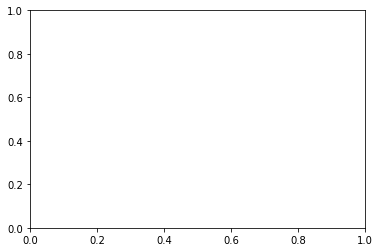

In [19]:
# Integrate in time

result_x = []
result_y = []

start = time.time()
print("Starting time marching for", nt, "steps ...")
for it in tqdm(range(
        nt + 1)):  # Actually, we do one more than nt, but that's because otherwise the last (it = nt) wouldn't plot
    if it == 0:
        t.append(dt)
    else:
        t.append(t[-1] + dt)
    
    if ((it) % generateEvery == 0):
        if (generateAnimation):
            # calculate speeds
            ux = grid.vecToField(dyOpPsi @ Psinplus1) + 1e-40
            uy = -grid.vecToField(dxOpPsi @ Psinplus1) + 1e-40
            maxSpeed = 1e-99 + np.max(np.square(ux) + np.square(uy))
            maxSpeedArr.append(maxSpeed)

            # calculate heat fluxes
            heatFluxConduction = np.sum(- grid.vecToField(dyOpTemp @ Tnplus1 - rhsDyOpTemp)[int(ny / 2), :])
            heatFluxAdvection = sqrtRa * uy[int(ny / 2), :] @ grid.vecToField(Tnplus1)[int(ny / 2), :]
            totalHeatFlux = heatFluxAdvection + heatFluxConduction

            # accumulate values
            heatFluxConductionArr.append(heatFluxConduction)
            heatFluxAdvectionArr.append(heatFluxAdvection)
            totalHeatFluxArr.append(totalHeatFlux)

            # plot velocity and temperature field
            ax1.quiver(np.linspace(0, 2, int(nx / qInt)), np.linspace(0, 1, int(ny / qInt)), ux[::qInt, ::qInt],
                       uy[::qInt, ::qInt], pivot='mid', scale=qScale)
            im = ax1.imshow((grid.vecToField(Tnplus1)), vmin=0, vmax=1, extent=[0, 2, 0, 1], aspect=1,
                            cmap=plt.get_cmap('plasma'), origin='lower')
            clrbr = plt.colorbar(im, ax=ax1)
            clrbr.set_label('dimensionless temperature', rotation=270, labelpad=20)
            ax1.set_xlabel("x [distance]")
            ax1.set_ylabel("y [distance]")

            # plot maximum fluid velocity
            ymax = 10
            ax2.set_ylim([1e-5, ymax if np.max(maxSpeedArr) * (10 ** 0.1) < ymax else np.max(maxSpeedArr) * (
                    10 ** 0.1)])  # ternary statement, cool stuff
            ax2.semilogy(t[::generateEvery], maxSpeedArr)
            cflV = dx / dt
            ax2.semilogy([0, nt * dt], [cflV, cflV], linestyle=":")
            ax2.legend(['Maximum fluid velocity', 'CFL limit %.2f' % cflV], fontsize=5, loc='lower right')
            ax2.set_xlabel("t [time]")
            ax2.set_ylabel("max V [speed]")
            ax2.set_xlim([0, nt * dt])

            # plot heat fluxes
            ax3.plot(t[::generateEvery], heatFluxAdvectionArr)
            ax3.plot(t[::generateEvery], heatFluxConductionArr)
            ax3.plot(t[::generateEvery], totalHeatFluxArr, linestyle=':')
            ax3.legend(['Advective heat flux', 'Conductive heat flux', 'Total heat flux'], fontsize=5,
                       loc='center left')
            ax3.set_xlabel("t [time]")
            ax3.set_ylabel("q [heat flux]")
            ax3.set_xlim([0, nt * dt])
            ymax = totalHeatFluxArr[0] * 1.3
            ax3.set_ylim([0, ymax if np.max(totalHeatFluxArr) * 1.1 < ymax else np.max(totalHeatFluxArr) * 1.1])

            # Plot titles
            ax1.set_title("Temperature and velocity field\nstep = %i, dt = %.2e, t = %.2f" % (it, dt, t[-1] - dt),
                          FontSize=7)
            ax2.set_title("Maximum fluid velocity over time", FontSize=7)
            ax3.set_title("Heat fluxes over time", FontSize=7)

            # Plot and redo!
            plt.savefig("simulations/field%i.png" % (it / generateEvery))
            clrbr.remove()
            ax1.clear()
            ax2.clear()
            ax3.clear()
            print("plotted time step:", it, end='\r')
            
            result_x.append(ux)
            result_y.append(uy)
    # reset time level for fields
    Tn = Tnplus1
    Psin = Psinplus1

    # Regenerate C
    C, rhsC = matrices.constructC(dxOpTemp=dxOpTemp, rhsDxOpTemp=rhsDxOpTemp, dyOpTemp=dyOpTemp,
                                  rhsDyOpTemp=rhsDyOpTemp, dlOpTemp=dlOpTemp, rhsDlOpTemp=rhsDlOpTemp, psi=Psin,
                                  dxOpPsi=dxOpPsi, dyOpPsi=dyOpPsi, sqrtRa=sqrtRa)

    # Solve for Tn+1
    if (useSuperLUFactorizationEq2):
        factor2 = sparse.linalg.factorized(sparse.csc_matrix(sparse.eye(nx * ny) + (dt / 2) * C))
        Tnplus1 = factor2(dt * rhsC + (sparse.eye(nx * ny) - (dt / 2) * C) @ Tn)
    else:
        Tnplus1 = sparse.linalg.spsolve(sparse.eye(nx * ny) + (dt / 2) * C,
                                        dt * rhsC + (sparse.eye(nx * ny) - (dt / 2) * C) @ Tn)

    # Enforcing column vector
    Tnplus1.shape = (nx * ny, 1)
    # Enforcing Dirichlet
    Tnplus1[0::ny] = np.expand_dims(tempDirichlet[0], 1)
    Tnplus1[ny - 1::ny] = np.expand_dims(tempDirichlet[1], 1)

    # Solve for Psi n+1
    if (useSuperLUFactorizationEq1):
        Psinplus1 = factor1(- sqrtRa * psiElim @ (dxOpTemp @ Tnplus1 - rhsDxOpTemp))
    else:
        Psinplus1 = sparse.linalg.spsolve(dlOpPsi, - sqrtRa * psiElim @ (dxOpTemp @ Tnplus1 - rhsDxOpTemp))

    # Enforcing column vector
    Psinplus1.shape = (nx * ny, 1)
    # Enforcing Dirichlet
    Psinplus1[0::ny] = 0
    Psinplus1[ny - 1::ny] = 0
    Psinplus1[0:ny] = 0
    Psinplus1[-ny:] = 0
    

end = time.time()
print("\nRuntime of time-marching: %.2e seconds" % (end - start))

In [10]:
np.max(uy)

1e-40

In [11]:
np.array(t[::generateEvery]).reshape(1,-1).shape

(1, 1)

In [12]:
np.array(maxSpeedArr).reshape(1,-1)

array([[2.e-80]])

In [13]:
nt

5000

In [15]:
len(heatFluxAdvectionArr)

1

In [16]:
len(totalHeatFluxArr)

1

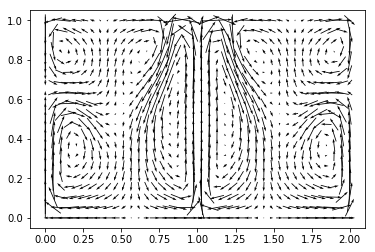

In [20]:
i=3000
qInt = 2
plt.quiver(np.linspace(0, 2, int(nx / qInt)), np.linspace(0, 1, int(ny / qInt)), result_x[i][::qInt, ::qInt],
                       result_y[i][::qInt, ::qInt], pivot='mid', scale=qScale)

In [31]:
qInt

4

In [27]:
nx/qInt

20.0

In [18]:
help(plt.quiver)

Help on function quiver in module matplotlib.pyplot:

quiver(*args, data=None, **kw)
    Plot a 2-D field of arrows.
    
    Call signatures::
    
      quiver(U, V, **kw)
      quiver(U, V, C, **kw)
      quiver(X, Y, U, V, **kw)
      quiver(X, Y, U, V, C, **kw)
    
    *U* and *V* are the arrow data, *X* and *Y* set the location of the
    arrows, and *C* sets the color of the arrows. These arguments may be 1-D or
    2-D arrays or sequences.
    
    If *X* and *Y* are absent, they will be generated as a uniform grid.
    If *U* and *V* are 2-D arrays and *X* and *Y* are 1-D, and if ``len(X)`` and
    ``len(Y)`` match the column and row dimensions of *U*, then *X* and *Y* will be
    expanded with :func:`numpy.meshgrid`.
    
    The default settings auto-scales the length of the arrows to a reasonable size.
    To change this behavior see the *scale* and *scale_units* kwargs.
    
    The defaults give a slightly swept-back arrow; to make the head a
    triangle, make *headaxis

In [29]:
np.linspace(0, 2, int(nx / qInt))

array([0.        , 0.10526316, 0.21052632, 0.31578947, 0.42105263,
       0.52631579, 0.63157895, 0.73684211, 0.84210526, 0.94736842,
       1.05263158, 1.15789474, 1.26315789, 1.36842105, 1.47368421,
       1.57894737, 1.68421053, 1.78947368, 1.89473684, 2.        ])